Warning: Here be dragons. I cannot guarantee there will be enough comments here for you to re-run everything. If you have a question, email me

v18

# Nonthermal results

In [1]:
using Revise
using PyPlot
using PyCall
using HDF5
using DataFrames
using Interpolations 
using DelimitedFiles
using XLSX
using Printf
photochemistry_source_dir = "$(@__DIR__)/Photochemistry/src/"
println("loading Photochemistry.jl from $photochemistry_source_dir")
push!(LOAD_PATH, photochemistry_source_dir)
using Photochemistry  # custom module
using QuadGK
import Base.@kwdef
using GeneralizedGenerated

loading Photochemistry.jl from /home/emc/OneDrive-CU/Research/UpperAtmoDH/Code/Photochemistry/src/


┌ Info: Precompiling Photochemistry [top-level]
└ @ Base loading.jl:1423


In [2]:
include("CUSTOMIZATIONS.jl");
include("CONSTANTS.jl");

In [3]:
# In case results dir is different in the file (running simulations for other paper)
results_dir = code_dir*"../Results/"

"/home/emc/OneDrive-CU/Research/UpperAtmoDH/Code/../Results/"

# Load atmosphere and associated parameters

In [4]:
solarmin_folder = results_dir*"I-Ts230Tm130Te190-Wstandard-Smin_frLstXpt_smin_v18/"
solarmin = get_ncurrent(solarmin_folder*"final_atmosphere.h5");

vardict_smin = load_from_paramlog(solarmin_folder);

ions_included = vardict_smin["ions_included"];
neutral_species = vardict_smin["neutral_species"];
ion_species  = vardict_smin["ion_species"];
all_species = vardict_smin["all_species"];
rxn_spreadsheet = vardict_smin["rxn_spreadsheet"];

Tn_smin = vardict_smin["Tn_arr"];
Ti_smin = vardict_smin["Ti_arr"];
Te_smin = vardict_smin["Te_arr"];
Tplasma_smin = vardict_smin["Tplasma_arr"];
Tprof_for_Hs_smin = vardict_smin["Tprof_for_Hs"];
Tprof_for_diffusion_smin = vardict_smin["Tprof_for_diffusion"];
Hs_dict_smin = vardict_smin["Hs_dict"];
speciesbclist_smin = vardict_smin["speciesbclist"];
transport_species = vardict_smin["transport_species"];


In [5]:
solarmean_folder = results_dir*"I-Ts230Tm130Te210-Wstandard-Smean_7VVsndHz_smean_v18/"
solarmean = get_ncurrent(solarmean_folder*"final_atmosphere.h5");

vardict_smean = load_from_paramlog(solarmean_folder);

Tn_smean = vardict_smean["Tn_arr"];
Ti_smean = vardict_smean["Ti_arr"];
Te_smean = vardict_smean["Te_arr"];
Tplasma_smean = vardict_smean["Tplasma_arr"];
Tprof_for_Hs_smean = vardict_smean["Tprof_for_Hs"];
Tprof_for_diffusion_smean = vardict_smean["Tprof_for_diffusion"];
Hs_dict_smean = vardict_smean["Hs_dict"];
speciesbclist_smean = vardict_smean["speciesbclist"];

In [6]:
solarmax_folder = results_dir*"I-Ts230Tm130Te280-Wstandard-Smax_0Ksq1ySO_smax_v18/"
solarmax = get_ncurrent(solarmax_folder*"final_atmosphere.h5");

vardict_smax = load_from_paramlog(solarmax_folder);

Tn_smax = vardict_smax["Tn_arr"];
Ti_smax = vardict_smax["Ti_arr"];
Te_smax = vardict_smax["Te_arr"];
Tplasma_smax = vardict_smax["Tplasma_arr"];
Tprof_for_Hs_smax = vardict_smax["Tprof_for_Hs"];
Tprof_for_diffusion_smax = vardict_smax["Tprof_for_diffusion"];
Hs_dict_smax = vardict_smax["Hs_dict"];
speciesbclist_smax = vardict_smax["speciesbclist"];

# Quick peek at HD/H2 / HDO/H2O

for comparing to all the old Kras papers and Yung1988, but I don't really care what this value is

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


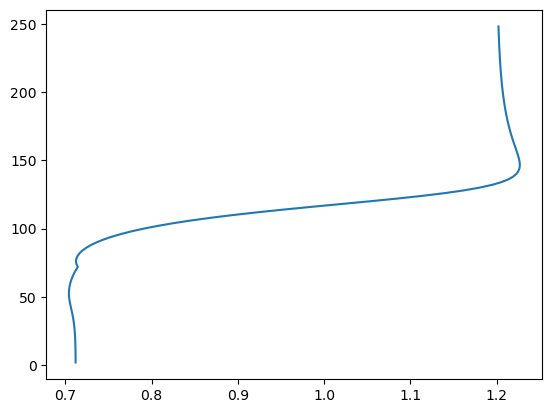

In [10]:
blah = (solarmax[:HD] ./ solarmax[:H2]) ./ (solarmax[:HDO] ./ solarmax[:H2O]);

plot(blah, plot_grid)
show()

# Solar colors

In [7]:
solarcols = get_colors(3, "plasma"; stp=0.8)

3×3 Matrix{Float64}:
 0.050383  0.029803  0.527975
 0.69284   0.165141  0.564522
 0.98826   0.652325  0.211364

# All results folder

In [8]:
all_result_plot_folder = "$(@__DIR__)/../Results/All_Results_Plots_v18/"

"/home/emc/OneDrive-CU/Research/UpperAtmoDH/Code/../Results/All_Results_Plots_v18/"

# Some global variables

In [9]:
D_ions = [s for s in ion_species if occursin('D', string(s))];
D_H_analogues = Dict(:ArDpl=>:ArHpl, :Dpl=>:Hpl, :DCOpl=>:HCOpl, :HDpl=>:H2pl,  :H2Dpl=>:H3pl, :N2Dpl=>:N2Hpl,
                           :DCO2pl=>:HCO2pl, :DOCpl=>:HOCpl, :H2DOpl=>:H3Opl, :HDOpl=>:H2Opl, :ODpl=>:OHpl);
D_bearing_species = [s for s in setdiff(union(neutral_species, ion_species), [:O1D, :Nup2D]) if occursin('D', string(s))];
speciesstyle = Dict(vcat([s=>"--" for s in setdiff(D_bearing_species, [:HD2pl])], [:HD2pl=>":", :Nup2D=>"-."]) );
problem_type="Gear";


# Some special colors for this notebook

In [10]:
global speciescolor_forDions = Dict([ion=>speciescolor[ion] for ion in keys(D_H_analogues)])
speciescolor_forDions[:H3Opl] = speciescolor[:H3Opl]

dimcolor = "xkcd:greyish"

"xkcd:greyish"

# Big plot with conditions

In [17]:
function plot_conditions(atmdict, Tn_all, Ti_all, Te_all, savepath; extra="", figsz=(14,8), globvars...)
    #=
    Tn_all: Tn for solar min, mean, max
    Ti_all: same
    Te_all: same
    =#
    
    GV = values(globvars)
    @assert all(x->x in keys(GV),  [:alt])
    
    gridspec = matplotlib.gridspec
    
    # Setup figure
    fig = figure(constrained_layout=true, figsize=figsz)
    gs = gridspec.GridSpec(2, 2, figure=fig)
    ax1 = subplot(gs.new_subplotspec((0, 0)))
    ax2 = subplot(gs.new_subplotspec((0, 1)))
    ax3 = subplot(gs.new_subplotspec((1, 0), colspan=2))

    subplots_adjust(wspace=0.05, hspace=0.3)
    # setup 
    plot_bg(ax1)
    plot_bg(ax2)
    plot_bg(ax3)

    rcParams = PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 14
    rcParams["axes.labelsize"]= 16
    rcParams["xtick.labelsize"] = 16
    rcParams["ytick.labelsize"] = 16
    
    # AX 1: TEMPERATURE ===================================================
    ioncol = "xkcd:kelly green"
    ecol = "cornflowerblue"
    ax1.plot(Tn_all[:, 1], GV.alt./1e5, label="Neutrals, solar min", color=solarcols[1, :])
    ax1.plot(Tn_all[:, 2], GV.alt./1e5, label="Neutrals, solar mean", color=solarcols[2, :])
    ax1.plot(Tn_all[:, 3], GV.alt./1e5, label="Neutrals, solar max", color=solarcols[3, :])
    ax1.plot(Ti_all[:, 1], GV.alt./1e5, label="Ions", color=ioncol)
    ax1.plot(Te_all[:, 1], GV.alt./1e5, label="Electrons", color=ecol)
    # ax1.legend(fontsize=14, loc=(.5,.05))#"center right")
    ax1.set_xscale("log")

    # plot the control temps
    # surface
    ax1.scatter(Tn_all[:, 1][1], 0, marker="o", color=medgray, zorder=10)
    ax1.text(Tn_all[:, 1][1]+10, 0,"$(Int64(round(Tn_all[:, 1][1], digits=0))) K ")

    # mesosphere
    meso_ind = findfirst(x->x==minimum(Tn_all[:, 1]), Tn_all[:, 1])
    ax1.scatter(Tn_all[:, 1][meso_ind], GV.alt[meso_ind+5]/1e5, marker="o", color=medgray, zorder=10)
    ax1.text(Tn_all[:, 1][meso_ind]+5, GV.alt[meso_ind+5]/1e5, "$(Int64(round(Tn_all[:, 1][meso_ind], digits=0))) K ")

    # exosphere
    ax1.scatter(Tn_all[:, 1][end], 250, marker="o", color=medgray, zorder=10)
    ax1.text(Tn_all[:, 1][end]*0.97, 230, "$(Int64(round(Tn_all[:, 1][end], digits=0))) K ", ha="right")
    ax1.scatter(Tn_all[:, 2][end], 250, marker="o", color=medgray, zorder=10)
    ax1.text(Tn_all[:, 2][end]*1.01, 225, "$(Int64(round(Tn_all[:, 2][end], digits=0))) K ", ha="left")
    ax1.scatter(Tn_all[:, 3][end], 250, marker="o", color=medgray, zorder=10)
    ax1.text(Tn_all[:, 3][end]*1.05, 230, "$(Int64(round(Tn_all[:, 3][end], digits=0))) K ")

    # final labels
    ax1.set_ylabel("Altitude (km)")
    ax1.set_yticks(collect(0:50:Int64(GV.alt[end]/1e5)))
    ax1.set_xlabel("Temperature (K)")
    ax1.set_xlim(95, 2e3)
    ax1.tick_params(which="both", axis="x", top=true)
    
    ax1.text(180, 265, "Neutrals")
    ax1.text(600, 230, "Ions", color=ioncol)
    ax1.text(650, 150, "Electrons", color=ecol)

    # AX 2: WATER =================================================================================
    ax2.plot(atmdict[:H2O], plot_grid, color=GV.speciescolor[:H2O], label=L"H$_2$O", zorder=3)
    ax2.plot(atmdict[:HDO], plot_grid, color=GV.speciescolor[:HDO], linestyle="--", label="HDO", zorder=3)
    ax2.text(1e-3,40, "Water abundance fixed")
    ax2.fill_between([1e-4, 1e15], [0, 0], y2=[72, 72], color="#bbb", zorder=2)
    ax2.set_xscale("log")
    ax2.set_xlim(1e-4, 1e14)
    ax2.tick_params(which="both", labelleft=false)
    ax2.set_xlabel(L"Initial number density (cm$^{-3}$)")
    ax2.legend()
    
    # AX 3: Solar input ============================================================================
    solarmin_flux = readdlm(code_dir*"marssolarphotonflux_solarmin_NEW.dat",'\t', Float64, comments=true, comment_char='#')[1:2000,:]
    solarmean_flux = readdlm(code_dir*"marssolarphotonflux_solarmean_NEW.dat",'\t', Float64, comments=true, comment_char='#')[1:2000,:]
    solarmax_flux = readdlm(code_dir*"marssolarphotonflux_solarmax_NEW.dat",'\t', Float64, comments=true, comment_char='#')[1:2000,:]
    ax3.plot(solarmin_flux[1:2000, 1], solarmin_flux[1:2000, 2], label="Solar minimum", color=solarcols[1, :])
    ax3.plot(solarmean_flux[1:2000, 1], solarmean_flux[1:2000, 2], label="Solar mean", color=solarcols[2, :])
    ax3.plot(solarmax_flux[1:2000, 1], solarmax_flux[1:2000, 2], label="Solar maximum", color=solarcols[3, :])
    ax3.set_yscale("log")
    ax3.legend()
    ax3.set_xlabel("Wavelength (nm)")
    # ax2.tick_params(axis="y", labelleft=false)
    ax3.set_ylabel("Insolation\n"*L"($\gamma$ s$^{-1}$ cm$^{-2}$ nm$^{-1}$)")
    ax3.set_xlim(0.5, 350)
    
    savefig(savepath*"inputs$(extra).pdf", format="pdf", dpi=300, bbox_inches="tight")
end

plot_conditions (generic function with 1 method)

sys:1: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
sys:1: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


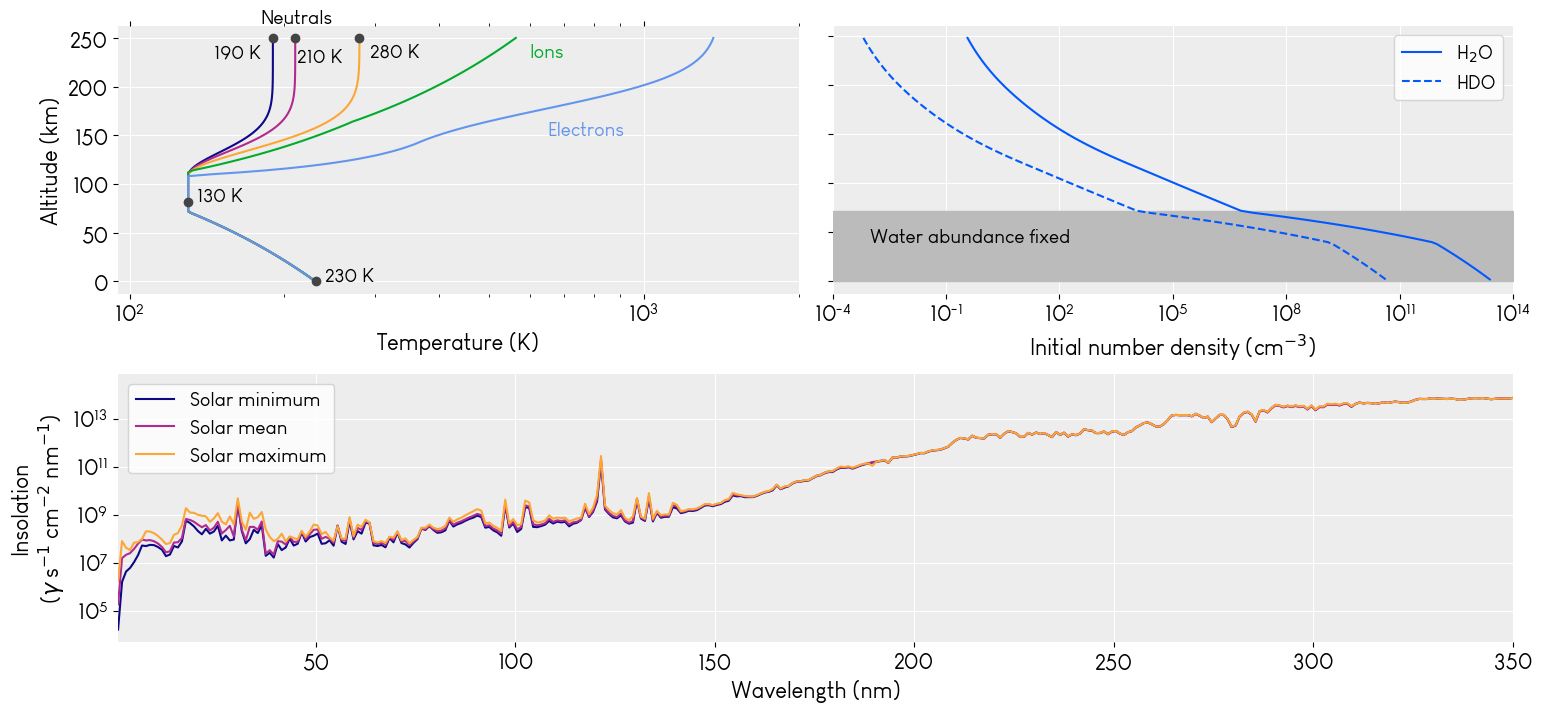

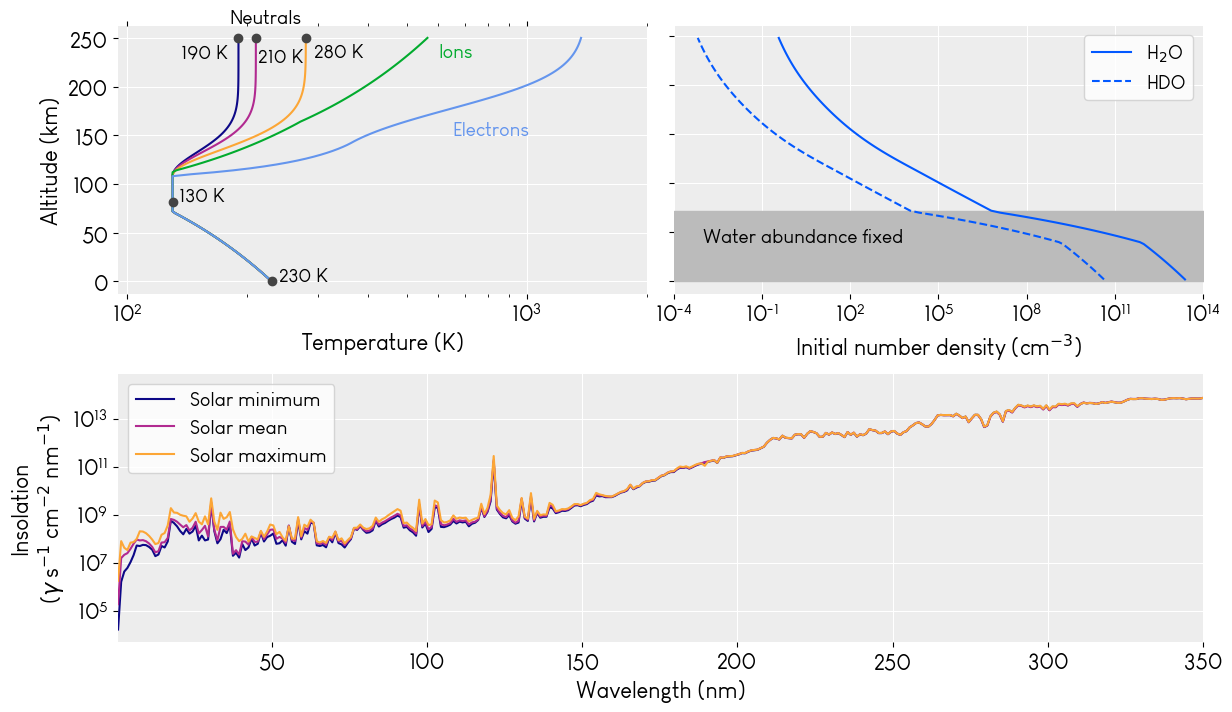

In [48]:
Tn_all = hcat(Tn_smin, Tn_smean, Tn_smax)
Ti_all = hcat(Ti_smin, Ti_smean, Ti_smax)
Te_all = hcat(Te_smin, Te_smean, Te_smax)

initial_nc = get_ncurrent(solarmin_folder*"initial_atmosphere.h5")

# POSTER VERSION
plot_conditions(initial_nc, Tn_all, Ti_all, Te_all, all_result_plot_folder; extra="poster", figsz=(18,8), alt, all_species, speciescolor)

# REGULAR VERSION
plot_conditions(initial_nc, Tn_all, Ti_all, Te_all, all_result_plot_folder; extra="paper", alt, all_species, speciescolor)


# Neutral densities

In [85]:
function analogue(s, direction)
    #=
    s: species
    direction: "to D" or "to H"
    =#
    
    s = string(s)
    
    if direction=="to H"
        return Symbol(replace(s, "H2D"=>"H3", "HD"=>"H2", "D"=>"H") )
    else
        return Symbol(replace(s, "H3"=>"H2D", "H2"=>"HD", "H"=>"D") )
    end
end

function plot_species_on_demand(atmdict, atmdict2, spclist_top, spclist_bottom, savepath::String, figtitle; 
                                showonly=false, xlab=L"Number density (cm$^{-3}$)", xlims=(1e-12, 1e18), figsz=(16,6), ylims=(0,zmax/1e5), titl=nothing,
                                overridestyle=false, posdict = Dict(), extratext=nothing, LL=(0.9,0.9),
                                globvars...)
    #=
    Makes a "spaghetti plot" of the species in spclist, in concentrations by altitude in the
    atmosphere. 

    atmdict: dictionary of vertical profiles of a plottable quantity, keys are species names.
    spclist: a list of species to plot.
    savepath: path and name for saving resulting .png file
    figtitle: what to call the file
    iter: iteration, for plotting the atmosphere during convergence
    showonly: whether to just show() the plot instead of saving. If setting to true, send in junk string for savepath.
    xlab: override for x axis label
    xlim_1: override for x axis limits in column 1 or entire plot of length(spclists)==1
    xlim_2: override for x axis limits in column 2
    overridestyle: if set to true, will just plot plain lines rather than using speciesstyle
    =#

    rcParams = PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 18
    rcParams["axes.labelsize"]= 20
    rcParams["xtick.labelsize"] = 18
    rcParams["ytick.labelsize"] = 18
    
    GV = values(globvars)
    @assert all(x->x in keys(GV),  [:plot_grid, :speciescolor, :speciesstyle, :zmax])
    
    atm_fig, ax = subplots(2, 1, sharex=true, sharey=true, figsize=figsz)
    plot_bg(ax[1])
    plot_bg(ax[2])
    tight_layout()
    
    for sp in spclist_top
        col = GV.speciescolor[sp]
        if overridestyle
            ls = "-"
        else
            ls = get(GV.speciesstyle, sp, "-")
        end
        ax[1].fill_betweenx(plot_grid, atmdict[sp], x2=atmdict2[sp], color=col, alpha=0.25, zorder=10)
        ax[1].plot(atmdict[sp], GV.plot_grid, color=col, linewidth=1, label=sp, linestyle=ls, zorder=10)
        ax[1].plot(atmdict2[sp], GV.plot_grid, color=col, linewidth=3, label=sp, linestyle=ls, zorder=10)
        ax[1].set_xlim(xlims[1], xlims[2])
        ax[1].set_ylabel("Altitude (km)")
        
        textloc = get(posdict, sp, nothing)
        if textloc != nothing
            ax[1].text(posdict[sp]..., L"$\mathrm{%$(string_to_latexstr(string(sp), dollarsigns=false))}$", transform=ax[1].transAxes, color=col, fontsize=15)
        end
    end
    ax[1].tick_params(axis="x", which="both", labeltop=false, top=true)
    ax[1].set_ylim(ylims[1], ylims[2])
    ax[1].set_xscale("log")
    
    for sp in spclist_bottom
        col = GV.speciescolor[sp]
        if overridestyle
            ls = "-"
        else
            ls = get(GV.speciesstyle, sp, "-")
        end
        ax[2].fill_betweenx(plot_grid, atmdict[sp], x2=atmdict2[sp], color=col, alpha=0.25, zorder=10)
        ax[2].plot(atmdict[sp], GV.plot_grid, color=col, linewidth=1, label=sp, linestyle=ls, zorder=10)
        ax[2].plot(atmdict2[sp], GV.plot_grid, color=col, linewidth=3, label=sp, linestyle=ls, zorder=10)
        ax[2].set_xlim(xlims[1], xlims[2])
        ax[2].set_ylabel("Altitude [km]")
        
        textloc = get(posdict, sp, nothing)
        if textloc != nothing
            ax[2].text(posdict[sp]..., L"$\mathrm{%$(string_to_latexstr(string(sp), dollarsigns=false))}$", transform=ax[2].transAxes, color=col, fontsize=15)
        end
    end
    ax[2].tick_params(axis="x", which="both", labeltop=false, top=true)
    ax[2].set_ylim(ylims[1], ylims[2])
    ax[2].set_xscale("log")
    ax[2].set_xlabel(xlab)
    L2D = PyPlot.matplotlib.lines.Line2D
    legend_elements = [L2D([0], [0], color="black", linewidth=1, label="Solar minimum"),
                        L2D([0], [0], color="black", linewidth=3, label="Solar maximum")]
    ax[1].legend(handles=legend_elements, loc=LL, fontsize=16)
    


    if titl!=nothing
        ax[1].set_title(titl)
    end
    
    if extratext != nothing
        for i in 1:length(ax)
            ax[i].text(extratext["loc"][i, :]..., extratext["text"][i], color="#262626", fontsize=extratext["fs"], transform=ax[i].transAxes)
        end
    end

    if showonly==false  
        atm_fig.savefig(savepath*"$(figtitle).pdf", format="pdf", bbox_inches="tight", dpi=300)
    end
    show()
end   
    

plot_species_on_demand (generic function with 1 method)

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


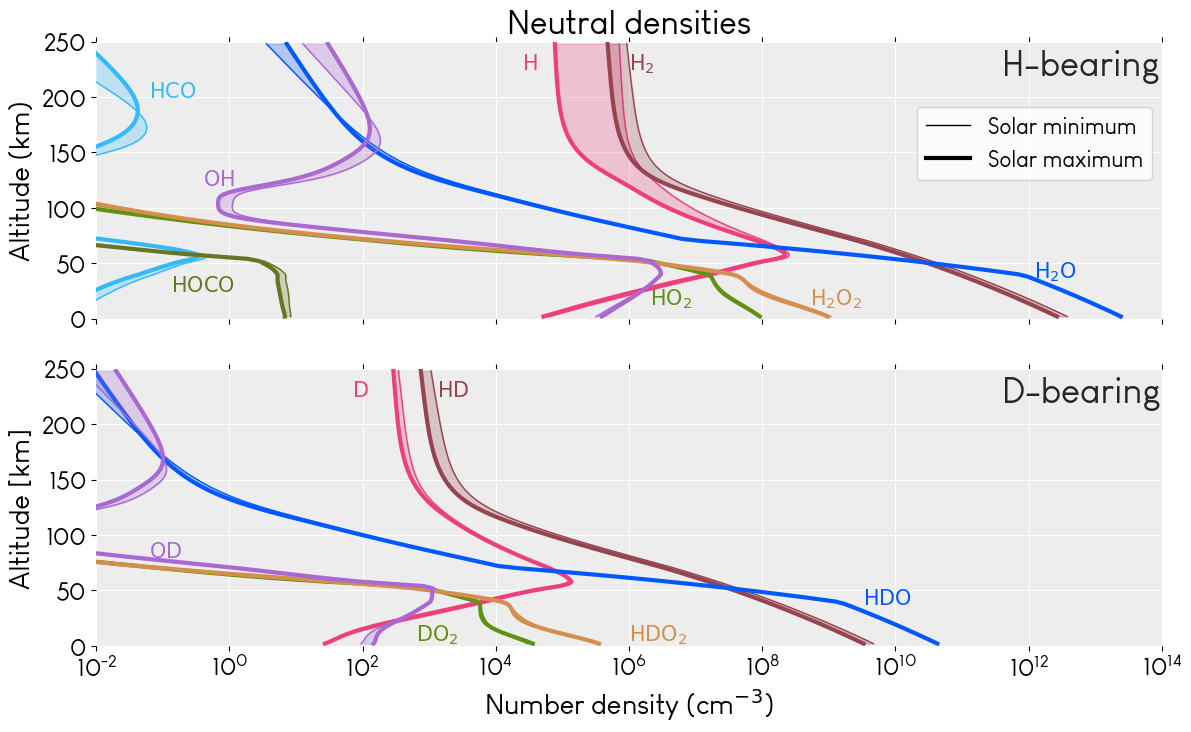

In [86]:
D_neutrals = setdiff(D_bearing_species, D_ions)
H_neutrals = [analogue(s, "to H") for s in D_neutrals]

plot_species_on_demand(solarmin, solarmax, H_neutrals, D_neutrals, all_result_plot_folder, "neutral_species"; titl="Neutral densities",
                        overridestyle=true, figsz=(12,7), xlims=(1e-2, 1e14), 
                        posdict = Dict(:D=>[0.24, 0.9], :DO2=>[0.3, 0.02],  
                                       :HD=>[0.32, 0.9], :HDO=>[0.72, 0.15], :HDO2=>[0.5, 0.02], :OD=>[0.05, 0.32],  
                                       :H=>[0.4, 0.9], :HCO=>[0.05, 0.8], :HO2=>[0.52, 0.05], :HOCO=>[0.07, 0.1],
                                       :H2=>[0.5, 0.9], :H2O=>[0.88, 0.15], :H2O2=>[0.67, 0.05], :OH=>[0.1, 0.48]), 
                        extratext=Dict("loc"=>[0.85 0.88; 0.85 0.88], "text"=>["H-bearing", "D-bearing"], "fs" => 26), LL=(0.77, 0.5),
                        plot_grid, speciescolor, speciesstyle, zmax)

# Re-print of the whole atmosphere plot so it looks nicer for the paper

In [87]:
plot_atm(solarmean, all_result_plot_folder*"final_atm_for_SI.pdf", 1e-12, electron_density(solarmean; e_profile_type="quasineutral", ion_species, non_bdy_layers); print_shortcodes=false, 
                  t="Converged atmosphere (solar mean)", xlim_2=(1e-5, 2e5), neutral_species, ion_species, plot_grid, speciescolor, speciesstyle, zmax)

# Comparison with data and other models

## Set up the axes

In [21]:
panel_groups_benna = Dict([1,1]=>[:CO2pl, :Opl, :O2pl, :Hpl, :H2pl, :H3pl, :CO, :O, :Ar, :N2, :N2pl, :CHpl, :HOCpl, :NHpl, :NOpl],
                        [1,2]=>[:HO2pl, :HNOpl, :OHpl, :Arpl, :COpl, :H2Opl, :H3Opl,  :NHpl, :N2Hpl, :HCOpl,  :HCO2pl, ])

axes_by_sp_benna = Dict()
for k in keys(panel_groups_benna)
    for sp in panel_groups_benna[k]
        axes_by_sp_benna[sp] = k
    end
end

In [22]:
header = ""
flag = false
current_sp = :Z
NGIMS_dat = Dict()

# read file contents, one line at a time
open("../Resources/DataFromPapers/NGIMS/NGIMS_data.txt") do f
    global header = readline(f)
    
    # line_number
    line = 1 
    # read till end of file
    while !eof(f) 
        # read a new / next line for every iteration          
        s = readline(f)
        if occursin("pl", string(s))
            global flag = true
            global current_sp = Symbol(s)
            NGIMS_dat[Symbol(s)] = DataFrame(density=Float64[], alt=Float64[])
            continue
        elseif s==""
            global flag = false
        end
        
        if flag
            push!(NGIMS_dat[current_sp], map(x->parse(Float64,x), split(s)))
        end
    end
end

## Benna 2015

In [23]:
function compare_with_benna(plot_me, spclist, savepath::String, comparison_data, axes_by_sp; nrow=1, ncol=2, legpanel=2, legloc=(1,1.1),# Modified - global-free, All calls updated.
                                linetype="line", leglab="Fox 2015b", xlab=L"Number density [cm$^{-3}$]", t=nothing, showonly=false, fn="density",
                                xlims=[(0.1, 2e5) (0.001, 2e3); (1e-5, 1e2) (1, 1e9)], figsz=(16,6), ylims=(0,zmax/1e5), h=0.05, w=0.02,
                                spcpos=Dict(:O2pl=>[6e4, 110], :CO2pl=>[1.6e4, 130], :Opl=>[70, 130], :HCOpl=>[1.2e3, 150], :HCO2pl=>[2,225]), 
                                globvars...)
                                
    #=
    Makes a "spaghetti plot" of the species in spclist, in concentrations by altitude in the
    atmosphere. 

    plot_me: dictionary of vertical profiles of a plottable quantity, keys are species names.
    spclist: a list of species to plot.
    savepath: path and name for saving resulting .png file
    t: timestep, for plotting the atmosphere during convergence
    iter: iteration, for plotting the atmosphere during convergence
    showonly: whether to just show() the plot instead of saving. If setting to true, send in junk string for savepath.
    xlab: override for x axis label
    xlim_1: override for x axis limits in column 1 or entire plot of length(spclists)==1
    xlim_2: override for x axis limits in column 2
    =#
    
    
    GV = values(globvars)
    @assert all(x->x in keys(GV),  [:plot_grid, :speciescolor, :speciesstyle, :zmax])


    rcParams = PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 16
    rcParams["axes.labelsize"]= 18
    rcParams["xtick.labelsize"] = 16
    rcParams["ytick.labelsize"] = 16
    
    atm_fig, atm_ax = subplots(nrow, ncol, sharex=true, sharey=true, figsize=figsz)
    subplots_adjust(hspace=h, wspace=w)
    
    # Title
    atm_ax[1,1].set_title(t)#, ha="center", transform=atm_ax[1,1].transAxes)
    
    # Apply settings to all axes
    for ax in atm_ax
        plot_bg(ax)
        ax.tick_params(axis="x", which="both", top=true)
        ax.set_ylim(ylims[1], ylims[2])
        ax.set_xscale("log")
    end

    
    
    # set the tick labels
    atm_ax[1].tick_params(axis="x", which="both", labeltop=true, labelbottom=false)
    atm_ax[2].tick_params(axis="x", which="both", labeltop=false, labelbottom=true)
    for i in 1:nrow
        atm_ax[i].set_ylabel("Altitude (km)")
    end
    atm_ax[2].set_xlabel(L"Number density (cm$^{-3}$)")
    
    # Plotting
    lw = 0
    ms = 0
    ls = 0
    lw_mine = 2
    for sp in intersect(keys(comparison_data), spclist)
        a = axes_by_sp[sp]
        col = GV.speciescolor[sp]
        atm_ax[a[2]].set_xlim(xlims[a...][1], xlims[a...][2])
        
        # Plotting
        atm_ax[a[2]].plot(plot_me[sp], GV.plot_grid, color=col,
                           linewidth=lw_mine, label=sp, linestyle=get(GV.speciesstyle, sp, "-"), zorder=10)
        if linetype=="line"
            lw = 2
            atm_ax[a[2]].plot(comparison_data[sp]."density", comparison_data[sp]."alt", color = GV.speciescolor[sp], linestyle="--", linewidth=lw)
            ms = 0
            ls = "--"
        elseif linetype=="ballchain"
            lw = 1
            ls = ":"
            ms = 4
            atm_ax[a[2]].plot(comparison_data[sp]."density", comparison_data[sp]."alt", color = GV.speciescolor[sp], markersize=ms, marker="o", 
                   linestyle=ls, linewidth=lw)            
        elseif linetype=="scatter"
            atm_ax[a[2]].scatter(comparison_data[sp]."density", comparison_data[sp]."alt", color = GV.speciescolor[sp], s=15, marker="o")
            lw = 0
            ms = 5
            ls = "-"
        end
        
        # Text labels
        splabel = string_to_latexstr(string(sp)) 
        atm_ax[a[2]].text(spcpos[sp]..., splabel, va="top", transform=atm_ax[a[2]].transAxes, color=GV.speciescolor[sp])
    end

    # Legend
    L2D = PyPlot.matplotlib.lines.Line2D
    lines = [L2D([0], [0], color="black", linewidth=lw_mine, linestyle="-"), 
             L2D([0], [0], color="black", linewidth=lw, linestyle=ls, marker="o", markersize=ms)]
    labels = ["This work", leglab]
    atm_ax[legpanel].legend(lines, labels, loc=legloc, borderaxespad=0, fontsize=14)

    if showonly==false  
        atm_fig.savefig(savepath*fn*".pdf", format="pdf", bbox_inches="tight", dpi=300)
    end
    show()
end


compare_with_benna (generic function with 1 method)

### Benna - solar min

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


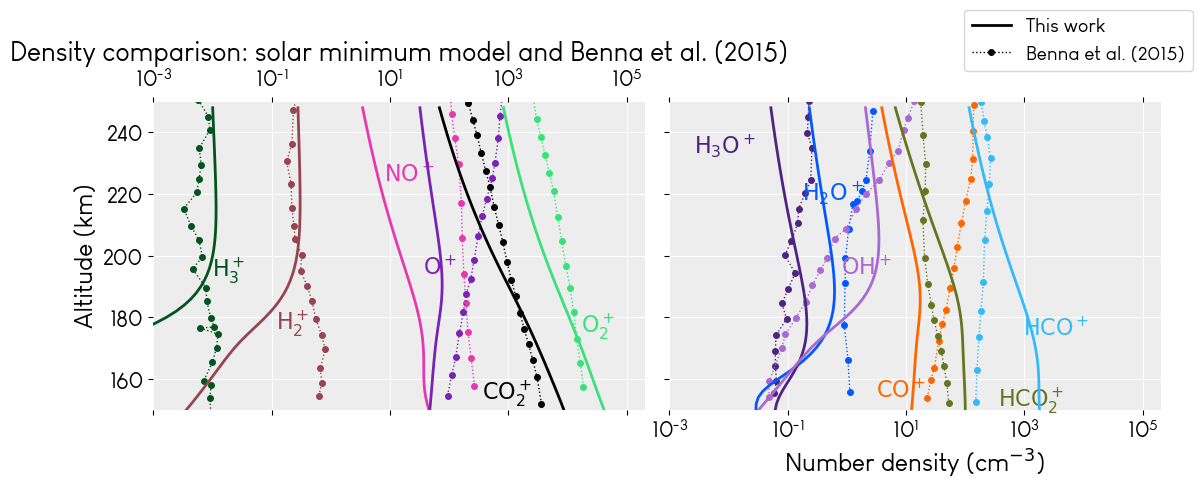

In [39]:
compare_with_benna(solarmin, [:CO2pl, :O2pl, :Opl, :HCOpl, :HCO2pl, :Hpl, :H2pl, :H3pl, :H2Opl, :H3Opl, :N2Hpl, :NOpl, :OHpl, :COpl], 
                                all_result_plot_folder, NGIMS_dat, axes_by_sp_benna; 
                                t="Density comparison: solar minimum model and Benna et al. (2015)", 
                                leglab="Benna et al. (2015)", fn="comp_ngims_smin", w=0.05, nrow=1, ncol=2, legloc=(0.6,1.1),
                                linetype="ballchain", showonly=false, xlims=[(1e-3, 2e5) (1e-2, 1e4); (1e-3, 2e5) (1e-3, 1e3)], figsz=(13,4), ylims=(150, 250),
                                spcpos=Dict(:CO2pl=>[0.67,0.1], :O2pl=>[0.87, 0.32], :Opl=>[0.55, 0.5], :HCOpl=>[0.72, 0.3], :HCO2pl=>[0.67, 0.08],
                                               :Hpl=>[0.3,0.65], :H2pl=>[0.25,0.33], :H3pl=>[0.12,0.5], :H2Opl=>[0.27,0.75], :H3Opl=>[0.05,0.9], 
                                               :N2Hpl=>[0.35,0.75], :NOpl=>[0.47,0.8], :OHpl=>[0.35,0.5], :HNOpl=>[0.2,0.83], :COpl=>[0.42,0.1]),
                                plot_grid, speciescolor, speciesstyle, zmax)

### Benna - solar mean

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


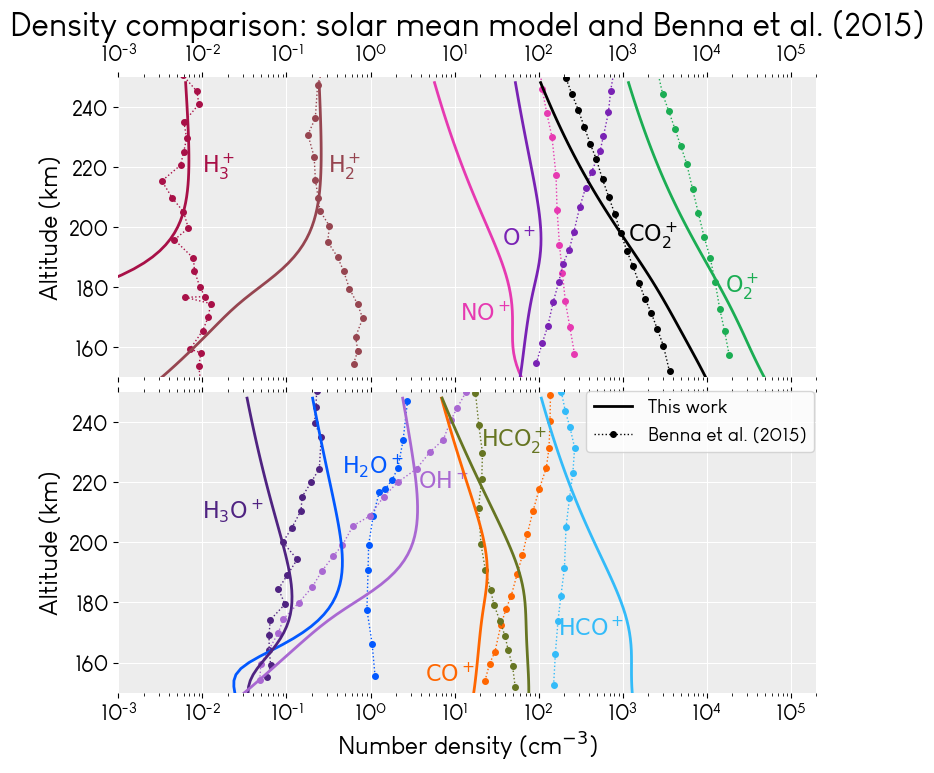

In [88]:
compare_with_benna(solarmean, [:CO2pl, :O2pl, :Opl, :HCOpl, :HCO2pl, :Hpl, :H2pl, :H3pl, :H2Opl, :H3Opl, :N2Hpl, :NOpl, :OHpl, :COpl], 
                                all_result_plot_folder, NGIMS_dat, axes_by_sp_benna; t="Density comparison: solar mean model and Benna et al. (2015)", 
                                fn="comp_ngims_smean", linetype="ballchain", leglab="Benna et al. (2015)", h=0.05,nrow=2, ncol=1, legloc=(0.67, 0.8),
                                showonly=false, xlims=[(1e-3, 2e5) (1e-3, 2e5); (1e-3, 2e5) (1e-3, 2e4)], figsz=(9,8), ylims=(150, 250), 
                                spcpos=Dict(:CO2pl=>[0.73,0.52], :O2pl=>[0.87, 0.35], :Opl=>[0.55, 0.5], :HCOpl=>[0.63, 0.25], 
                                            :HCO2pl=>[0.52, 0.89], :Hpl=>[0.3,0.65], :H2pl=>[0.3,0.75], :H3pl=>[0.12,0.75], 
                                            :H2Opl=>[0.32,0.8], :H3Opl=>[0.12,0.65], :N2Hpl=>[0.35,0.75], :NOpl=>[0.49,0.25], 
                                            :OHpl=>[0.43,0.74], :HNOpl=>[0.2,0.83], :COpl=>[0.44,0.1]),
                                plot_grid, speciescolor, speciesstyle, zmax)

## Jane Fox 2015b

In [16]:
function compare_with_fox(plot_me, spclist, savepath::String, comparison_data, axes_by_sp; opt_comp_2=nothing,
                                nrow=2, ncol=2, legloc=[1,1], legax=[2,2],
                                linetype="line", leglab="Fox et al. 2015", optleglab=nothing, xlab=L"Number density [cm$^{-3}$]", t=nothing, showonly=false, fn="density",
                                xlims=[(0.1, 2e5) (0.001, 2e3); (1e-5, 1e2) (1, 1e9)], figsz=(16,6), ylims=(0,zmax/1e5), h=0.05, w=0.02,
                                spcpos=Dict(:O2pl=>[6e4, 110], :CO2pl=>[1.6e4, 130], :Opl=>[70, 130], :HCOpl=>[1.2e3, 150], :HCO2pl=>[2,225]), 
                                globvars...)
                                
    #=
    Makes a "spaghetti plot" of the species in spclist, in concentrations by altitude in the
    atmosphere. 

    plot_me: dictionary of vertical profiles of a plottable quantity, keys are species names.
    spclist: a list of species to plot.
    savepath: path and name for saving resulting .png file
    t: timestep, for plotting the atmosphere during convergence
    iter: iteration, for plotting the atmosphere during convergence
    showonly: whether to just show() the plot instead of saving. If setting to true, send in junk string for savepath.
    xlab: override for x axis label
    xlim_1: override for x axis limits in column 1 or entire plot of length(spclists)==1
    xlim_2: override for x axis limits in column 2
    =#
    
    
    GV = values(globvars)
    @assert all(x->x in keys(GV),  [:plot_grid, :speciescolor, :speciesstyle, :zmax])


    rcParams = PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 16
    rcParams["axes.labelsize"]= 18
    rcParams["xtick.labelsize"] = 16
    rcParams["ytick.labelsize"] = 16
    
    # nrow = 2
    # ncol = 2
    atm_fig, atm_ax = subplots(nrow, ncol, sharey=true, figsize=figsz)
    subplots_adjust(hspace=h, wspace=w)
    
    # Title
    atm_ax[1,1].text(0.9, 1.2, t, ha="center", transform=atm_ax[1,1].transAxes, fontsize=22)
    
    # Apply settings to all axes
    for ax in atm_ax
        plot_bg(ax)
        ax.set_ylim(ylims[1], ylims[2])
        ax.set_xscale("log")
    end

    # Apply to all columns but not all rows
    for j in 1:ncol
        atm_ax[nrow, j].set_xlabel(L"Number density (cm$^{-3}$)")
        atm_ax[nrow, j].tick_params(axis="x", which="both",labelbottom=true, labeltop=true, top=true)
        atm_ax[1, j].tick_params(axis="x", which="both", labeltop=true, labelbottom=true, top=true)
    end
    
    # Apply to all rows but not all columns
    for i in 1:nrow
        atm_ax[i,1].set_ylabel("Altitude (km)") 
    end
    
    # Plotting
    lw = 0
    ms = 0
    ls = "-"
    
    lw_opt = 0
    ms_opt = 0
    ls_opt = "-"
    lw_mine = 2
    for sp in intersect(keys(comparison_data), spclist)
        a = axes_by_sp[sp]
        col = GV.speciescolor[sp]
        atm_ax[a[1], a[2]].set_xlim(xlims[a...][1], xlims[a...][2])
        
        # Plotting
        atm_ax[a[1], a[2]].plot(plot_me[sp], GV.plot_grid, color=col,
                           linewidth=lw_mine, label=sp, linestyle=get(GV.speciesstyle, sp, "-"), zorder=10)
        if linetype=="line"
            lw = 1
            atm_ax[a[1], a[2]].plot(comparison_data[sp]."density", comparison_data[sp]."alt", color = GV.speciescolor[sp], linestyle="--", linewidth=lw)
            ms = 0
            ls = "-"
        elseif linetype=="ballchain"
            lw = 1
            ls = ":"
            ms = 4
            atm_ax[a[1], a[2]].plot(comparison_data[sp]."density", comparison_data[sp]."alt", color = GV.speciescolor[sp], markersize=ms, marker="o", 
                   linestyle=ls, linewidth=lw)            
        elseif linetype=="scatter"
            atm_ax[a[1], a[2]].scatter(comparison_data[sp]."density", comparison_data[sp]."alt", color = GV.speciescolor[sp], s=15, marker="o")
            lw = 0
            ms = 5
            ls = "-"
        end
        
        if (opt_comp_2 != nothing) && (sp in keys(opt_comp_2))
            lw_opt = 1
            ls_opt = ":"
            ms_opt = 4
            atm_ax[a[1], a[2]].plot(opt_comp_2[sp]."density", opt_comp_2[sp]."alt", color = GV.speciescolor[sp], markersize=ms_opt, marker="o", 
                   linestyle=ls_opt, linewidth=lw_opt)            
        end
        
        # Text labels
        splabel = string_to_latexstr(string(sp)) 
        atm_ax[a[1], a[2]].text(spcpos[sp]..., splabel, va="top", transform=atm_ax[a[1], a[2]].transAxes, color=GV.speciescolor[sp])
    end

    # Legend
    L2D = PyPlot.matplotlib.lines.Line2D
    lines = [L2D([0], [0], color="black", linewidth=lw_mine, linestyle="-"), 
             L2D([0], [0], color="black", linewidth=lw, linestyle="--", marker="o", markersize=ms)]
    labels = ["This work", leglab]
    
    if opt_comp_2 != nothing
        push!(lines, L2D([0], [0], color="black", linewidth=lw_opt, linestyle=ls_opt, marker="o", markersize=ms_opt))
        push!(labels, optleglab)
    end
        
    atm_ax[legax...].legend(lines, labels, loc=(legloc[1], legloc[2]), borderaxespad=0, fontsize=14)

    if showonly==false  
        atm_fig.savefig(savepath*fn*".pdf", format="pdf", bbox_inches="tight", dpi=300)
    end
    show()
end


compare_with_fox (generic function with 1 method)

In [17]:
# Jane fox data
header = ""
flag = false
current_sp = :Z
janefox_dat = Dict()

# read file contents, one line at a time
open("../Resources/DataFromPapers/Fox2015_Waterions/jane_fox_modeloutput_2015b.txt") do f
    global header = readline(f)

    # read till end of file
    while !eof(f) 
        # read a new / next line for every iteration          
        s = readline(f)
        if occursin(r"[A-Z]+", string(s))
            global flag = true
            global current_sp = Symbol(s)
            janefox_dat[Symbol(s)] = DataFrame(density=Float64[], alt=Float64[])
            continue
        elseif s==""
            global flag = false
        end
        
        if flag
            push!(janefox_dat[current_sp], map(x->parse(Float64,x), split(s)))
        end
    end
end

In [18]:
panel_groups_fox = Dict([1,1]=>[:CO2pl, :NOpl, :Opl, :O2pl,  :Hpl, :Arpl, :N2pl, :COpl], [2,1]=>[:OHpl, :H3pl, :H2pl, :H2Opl, :H3Opl, :CHpl, :HOCpl, :NHpl],
                        [1,2]=>[:HO2pl, :HNOpl, :ArHpl, :HCOpl, :HCO2pl, :N2Hpl], [2,2]=>[:H2O, :H, :H2])

axes_by_sp_fox = Dict()
for k in keys(panel_groups_fox)
    for sp in panel_groups_fox[k]
        axes_by_sp_fox[sp] = k
    end
end

### Fox 2015 solar min


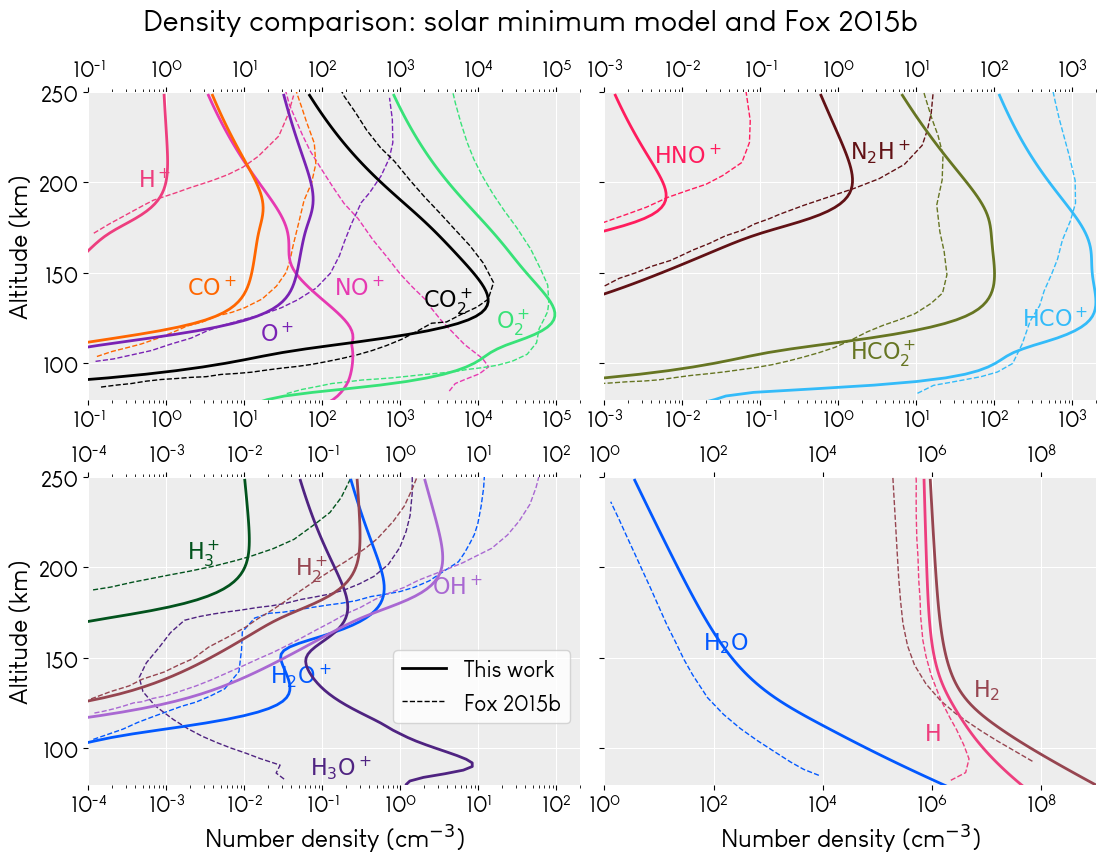

In [39]:
compare_with_fox(solarmin, [:CO2pl, :O2pl, :Opl, :HCOpl, :HCO2pl, :Hpl, :H2pl, :H3pl, :H2Opl, :H3Opl, :N2Hpl, :NOpl, :OHpl, :HNOpl, :COpl,
                            :H2O, :H, :H2], 
                                all_result_plot_folder, janefox_dat, axes_by_sp_fox; t="Density comparison: solar minimum model and Fox 2015b", 
                                fn="comp_fox2015b_smin", legax=[2,1], legloc=[0.62,0.2],  h=0.25, w=0.05,
                                showonly=false, xlims=[(1e-1, 2e5) (1e-3, 2e3); (1e-4, 200) (1, 1e9)], figsz=(13,9), ylims=(80, 250),
                                spcpos=Dict(:CO2pl=>[0.68,0.37], :O2pl=>[0.83, 0.3], :Opl=>[0.35, 0.25], :HCOpl=>[0.85, 0.3], :HCO2pl=>[0.5, 0.2],
                                           :Hpl=>[0.1,0.75], :H2pl=>[0.42,0.75], :H3pl=>[0.2,0.8], :H2Opl=>[0.37,0.4], :H3Opl=>[0.45,0.1], 
                                           :N2Hpl=>[0.5,0.85], :NOpl=>[0.5,0.4], :OHpl=>[0.7,0.68], :HNOpl=>[0.1,0.83], :COpl=>[0.2,0.4],
                                           :H2O=>[0.2, 0.5], :H2=>[0.75,0.35], :H=>[0.65,0.2]),
                                plot_grid, speciescolor, speciesstyle, zmax)

### Fox 2015 solar mean

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


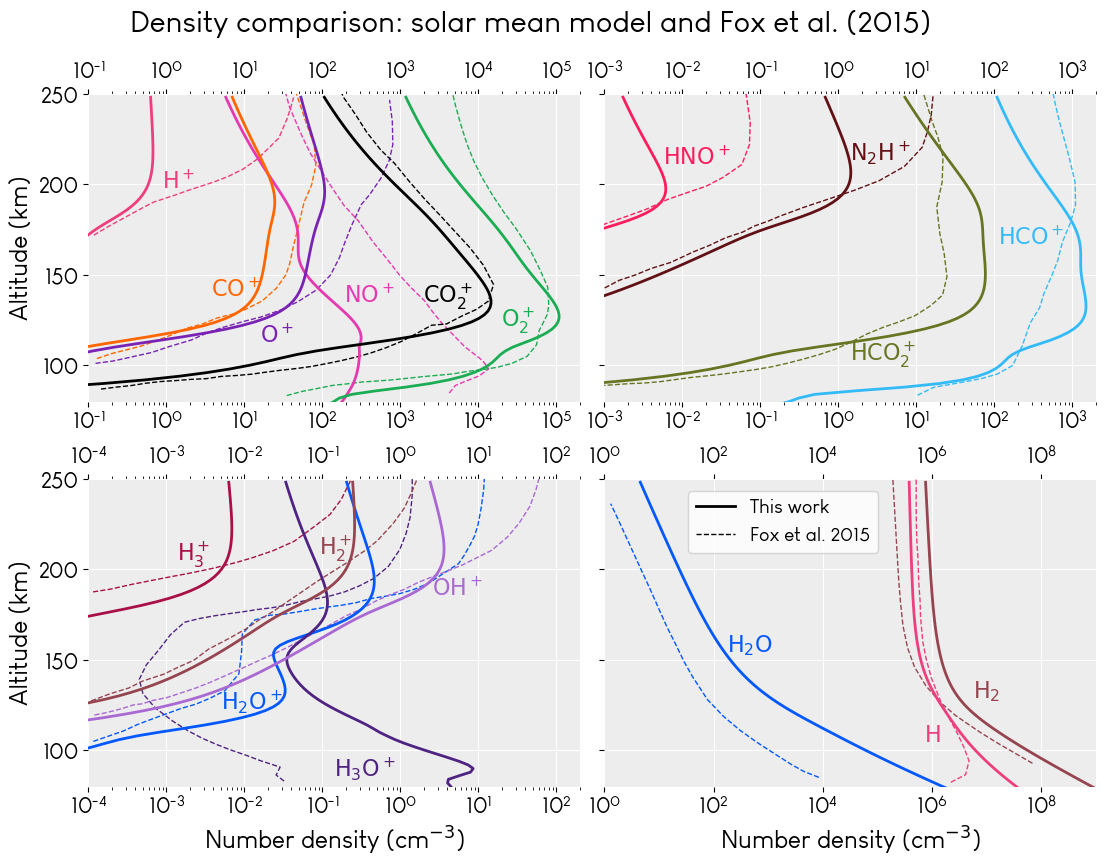

In [22]:
compare_with_fox(solarmean, [:CO2pl, :O2pl, :Opl, :HCOpl, :HCO2pl, :Hpl, :H2pl, :H3pl, :H2Opl, :H3Opl, :N2Hpl, :NOpl, :OHpl, :HNOpl, :COpl,
                            :H2O, :H, :H2], 
                            all_result_plot_folder, janefox_dat, axes_by_sp_fox; t="Density comparison: solar mean model and Fox et al. (2015)", 
                            fn="comp_fox2015b_smean", legax=[2,2], legloc=[0.17,0.76], h=0.25, w=0.05,
                            showonly=false, xlims=[(1e-1, 2e5) (1e-3, 2e3); (1e-4, 200) (1, 1e9)], figsz=(13,9), ylims=(80, 250),
                            spcpos=Dict(:CO2pl=>[0.68,0.39], :O2pl=>[0.84, 0.31], :Opl=>[0.35, 0.25], :HCOpl=>[0.8, 0.57], :HCO2pl=>[0.5, 0.2],
                                       :Hpl=>[0.15,0.75], :H2pl=>[0.47,0.82], :H3pl=>[0.18,0.8], :H2Opl=>[0.27,0.32], :H3Opl=>[0.5,0.1], 
                                       :N2Hpl=>[0.5,0.85], :NOpl=>[0.52,0.38], :OHpl=>[0.7,0.68], :HNOpl=>[0.12,0.83], :COpl=>[0.25,0.4],
                                       :H2O=>[0.25, 0.5], :H2=>[0.75,0.35], :H=>[0.65,0.2]),
                            plot_grid, speciescolor, speciesstyle, zmax)

### Fox 2021

In [29]:
# Jane fox 2021 model
header = ""
flag = false
current_sp = :Z
fox2021_dat = Dict()
fox2021_ngims_dat = Dict()

# read file contents, one line at a time
open("../Resources/DataFromPapers/Fox2021/fox2021_fig11_data.txt") do f
    global header = readline(f)

    # read till end of file
    while !eof(f) 
        # read a new / next line for every iteration          
        s = readline(f)
        if occursin(r"[A-Z]", string(s))
            global flag = true
            global current_sp = Symbol(s)
            fox2021_dat[Symbol(s)] = DataFrame(density=Float64[], alt=Float64[])
            continue
        elseif s==""
            global flag = false
        end
        
        if flag
            push!(fox2021_dat[current_sp], map(x->parse(Float64,x), split(s)))
        end
    end
end

open("../Resources/DataFromPapers/Fox2021/fox2021_ngims.dat") do f
    global header = readline(f)

    # read till end of file
    while !eof(f) 
        # read a new / next line for every iteration          
        s = readline(f)
        if occursin(r"[A-Z]", string(s))
            global flag = true
            global current_sp = Symbol(s)
            fox2021_ngims_dat[Symbol(s)] = DataFrame(density=Float64[], alt=Float64[])
            continue
        elseif s==""
            global flag = false
        end
        
        if flag
            push!(fox2021_ngims_dat[current_sp], map(x->parse(Float64,x), split(s)))
        end
    end
end

In [30]:
panel_groups_f21 = Dict([1,1]=>[:CO2pl, :O2pl, :Opl, :COpl, :NOpl],#, :N2pl],#, :Arpl], 
                        [1,2]=>[:HCOpl, :HCO2pl, :N2Hpl, :HOCpl, :OHpl],#, :ArHpl, :CHpl, :HNOpl, :NHpl],
                        [2,1]=>[:Hpl, :H2pl, :H3pl, :H2Opl, :H3Opl, :HO2pl],
                        [2,2]=>[:H, :H2, :OH, :H2O])
axes_by_sp_f21 = Dict()
for k in keys(panel_groups_f21)
    for sp in panel_groups_f21[k]
        axes_by_sp_f21[sp] = k
    end
end

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


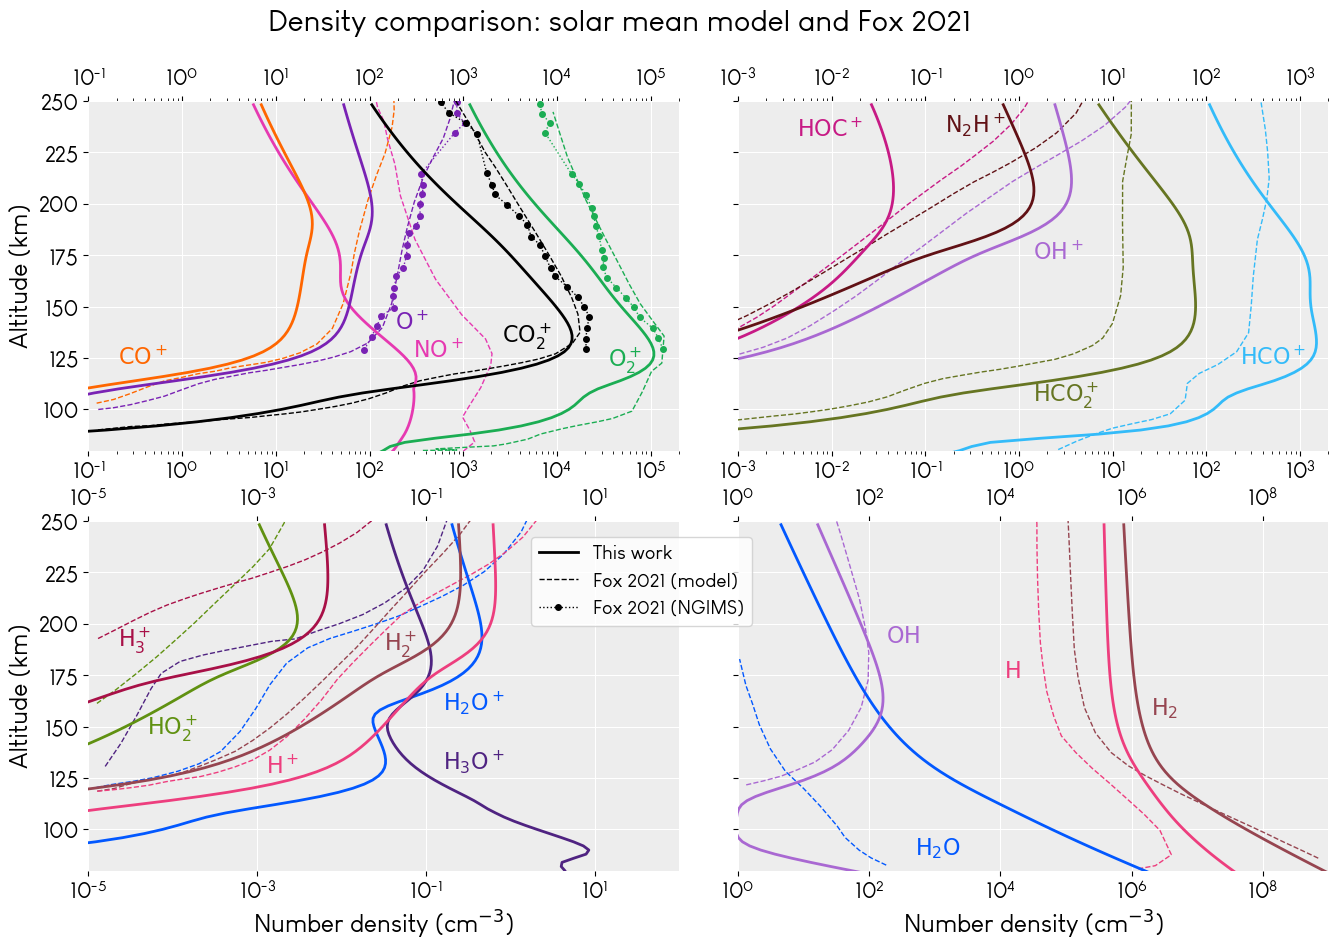

In [90]:
compare_with_fox(solarmean, keys(axes_by_sp_f21), all_result_plot_folder, fox2021_dat, axes_by_sp_f21; opt_comp_2=fox2021_ngims_dat,
                    t="Density comparison: solar mean model and Fox 2021", fn="comp_fox2021_smean", leglab="Fox 2021 (model)", optleglab="Fox 2021 (NGIMS)",
                    showonly=false,  figsz=(16,10), ylims=(80, 250), h=0.2, w=0.1, legax=[2,2], legloc=(-0.35, 0.7), 
                    spcpos=Dict(:CO2pl=>[0.7,0.37], :O2pl=>[0.88, 0.3], :Opl=>[0.52, 0.4], :COpl=>[0.05,0.3], :NOpl=>[0.55,0.32],
                                :HCOpl=>[0.85, 0.3], :HCO2pl=>[0.5, 0.2], :N2Hpl=>[0.35,0.97], :OHpl=>[0.5,0.6], :HOCpl=>[0.1, 0.95], 
                                   :Hpl=>[0.3,0.33], :H2pl=>[0.5,0.69], :H3pl=>[0.05,0.7], :H2Opl=>[0.6,0.52], :H3Opl=>[0.6,0.35], :HO2pl=>[0.1, 0.45],
                                    :H2=>[0.7, 0.5], :H=>[0.45, 0.6], :OH=>[0.25, 0.7], :H2O=>[0.3, 0.1]),
                    plot_grid, speciescolor, speciesstyle, zmax)

## Stone 2022 neutral data from NGIMS

In [32]:
function compare_neutrals(plot_me, spclist, savepath::String, comparison_data;
                                linetype="line", leglab="Fox 2015b", xlab=L"Number density [cm$^{-3}$]", t=nothing, showonly=false, fn="density",
                                xlims=[1e5, 1e14], figsz=(16,6), ylims=(0,zmax/1e5), 
                                spcpos=Dict(:O2pl=>[6e4, 110], :CO2pl=>[1.6e4, 130], :Opl=>[70, 130], :HCOpl=>[1.2e3, 150], :HCO2pl=>[2,225]), 
                                globvars...)
                                
    #=
    Makes a "spaghetti plot" of the species in spclist, in concentrations by altitude in the
    atmosphere. 

    plot_me: dictionary of vertical profiles of a plottable quantity, keys are species names.
    spclist: a list of species to plot.
    savepath: path and name for saving resulting .png file
    t: timestep, for plotting the atmosphere during convergence
    iter: iteration, for plotting the atmosphere during convergence
    showonly: whether to just show() the plot instead of saving. If setting to true, send in junk string for savepath.
    xlab: override for x axis label
    xlim_1: override for x axis limits in column 1 or entire plot of length(spclists)==1
    xlim_2: override for x axis limits in column 2
    =#
    
    
    GV = values(globvars)
    @assert all(x->x in keys(GV),  [:plot_grid, :speciescolor, :speciesstyle, :zmax])


    rcParams = PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 18
    rcParams["axes.labelsize"]= 20
    rcParams["xtick.labelsize"] = 18
    rcParams["ytick.labelsize"] = 18
    
    nrow = 1
    ncol = 1
    atm_fig, ax = subplots(figsize=figsz)
    
    # Title
    ax.set_title(t)
    
    # Apply settings to all axes
    plot_bg(ax)
    ax.tick_params(axis="x", which="both", labeltop=true, labelbottom=true, top=true)
    ax.set_ylim(ylims[1], ylims[2])
    ax.set_xscale("log")
    ax.set_xlabel(L"Number density (cm$^{-3}$)")
    ax.set_ylabel("Altitude [km]")
    
    # Plotting
    lw = 0
    ms = 0
    for sp in intersect(keys(comparison_data), spclist)
        
        col = GV.speciescolor[sp]
        ax.set_xlim(xlims[1], xlims[2])
        
        # Plotting
        ax.plot(plot_me[sp], GV.plot_grid, color=col, linewidth=2, label=sp, linestyle=get(GV.speciesstyle, sp, "-"), zorder=10)
        if linetype=="line"
            ax.plot(comparison_data[sp]."density", comparison_data[sp]."alt", color = GV.speciescolor[sp], linestyle="--")
            lw = 1
            ms = 0
        elseif linetype=="scatter"
            ax.scatter(comparison_data[sp]."density", comparison_data[sp]."alt", color = GV.speciescolor[sp], s=15, marker="o")
            lw = 0
            ms = 5
        end
        
        # Text labels
        splabel = string_to_latexstr(string(sp)) 
        ax.text(spcpos[sp]..., splabel, va="top", transform=ax.transAxes, color=GV.speciescolor[sp])
    end

    # Legend
    L2D = PyPlot.matplotlib.lines.Line2D
    lines = [L2D([0], [0], color="black", linewidth=1, linestyle="-"), 
             L2D([0], [0], color="black", linewidth=lw, linestyle="--", marker="o", markersize=ms)]
    labels = ["This work", leglab]
    ax.legend(lines, labels, borderaxespad=0, fontsize=16)

    if showonly==false  
        atm_fig.savefig(savepath*fn*".png", bbox_inches="tight", dpi=300)
    end
    show()
end

compare_neutrals (generic function with 1 method)

In [33]:
header = ""
flag = false
current_sp = :Z
stone_dat = Dict()

# read file contents, one line at a time
open("../Resources/DataFromPapers/NGIMS/Stone2022_NGIMS.txt") do f
    global header = readline(f)
    
    # line_number
    line = 1 
    # read till end of file
    while !eof(f) 
        # read a new / next line for every iteration          
        s = readline(f)
        if occursin(":", string(s))
            global flag = true
            global current_sp = Symbol(s[1:end-1])
            stone_dat[current_sp] = DataFrame(density=Float64[], alt=Float64[])
            continue
        elseif s==""
            global flag = false
        end
        
        if flag
            push!(stone_dat[current_sp], map(x->parse(Float64,x), split(s)))
        end
    end
end

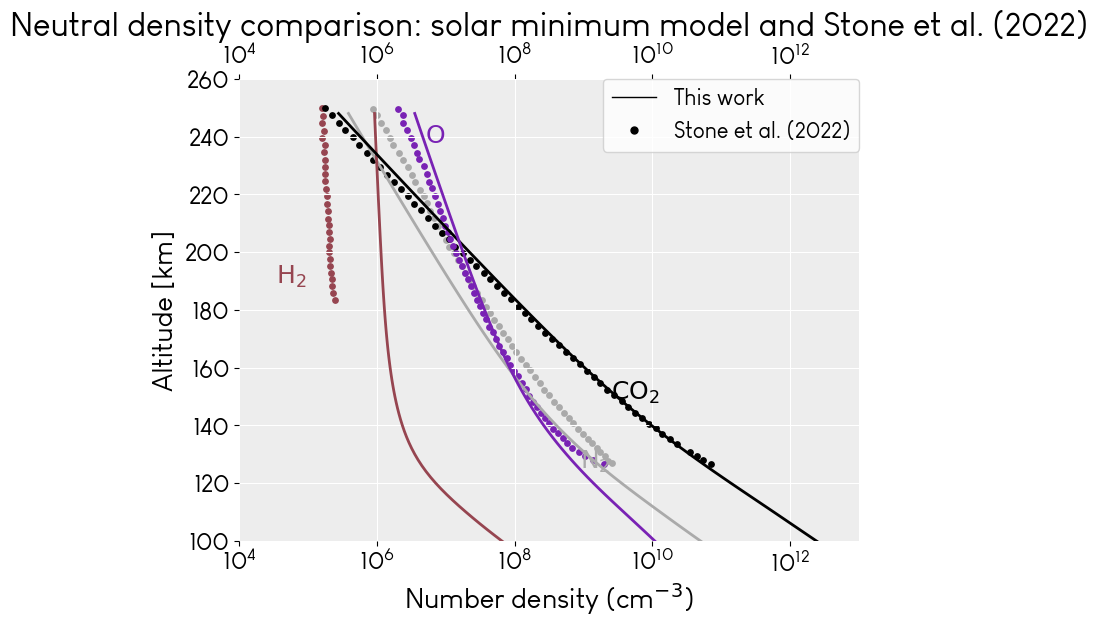

In [91]:
compare_neutrals(solarmin, [:CO2, :O, :H2, :N2], all_result_plot_folder, stone_dat; 
                            t="Neutral density comparison: solar minimum model and Stone et al. (2022)", 
                            leglab="Stone et al. (2022)", fn="comp_stone2022_smin",
                            linetype="scatter", showonly=false, xlims=[1e4, 1e13], figsz=(8,6), ylims=(100, 260),
                            spcpos=Dict(:CO2=>[0.6,0.35], :O=>[0.3, 0.9], :H2=>[0.06, 0.6], :N2=>[0.55, 0.2]),
                            plot_grid, speciescolor, speciesstyle, zmax)

# Compare densities with and without tenewitz rates

In [35]:
tenewitz_n = get_ncurrent("/home/emc/OneDrive-CU/Research/UpperAtmoDH/Results/DGearI+iNT_Sejwx8Gx_smean_v11/final_atmosphere.h5");


Not plotting NGIMS data for H2DOpl because there isn't any.
Not plotting NGIMS data for HDOpl because there isn't any.


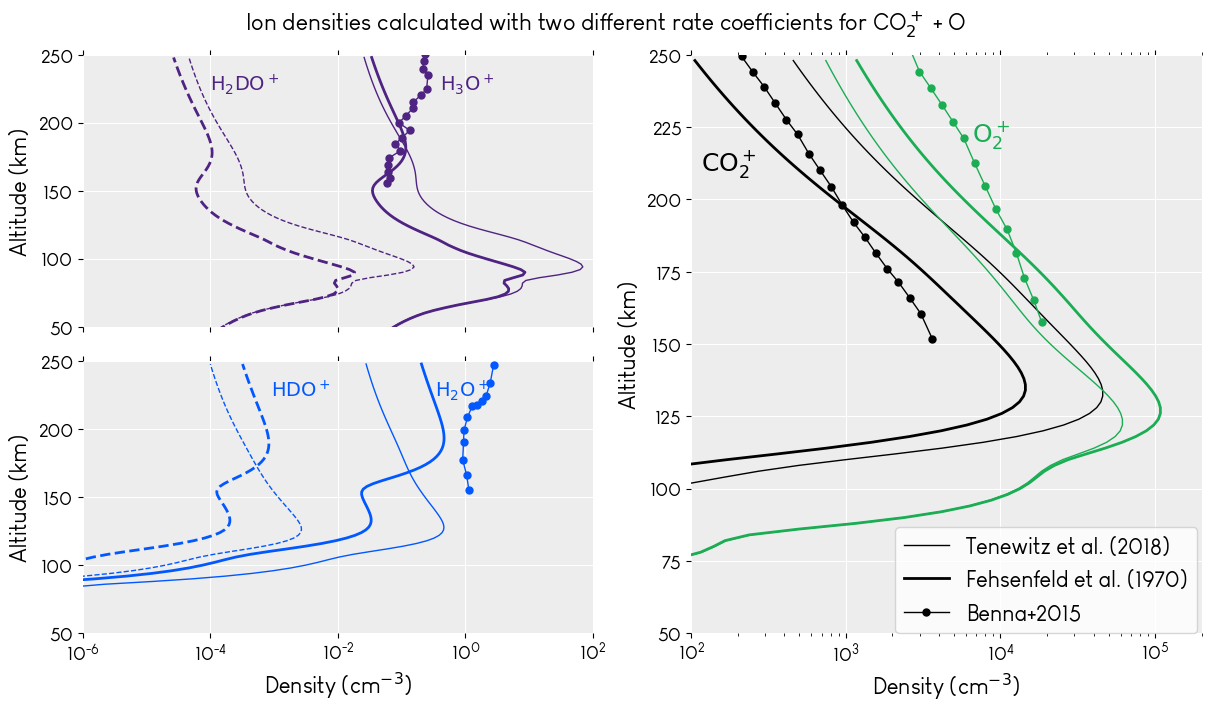

In [92]:
spc = [[:H3Opl, :H2DOpl], [:H2Opl, :HDOpl], [:CO2pl, :O2pl]]

rcParams = PyDict(matplotlib."rcParams")
rcParams["font.sans-serif"] = ["Louis George Caf?"]
rcParams["font.monospace"] = ["FreeMono"]
rcParams["font.size"] = 14
rcParams["axes.labelsize"]= 16
rcParams["xtick.labelsize"] = 14
rcParams["ytick.labelsize"] = 14
    

gridspec = matplotlib.gridspec

# Setup figure
fig = figure(constrained_layout=true, figsize=(12,7))
gs = gridspec.GridSpec(2, 2, figure=fig)
ax1 = subplot(gs.new_subplotspec((0, 0)))
ax2 = subplot(gs.new_subplotspec((1, 0)))
ax3 = subplot(gs.new_subplotspec((0, 1), rowspan=2))

axs = [ax1, ax2, ax3]

for a in axs
    plot_bg(a)
    a.set_ylim(50, 250)
    a.set_xscale("log")
    a.set_ylabel("Altitude (km)")
    a.set_xlim(1e-6, 1e2)
    a.tick_params(which="both", axis="x", top=true, labelbottom=false)
end

ax3.set_xlim(1e2, 2e5)

for a in axs[2:end]
    a.tick_params(labelbottom=true)
    a.set_xlabel(L"Density (cm$^{-3}$)")
end

L2D = PyPlot.matplotlib.lines.Line2D

for set in 1:length(spc)
    for s in spc[set]
        axs[set].plot(solarmean[s], plot_grid, label="$(string_to_latexstr(string(s)))", color=speciescolor[s], linestyle=get(speciesstyle, s, "-"), linewidth=2)
        axs[set].plot(tenewitz_n[s], plot_grid, color=speciescolor[s], linestyle=get(speciesstyle, s, "-"), linewidth=1)
        
        try
            axs[set].plot(NGIMS_dat[s]."density", NGIMS_dat[s]."alt",  "o-", color=speciescolor[s], ms=5)
        catch
            println("Not plotting NGIMS data for $(s) because there isn't any.")
        end
        
    end
end

ax1.text(0.7, 0.87, string_to_latexstr("H3Opl"), color=speciescolor[:H3Opl], fontsize=14, transform=ax1.transAxes)
ax1.text(0.25, 0.87, string_to_latexstr("H2DOpl"), color=speciescolor[:H2DOpl], fontsize=14, transform=ax1.transAxes)

ax2.text(0.69, 0.87, string_to_latexstr("H2Opl"), color=speciescolor[:H2Opl], fontsize=14, transform=ax2.transAxes)
ax2.text(0.37, 0.87, string_to_latexstr("HDOpl"), color=speciescolor[:HDOpl], fontsize=14, transform=ax2.transAxes)

ax3.text(0.02, 0.8, string_to_latexstr("CO2pl"), color=speciescolor[:CO2pl], fontsize=18, transform=ax3.transAxes)
ax3.text(0.55, 0.85, string_to_latexstr("O2pl"), color=speciescolor[:O2pl], fontsize=18, transform=ax3.transAxes)

ax3.legend([L2D([0], [0], color="black", linewidth=1), L2D([0], [0], color="black", linewidth=2),
            L2D([0], [0], color="black", linestyle="-", marker="o", markersize=5)], ["Tenewitz et al. (2018)", "Fehsenfeld et al. (1970)", "Benna+2015"],
           loc=(0.4, 0), fontsize=16)

suptitle(L"Ion densities calculated with two different rate coefficients for CO$_2^+$ + O")
savefig(all_result_plot_folder*"I_agree_with_Jane.png", dpi=300)
show()


# D ion densities

In [23]:
function plot_ion_ranges_wide_2panel(ions_to_plot, simfolder_smin, simfolder_smean, simfolder_smax, savepath;
                          comparison_ions=[:CO2pl, :O2pl, :Opl], showonly=false, extra_fn="", xL = [1e-3 1e-6; 2e5 1e0],
                          posdict = Dict(:ArDpl => [8e-7, 190], :Dpl => [3e-3, 260], :DCOpl => [0.7, 175], :DOCpl => [2e-5, 260], :DCO2pl => [1.5e-2, 150], 
                                         :HDOpl => [2e-4, 260], :H2DOpl => [1e-3, 100], :HDpl => [1e-6, 150], 
                                         :H2Dpl => [2e-6, 260], :N2Dpl => [3e-4, 145], :ODpl => [6e-3, 240],
                                         :ArHpl => [3e-6, 210], :Hpl => [1.7e-4, 220], :HCOpl => [9e-2, 175], :HOCpl => [1.5e-5, 230], :HCO2pl => [1.5e-3, 150],
                                         :H2Opl => [1e-3, 175], :H3Opl => [1.7e-5, 235], :H2pl => [8e-4, 235], 
                                         :H3pl => [3e-6, 240], :N2Hpl => [1e-3, 165], :OHpl => [6e-4, 210],
                                         :CO2pl => [1e3, 130], :O2pl => [2e3, 240], :Opl => [15, 135],))


    rcParams = PyCall.PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 16
    rcParams["axes.titlesize"] = 18
    rcParams["axes.labelsize"]= 16
    rcParams["xtick.labelsize"] = 16
    rcParams["ytick.labelsize"] = 16
    rcParams["lines.linewidth"] = 1
    
    # Load the 3 atmospheres
    ncur_smin = get_ncurrent(simfolder_smin*"final_atmosphere.h5")
    ncur_smean = get_ncurrent(simfolder_smean*"final_atmosphere.h5")
    ncur_smax = get_ncurrent(simfolder_smax*"final_atmosphere.h5")
    
    # set up the overall plot -------------------------------------------------------------
    ncol = 1
    nrow = 2
    fig, ax = subplots(nrow, ncol, figsize=(16,10), gridspec_kw=Dict("height_ratios"=>[1,1], "hspace"=>0.06))
    ax[1].set_title("Density ranges between solar minimum and maximum")
    ax[nrow].set_xlabel(L"Number density (cm$^{-3}$)")
    
    for a in ax
        plot_bg(a)
        a.tick_params(which="both", labeltop=false, top=true, labelbottom=false, bottom=true, labelleft=true)
        a.set_ylim(80, zmax/1e5)
        a.set_yticks(100:50:zmax/1e5)
        a.set_xscale("log")
        a.set_xlim(xL[1], xL[2])
        a.set_ylabel("Altitude (km)")
    end
    
    # Set the right limit to 2e5 for just the solar mean plot with D ions since we need to show the comparisons
    ax[1].set_xlim(right=2e5)
    ax[2].set_xlim(right=2e5)
    
    # These have to go here to override the previous setting
    ax[1].tick_params(which="both", labeltop=true)
    ax[nrow].tick_params(which="both", labelbottom=true)
    
    # plot the ions according to logical groups ------------------------------------------------------------
    lineorder = Dict([i=>4 for i in comparison_ions])

    for ion in ions_to_plot
        row = occursin("D", string(ion)) ? 2 : 1  # set column based on ion

        # style things
        thiscolor = get(speciescolor, ion, dimcolor)
        this_zorder = 10

        # Axes showing range of values
        ax[row].plot(ncur_smin[ion][40:end], plot_grid[40:end], color=thiscolor,
                          linewidth=1, label=ion, zorder=this_zorder)
        ax[row].plot(ncur_smax[ion][40:end], plot_grid[40:end], color=thiscolor,
                          linewidth=3, label=ion, zorder=this_zorder)
        ax[row].fill_betweenx(plot_grid[40:end], ncur_smin[ion][40:end], x2=ncur_smax[ion][40:end], color=thiscolor, alpha=0.25, zorder=this_zorder)
        ax[row].text(posdict[ion]..., string_to_latexstr(string(ion)), color=thiscolor, va="top")
    end

    # Plot comparison ions
    for comp_ion in comparison_ions
        for i in 1:nrow
            if i < 3
                position = posdict[comp_ion]
            else 
                position = posdict[comp_ion]
            end
            
            ax[i].plot(ncur_smin[comp_ion][40:end], plot_grid[40:end], color=dimcolor,
                          linewidth=1, label=comp_ion, zorder=get(lineorder, comp_ion, 10))
            ax[i].plot(ncur_smax[comp_ion][40:end], plot_grid[40:end], color=dimcolor,
                              linewidth=3, label=comp_ion, zorder=get(lineorder, comp_ion, 10))
            ax[i].fill_betweenx(plot_grid[40:end], ncur_smin[comp_ion][40:end], x2=ncur_smax[comp_ion][40:end], color=dimcolor, alpha=0.25, zorder=zorder=get(lineorder, comp_ion, 10))
        
            ax[i].text(position..., string_to_latexstr(string(comp_ion)), color=get(speciescolor_forDions, comp_ion, dimcolor), va="top", zorder=15)
        end
    end
    
    L2D = PyPlot.matplotlib.lines.Line2D
    legend_elements = [L2D([0], [0], color="black", linewidth=1, label="Solar minimum"),
                        L2D([0], [0], color="black", linewidth=3, label="Solar maximum")]
    ax[1].legend(handles=legend_elements, loc="upper left", fontsize=16)
    
    # Indicate H and D species
    fs = 34
    ax[1].text(0.9, 0.9, "H ions", color="#696969", fontsize=fs, va="top", transform=ax[1].transAxes)
    ax[2].text(0.9, 0.9, "D ions", color="#696969", fontsize=fs, va="top", transform=ax[2].transAxes)
    
    # Show and save
    if showonly==false
        savefig(savepath*"H_and_D_ions$(extra_fn)_wide.pdf", format="pdf", bbox_inches="tight", dpi=300)
    end
    show()
end


plot_ion_ranges_wide_2panel (generic function with 1 method)

In [24]:
ions_to_plot = [:HDpl, :H2Dpl, :H2DOpl, :HDOpl, :Dpl, :DCO2pl, :DCOpl, :DOCpl, :ArDpl, :N2Dpl, :ODpl,
                :H2pl, :H3pl,  :H3Opl,  :H2Opl, :Hpl, :HCO2pl, :HCOpl, :HOCpl, :ArHpl, :N2Hpl, :OHpl]#, :NOpl]
panel_groups = Dict(1=>[:H2Dpl, :H3pl,  :HDOpl, :H2Opl, :Dpl, :Hpl, :H2DOpl, :H3Opl, :ODpl, :OHpl,  ], 
                    2=>[:ArDpl, :ArHpl, :N2Dpl, :N2Hpl, :DOCpl, :DCOpl, :HCOpl,  :DCO2pl, :HCO2pl, :HOCpl, :H2pl, :HDpl, :NOpl])
axes_by_sp = Dict()
for k in keys(panel_groups)
    for sp in panel_groups[k]
        axes_by_sp[sp] = k
    end
end

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


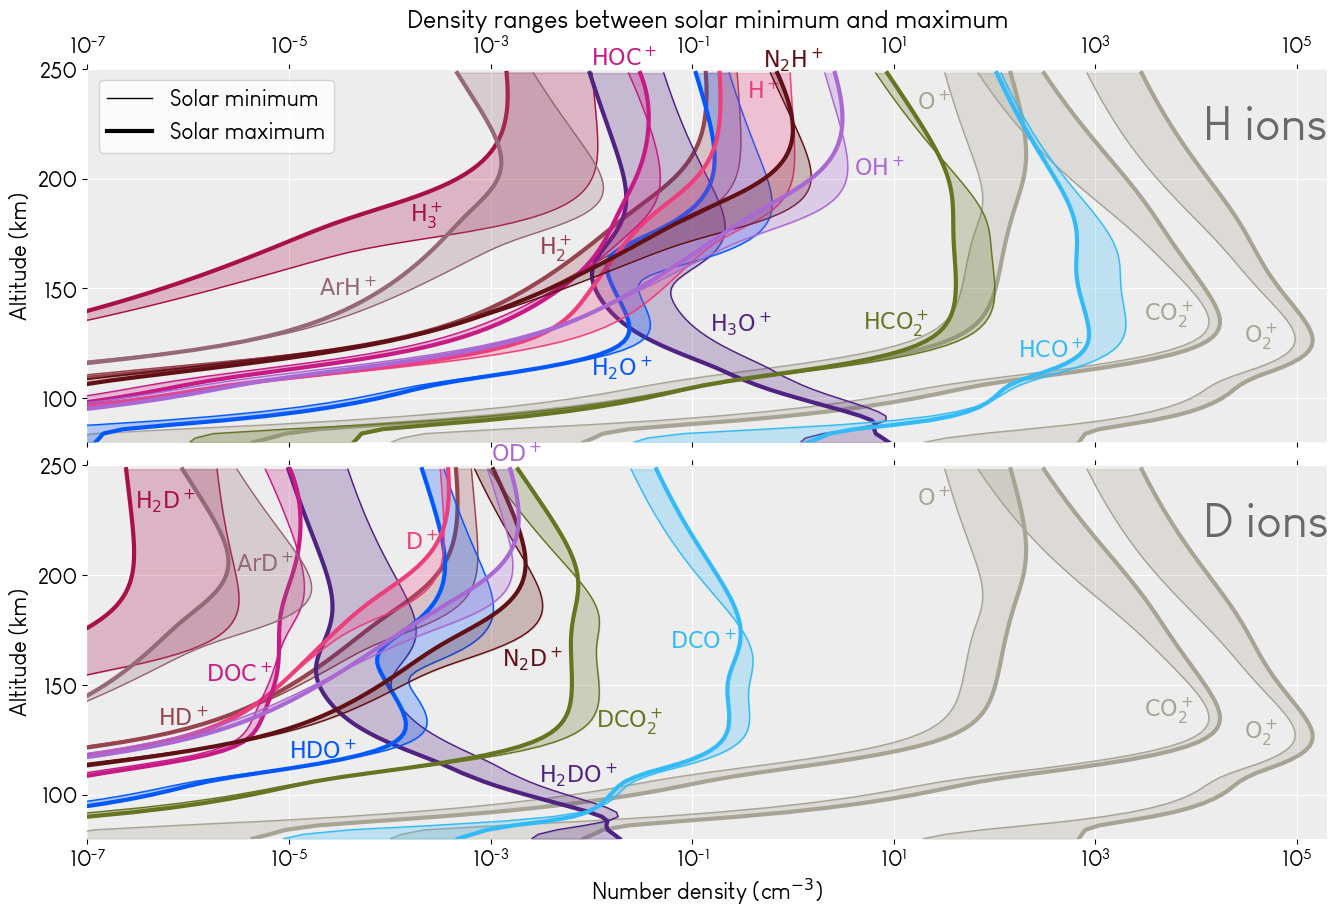

In [31]:
plot_ion_ranges_wide_2panel(ions_to_plot, solarmin_folder, solarmean_folder, solarmax_folder, all_result_plot_folder; extra_fn="_densities", 
                 xL = [1e-7; 2e5],    
                 posdict = Dict(:ArDpl => [3e-6, 210], :Dpl => [1.4e-4, 220], :DCOpl => [6e-2, 175], :DOCpl => [1.5e-6, 160], :DCO2pl => [1.1e-2, 140],
                                 :HDOpl => [1e-5, 125], :H2DOpl => [3e-3, 115], :HDpl => [5e-7, 140], 
                                 :H2Dpl => [3e-7, 240], :N2Dpl => [1.3e-3, 168], :ODpl => [1e-3, 260],
                                 
                                 :ArHpl => [2e-5, 155], :Hpl => [3.5e-1, 245], :HCOpl=>[1.7e2,127], :HOCpl => [1e-2, 260], :HCO2pl => [5, 141],
                                 :H2Opl => [1e-2, 120], :H3Opl => [0.15, 140], :H2pl => [3e-3, 175], 
                                 :H3pl => [1.6e-4, 190], :N2Hpl => [5e-1, 260], :OHpl => [4, 210],
                                 :CO2pl=>[3e3,145], :O2pl=>[3e4, 135], :Opl=>[17,240]) )

# Non-thermal escape

In [32]:
rcParams = PyCall.PyDict(matplotlib."rcParams")
rcParams["font.sans-serif"] = ["Louis George Caf?"]
rcParams["font.monospace"] = ["FreeMono"]
rcParams["font.size"] = 18
rcParams["axes.labelsize"]= 20
rcParams["xtick.labelsize"] = 18
rcParams["ytick.labelsize"] = 18;

In [33]:
# LOad the reaction network for hot stuff cause we need that
reaction_network, hot_H_network, hot_D_network, hot_H2_network, hot_HD_network = load_reaction_network("REACTION_NETWORK.xlsx"; get_hot_rxns=true, all_species);
const hot_H_rc_funcs = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hot_H_network]);
const hot_D_rc_funcs = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hot_D_network]);
const hot_H2_rc_funcs = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hot_H2_network]);
const hot_HD_rc_funcs = Dict([rxn => mk_function(:((Tn, Ti, Te, M) -> $(rxn[3]))) for rxn in hot_HD_network]);

## Fluxes with final_escape

In [38]:
escdf_solarmin = final_escape(solarmin_folder, "final_atmosphere.h5"; alt, all_species, dz, hHnet=hot_H_network, hDnet=hot_D_network, hH2net=hot_H2_network, hHDnet=hot_HD_network, 
                                                      hHrc=hot_H_rc_funcs, hDrc=hot_D_rc_funcs, hH2rc=hot_H2_rc_funcs, hHDrc=hot_HD_rc_funcs)
escdf_solarmean = final_escape(solarmean_folder, "final_atmosphere.h5"; alt, all_species, dz, hHnet=hot_H_network, hDnet=hot_D_network, hH2net=hot_H2_network, hHDnet=hot_HD_network, 
                                                      hHrc=hot_H_rc_funcs, hDrc=hot_D_rc_funcs, hH2rc=hot_H2_rc_funcs, hHDrc=hot_HD_rc_funcs)
escdf_solarmax = final_escape(solarmax_folder, "final_atmosphere.h5"; alt, all_species, dz, hHnet=hot_H_network, hDnet=hot_D_network, hH2net=hot_H2_network, hHDnet=hot_HD_network, 
                                                      hHrc=hot_H_rc_funcs, hDrc=hot_D_rc_funcs, hH2rc=hot_H2_rc_funcs, hHDrc=hot_HD_rc_funcs)

3×8 DataFrame
 Row │ EscapeType  H          D         H2            HD         TotalHAtomsLo ⋯
     │ String      Float64    Float64   Float64       Float64    Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Thermal     1.77877e8   5414.78     8.9162e6   103.821          1.95709 ⋯
   2 │ Nonthermal  4.42653e7   9040.89  5473.29         4.29807        4.42762
   3 │ Total       2.22142e8  14455.7      8.92167e6  108.119          2.39985
                                                               3 columns omitted

In [39]:
show(escdf_solarmin, allcols=true)

3×8 DataFrame
 Row │ EscapeType  H          D          H2              HD       TotalHAtomsLost  TotalDAtomsLost  TotalHnDAtomsLost 
     │ String      Float64    Float64    Float64         Float64  Float64          Float64          Float64           
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Thermal     1.70439e8    62.1231       1.66489e5  0.1294         1.70772e8          62.2525          1.70772e8
   2 │ Nonthermal  6.91947e7  9225.67     11871.8        7.36552        6.92184e7        9233.03            6.92276e7
   3 │ Total       2.39634e8  9287.79    178361.0        7.49492        2.39991e8        9295.29            2.4e8

In [40]:
show(escdf_solarmean, allcols=true)

3×8 DataFrame
 Row │ EscapeType  H          D         H2            HD        TotalHAtomsLost  TotalDAtomsLost  TotalHnDAtomsLost 
     │ String      Float64    Float64   Float64       Float64   Float64          Float64          Float64           
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Thermal     1.78718e8   242.837     5.43327e5  0.931173        1.79805e8          243.768          1.79805e8
   2 │ Nonthermal  6.0167e7   9154.85   9491.43       6.73529         6.0186e7          9161.58           6.01952e7
   3 │ Total       2.38885e8  9397.68      5.52819e5  7.66646         2.39991e8         9405.35           2.4e8

3×8 DataFrame
 Row │ EscapeType  H          D         H2            HD         TotalHAtomsLost  TotalDAtomsLost  TotalHnDAtomsLost 
     │ String      Float64    Float64   Float64       Float64    Float64          Float64          Float64           
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Thermal     1.77877e8   5414.78     8.9162e6   103.821          1.95709e8          5518.6           1.95715e8
   2 │ Nonthermal  4.42653e7   9040.89  5473.29         4.29807        4.42762e7          9045.18          4.42853e7
   3 │ Total       2.22142e8  14455.7      8.92167e6  108.119          2.39985e8         14563.8           2.4e8

## Nonthermal fluxes in a pretty table

In [98]:
all_solar_escdf = DataFrame("Solar conditions"=>["Solar min", "Solar mean", "Solar max"], 
                  "H thermal"=>[df_lookup(x, "EscapeType", "Thermal", "H")[1] for x in [escdf_solarmin, escdf_solarmean, escdf_solarmax]], 
                  "H nonthermal"=>[df_lookup(x, "EscapeType", "Nonthermal", "H")[1] for x in [escdf_solarmin, escdf_solarmean, escdf_solarmax]],
                  "H2 thermal"=>[df_lookup(x, "EscapeType", "Thermal", "H2")[1] for x in [escdf_solarmin, escdf_solarmean, escdf_solarmax]],
                  "H2 nonthermal"=>[df_lookup(x, "EscapeType", "Nonthermal", "H")[1] for x in [escdf_solarmin, escdf_solarmean, escdf_solarmax]], 
                  "D thermal"=>[df_lookup(x, "EscapeType", "Thermal", "D")[1] for x in [escdf_solarmin, escdf_solarmean, escdf_solarmax]],
                  "D nonthermal"=>[df_lookup(x, "EscapeType", "Nonthermal", "D")[1] for x in [escdf_solarmin, escdf_solarmean, escdf_solarmax]], 
                  "HD thermal"=>[df_lookup(x, "EscapeType", "Thermal", "HD")[1] for x in [escdf_solarmin, escdf_solarmean, escdf_solarmax]],
                  "HD nonthermal"=>[df_lookup(x, "EscapeType", "Nonthermal", "HD")[1] for x in [escdf_solarmin, escdf_solarmean, escdf_solarmax]],
                  "H total"=>[df_lookup(x, "EscapeType", "Total", "TotalHAtomsLost")[1] for x in [escdf_solarmin, escdf_solarmean, escdf_solarmax]],
                  "D total"=>[df_lookup(x, "EscapeType", "Total", "TotalDAtomsLost")[1] for x in [escdf_solarmin, escdf_solarmean, escdf_solarmax]]
                )

show(all_solar_escdf, allcols=true)

3×11 DataFrame
 Row │ Solar conditions  H thermal  H nonthermal  H2 thermal  H2 nonthermal  D thermal  D nonthermal  HD thermal  HD nonthermal  H total    D total  
     │ String            Float64    Float64       Float64     Float64        Float64    Float64       Float64     Float64        Float64    Float64  
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Solar min         1.70439e8     6.91947e7   1.66489e5      6.91947e7    62.1231       9225.67    0.1294          7.36552  2.39991e8   9295.29
   2 │ Solar mean        1.78718e8     6.0167e7    5.43327e5      6.0167e7    242.837        9154.85    0.931173        6.73529  2.39991e8   9405.35
   3 │ Solar max         1.77877e8     4.42653e7   8.9162e6       4.42653e7  5414.78         9040.89  103.821           4.29807  2.39985e8  14563.8

In [99]:
escdf_percents = deepcopy(all_solar_escdf)

escdf_percents."H thermal" .= all_solar_escdf."H thermal" ./ all_solar_escdf."H total"
escdf_percents."H nonthermal" .= all_solar_escdf."H nonthermal" ./ all_solar_escdf."H total"

escdf_percents."D thermal" .= all_solar_escdf."D thermal" ./ all_solar_escdf."D total"
escdf_percents."D nonthermal" .= all_solar_escdf."D nonthermal" ./ all_solar_escdf."D total"

escdf_percents."H2 thermal" .= 2 * all_solar_escdf."H2 thermal" ./ all_solar_escdf."H total"
escdf_percents."H2 nonthermal" .= 2 * all_solar_escdf."H2 nonthermal" ./ all_solar_escdf."H total"

escdf_percents."HD thermal" .= all_solar_escdf."HD thermal" ./ all_solar_escdf."D total"
escdf_percents."HD nonthermal" .= all_solar_escdf."HD nonthermal" ./ all_solar_escdf."D total"

escdf_percents."H total" .= all_solar_escdf."H total" ./ (all_solar_escdf."H total" + all_solar_escdf."D total")
escdf_percents."D total" .= all_solar_escdf."D total" ./ (all_solar_escdf."H total" + all_solar_escdf."D total")

show(escdf_percents, allcols=true)

3×11 DataFrame
 Row │ Solar conditions  H thermal  H nonthermal  H2 thermal  H2 nonthermal  D thermal   D nonthermal  HD thermal  HD nonthermal  H total   D total    
     │ String            Float64    Float64       Float64     Float64        Float64     Float64       Float64     Float64        Float64   Float64    
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Solar min          0.710191      0.288322  0.00138746       0.576644  0.00668329      0.99251   1.3921e-5     0.000792393  0.999961  3.87304e-5
   2 │ Solar mean         0.744687      0.250706  0.0045279        0.501412  0.025819        0.973366  9.90046e-5    0.000716112  0.999961  3.9189e-5
   3 │ Solar max          0.741198      0.18445   0.0743061        0.3689    0.371797        0.620779  0.00712871    0.000295121  0.999939  6.06824e-5

In [100]:
molec_esc_pcts = deepcopy(all_solar_escdf)

molec_esc_pcts."H thermal" .= 0
molec_esc_pcts."H nonthermal" .= 0

molec_esc_pcts."D thermal" .= 0
molec_esc_pcts."D nonthermal" .= 0

molec_esc_pcts."H total" .= 0
molec_esc_pcts."D total" .= 0

molec_esc_pcts."H2 thermal" .= all_solar_escdf."H2 thermal" ./ (all_solar_escdf."H2 thermal" .+ all_solar_escdf."H2 nonthermal")
molec_esc_pcts."H2 nonthermal" .= all_solar_escdf."H2 nonthermal" ./ (all_solar_escdf."H2 thermal" .+ all_solar_escdf."H2 nonthermal")

molec_esc_pcts."HD thermal" .= all_solar_escdf."HD thermal" ./ (all_solar_escdf."HD thermal" .+ all_solar_escdf."HD nonthermal")
molec_esc_pcts."HD nonthermal" .= all_solar_escdf."HD nonthermal" ./ (all_solar_escdf."HD thermal" .+ all_solar_escdf."HD nonthermal")

println(molec_esc_pcts)

3×11 DataFrame
 Row │ Solar conditions  H thermal  H nonthermal  H2 thermal  H2 nonthermal  D thermal  D nonthermal  HD thermal  HD nonthermal  H total  D total 
     │ String            Float64    Float64       Float64     Float64        Float64    Float64       Float64     Float64        Float64  Float64 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Solar min               0.0           0.0  0.00240032       0.9976          0.0           0.0    0.017265      0.982735       0.0      0.0
   2 │ Solar mean              0.0           0.0  0.00894949       0.991051        0.0           0.0    0.121461      0.878539       0.0      0.0
   3 │ Solar max               0.0           0.0  0.167656         0.832344        0.0           0.0    0.960247      0.0397532      0.0      0.0


## Pie chart improved

In [46]:
@kwdef mutable struct PieSlice
    values::Vector
    text::String
    fontsize::Int64
    fontweight::String
    dx::Float64
    dy::Float64
    pct_dx::Float64
    pct_dy::Float64
    color::String
    ha::String
end

PieSlice

### molecular pie chart

In [74]:
function escape_type_pie_improved_molec(df, df_pcts, savepath, colors; imgname="escape_pie.png", dominant_bottom=[true,false], ccw=false)

    rcParams = PyCall.PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 20
    rcParams["axes.titlesize"] = 26
    rcParams["axes.labelsize"]= 24
    rcParams["xtick.labelsize"] = 24
    rcParams["ytick.labelsize"] = 24
    
    n_rows = nrow(df)
    fig, ax = subplots(n_rows, 2, sharex=true, figsize=(12, 15))
    subplots_adjust(hspace=0.01, wspace=0.02)
    
    # Label the solar cases
    ax[1, 1].text(0.85, 1.2, df."Solar conditions"[1]*"imum", size=24)
    ax[2, 1].text(1.1, 1.2, df."Solar conditions"[2], size=24)
    ax[3, 1].text(0.85, 1.2, df."Solar conditions"[3]*"imum", size=24)
    
    # Establish the color order for the piecharts    
    wedge_color_order = [colors["t"], colors["nt"]]
    
    # Wedge text label settings
    major_wedge = PieSlice(values=[0.], text="x", fontsize=22, fontweight="bold", dx=0, dy=0.3, pct_dx=0, pct_dy=0.5, color="white", ha="center")
    medium_wedge = PieSlice(values=[0.], text="x", fontsize=18, fontweight="normal", dx=0.95, dy=0.2, pct_dx=0.95, pct_dy=0.05, color="white", ha="right")
    tiny_wedge = PieSlice(values=[0.], text="x", fontsize=16, fontweight="normal", dx=1.1, dy=0.2, pct_dx=1.1, pct_dy=0.05, color=colors["nt"], ha="left")
    
    # H-species escape pie charts --------------------------------------------------------------
    ax[1, 1].set_title(L"H$_2$ escape", y=1.1)
    # The data
    slices_Hspc = [[df[1, "H2 thermal"], df[1, "H2 nonthermal"]],
                   [df[2, "H2 thermal"], df[2, "H2 nonthermal"]],
                   [df[3, "H2 thermal"], df[3, "H2 nonthermal"]]]

    pcts_Hspc = 100 .* [df_pcts[1, "H2 thermal"] df_pcts[1, "H2 nonthermal"];
                        df_pcts[2, "H2 thermal"] df_pcts[2, "H2 nonthermal"];
                        df_pcts[3, "H2 thermal"] df_pcts[3, "H2 nonthermal"]]
    
    # Modify the values, labels, and a few other things for H
    q = dominant_bottom[1] == true ? -1 : 1
    
    major_wedge_H = deepcopy(major_wedge)
    medium_wedge_H = deepcopy(medium_wedge)
    tiny_wedge_H = deepcopy(tiny_wedge)

    major_wedge_H.text = "Thermal"
    major_wedge_H.values = pcts_Hspc[:, 1]
    major_wedge_H.dy *= q
    major_wedge_H.pct_dy *= q
    
    medium_wedge_H.text = "Non-thermal"
    medium_wedge_H.values = pcts_Hspc[:, 2]
    medium_wedge_H.color = colors["fade_text_nt"]

    for i in 1:n_rows
        # Plot the pie chart            
        ax[i, 1].pie(slices_Hspc[i], colors=wedge_color_order, counterclock=ccw, radius=1.1)

        # Add major wedge labels
        ax[i, 1].text(major_wedge_H.dx, major_wedge_H.dy, major_wedge_H.text, fontsize=major_wedge_H.fontsize, fontweight=major_wedge_H.fontweight,
                      color=major_wedge_H.color, ha=major_wedge_H.ha)
        ax[i, 1].text(major_wedge_H.pct_dx, major_wedge_H.pct_dy, "$(round(major_wedge_H.values[i], digits=1))%", 
                      fontsize=major_wedge_H.fontsize, fontweight=major_wedge_H.fontweight, color=major_wedge_H.color, ha=major_wedge_H.ha)
            
        # Add medium wedge labels
        if i == 1
            ax[i, 1].text(medium_wedge_H.dx, medium_wedge_H.dy, medium_wedge_H.text, fontsize=medium_wedge_H.fontsize, 
                          color=medium_wedge_H.color, ha=medium_wedge_H.ha)
            ax[i, 1].text(medium_wedge_H.pct_dx, medium_wedge_H.pct_dy, "$(round(medium_wedge_H.values[i], digits=1))%", 
                          fontsize=medium_wedge_H.fontsize, color=medium_wedge_H.color, ha=medium_wedge_H.ha)
        else
            tiny_wedge_H.text = medium_wedge_H.text
            tiny_wedge_H.values = medium_wedge_H.values
            tiny_wedge_H.color = colors["nt"]
            
            r = 0# i==2 ? 12 : 1
    
            ax[i, 1].text(tiny_wedge_H.dx, tiny_wedge_H.dy, tiny_wedge_H.text, fontsize=tiny_wedge_H.fontsize, 
                          color=tiny_wedge_H.color, ha=tiny_wedge_H.ha, rotation=r)
            ax[i, 1].text(tiny_wedge_H.pct_dx, tiny_wedge_H.pct_dy, "$(round(tiny_wedge_H.values[i], digits=1))%", 
                          fontsize=tiny_wedge_H.fontsize, color=tiny_wedge_H.color, ha=tiny_wedge_H.ha, rotation=r)
        end
    end
    
    # HD escape --------------------------------------------------------------------------
    ax[1, 2].set_title("HD escape", y=1.1)
    slice_Dspc = [[df[1, "HD thermal"], df[1, "HD nonthermal"]],
                  [df[2, "HD thermal"], df[2, "HD nonthermal"]],
                  [df[3, "HD thermal"], df[3, "HD nonthermal"]]]

    pcts_Dspc = 100 .* [df_pcts[1, "HD thermal"] df_pcts[1, "HD nonthermal"];
                        df_pcts[2, "HD thermal"] df_pcts[2, "HD nonthermal"];
                        df_pcts[3, "HD thermal"] df_pcts[3, "HD nonthermal"]]

    q = dominant_bottom[2] == true ? -1 : 1
    
    # Modify the values, labels, and a few other things for HD
    major_wedge_D = deepcopy(major_wedge)
    medium_wedge_D = deepcopy(medium_wedge)
    tiny_wedge_D = deepcopy(tiny_wedge)

    major_wedge_D.text = "Non-thermal"
    major_wedge_D.values = pcts_Dspc[:, 2]
    major_wedge_D.dy = q * major_wedge.pct_dy
    major_wedge_D.pct_dy = q * major_wedge.dy
    
    # Only used for 3rd panel
    medium_wedge_D.text = "Thermal"
    medium_wedge_D.values = pcts_Dspc[:, 1]
    medium_wedge_D.color = colors["fade_text_t"]
    
    for i in 1:n_rows
        # Plot the pie chart
        ax[i, 2].pie(slice_Dspc[i], colors=wedge_color_order, startangle=180, radius=1.1)

        if i < 3 # for the first two axes,
            # Add major wedge labels
            ax[i, 2].text(major_wedge_D.dx, major_wedge_D.dy, major_wedge_D.text, fontsize=major_wedge_D.fontsize, fontweight=major_wedge_D.fontweight,
                          color=major_wedge_D.color, ha=major_wedge_D.ha)
            ax[i, 2].text(major_wedge_D.pct_dx, major_wedge_D.pct_dy, "$(round(major_wedge_D.values[i], digits=1))%", 
                          fontsize=major_wedge_D.fontsize, fontweight=major_wedge_D.fontweight, color=major_wedge_D.color, ha=major_wedge_D.ha)   
            
            # There is no medium wedge!
            
            # Add tiny wedge -- thermal HD
            tiny_wedge_D.text = "Thermal"
            tiny_wedge_D.values = pcts_Dspc[:, 1]
            tiny_wedge_D.color = colors["t"]
            tiny_wedge_D.dx = -1.1 
            tiny_wedge_D.pct_dx = -1.1
            tiny_wedge_D.dy = -0.05
            tiny_wedge_D.pct_dy = -0.2
            tiny_wedge_D.ha = "right"
            
            r = 0
            
            ax[i, 2].text(tiny_wedge_D.dx, tiny_wedge_D.dy, tiny_wedge_D.text, fontsize=tiny_wedge_D.fontsize, color=tiny_wedge_D.color, 
                          ha=tiny_wedge_D.ha, rotation=r)
            ax[i, 2].text(tiny_wedge_D.pct_dx, tiny_wedge_D.pct_dy, "$(round(tiny_wedge_D.values[i], digits=1))%", fontsize=tiny_wedge_D.fontsize, 
                          color=tiny_wedge_D.color, ha=tiny_wedge_D.ha, rotation=r)
                
        else # in solar max, we have a medium wedge.
            
            # Add major wedge labels
            major_wedge_D.text="Thermal"
            major_wedge_D.values = pcts_Dspc[:, 1]
            q = -1
            major_wedge_D.dy = q * major_wedge.dy
            major_wedge_D.pct_dy = q * major_wedge.pct_dy
            
            ax[i, 2].text(major_wedge_D.dx, major_wedge_D.dy, major_wedge_D.text, fontsize=major_wedge_D.fontsize, fontweight=major_wedge_D.fontweight,
                          color=major_wedge_D.color, ha=major_wedge_D.ha)
            ax[i, 2].text(major_wedge_D.pct_dx, major_wedge_D.pct_dy, "$(round(major_wedge_D.values[i], digits=1))%", 
                          fontsize=major_wedge_D.fontsize, fontweight=major_wedge_D.fontweight, color=major_wedge_D.color, ha=major_wedge_D.ha)   
    
            # Medium wedges
            medium_wedge_D.dx = -1
            medium_wedge_D.dy = 0.2
            medium_wedge_D.pct_dx = -1
            medium_wedge_D.pct_dy = 0.05
            medium_wedge_D.ha = "left"
            medium_wedge_D.color = colors["fade_text_nt"]
            medium_wedge_D.text = "Non-thermal"
            
            ax[i, 2].text(medium_wedge_D.dx, medium_wedge_D.dy, medium_wedge_D.text, fontsize=medium_wedge_D.fontsize, color=medium_wedge_D.color, 
                          ha=medium_wedge_D.ha)
            ax[i, 2].text(medium_wedge_D.pct_dx, medium_wedge_D.pct_dy, "$(round(medium_wedge_D.values[i], digits=1))%", fontsize=medium_wedge_D.fontsize, 
                          color=medium_wedge_D.color, ha=medium_wedge_D.ha)   
        end
    end
    
    
    savefig(savepath*imgname, bbox_inches="tight", dpi=300)
    show()
end

escape_type_pie_improved_molec (generic function with 1 method)

I do not believe these results.. Probably due to bad cross section assumptions.

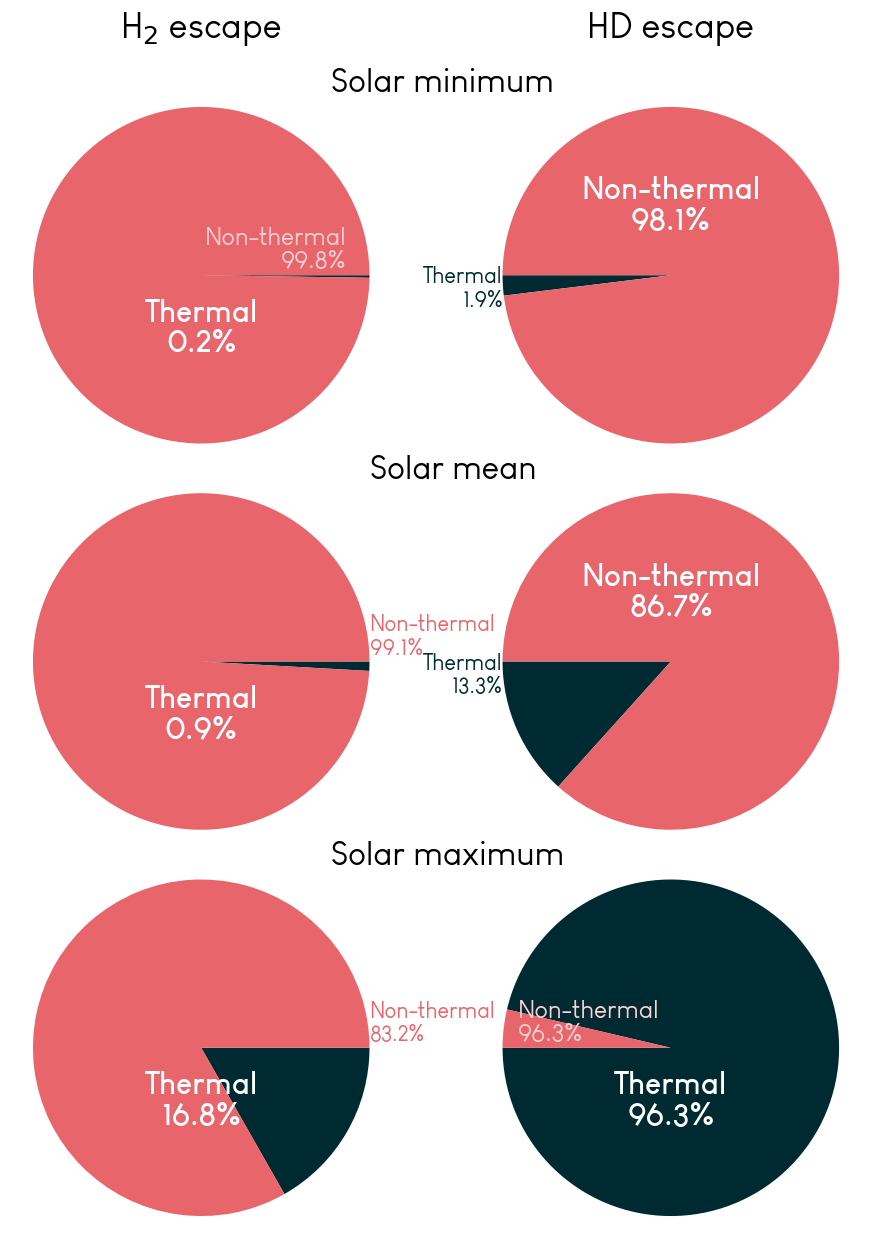

In [76]:
colors_molec = Dict("t"=>"#002A32", "nt"=>"#E9656C", "fade_text_t"=>"#CAEAF0", "fade_text_nt"=>"#FFD1D2")

escape_type_pie_improved_molec(all_solar_escdf, molec_esc_pcts, all_result_plot_folder, colors_molec; imgname="escape_pie_molec.png", 
                         ccw=false)

### atomic pie chart

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


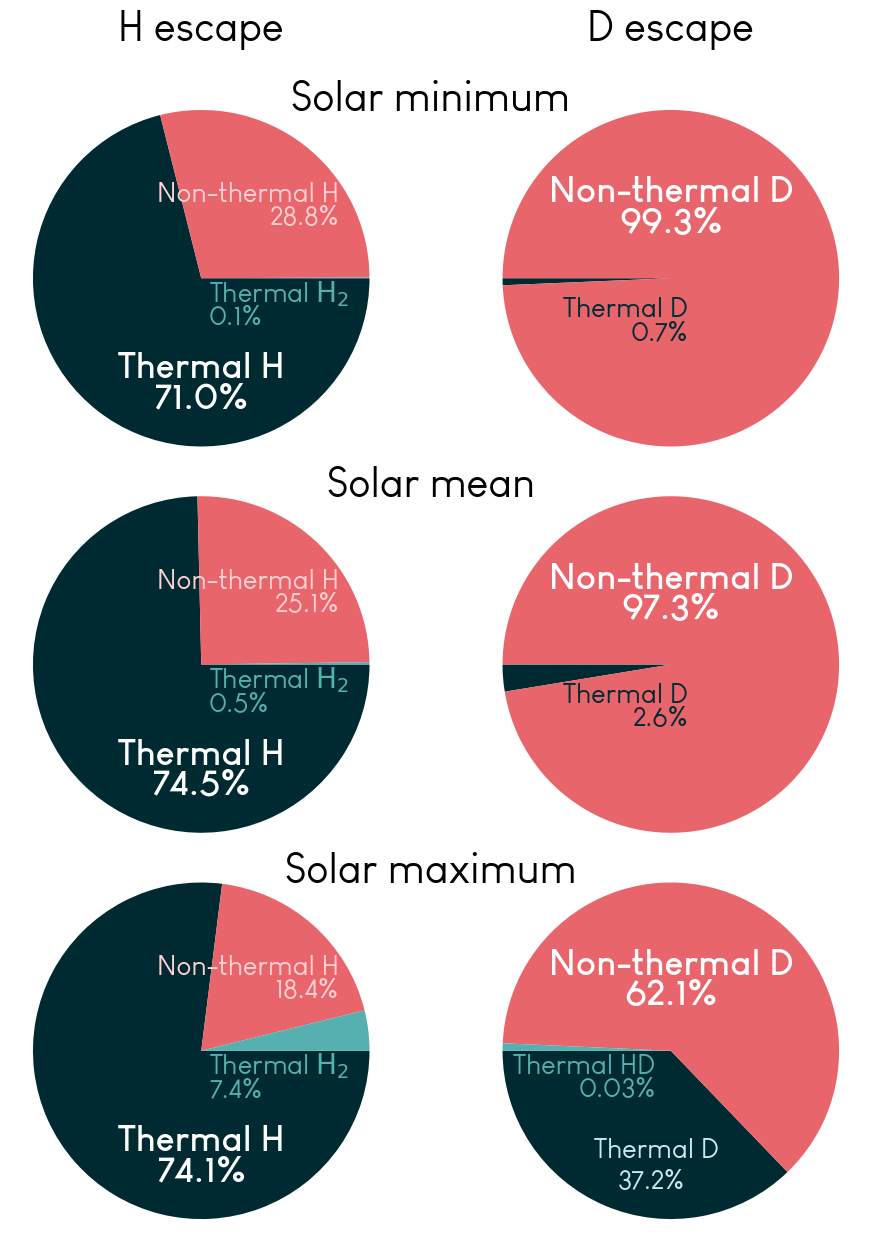

In [101]:
function escape_type_pie_improved_atomics(df, df_pcts, savepath, colors; imgname="escape_pie.png", dominant_bottom=[true,false], ccw=false)

    rcParams = PyCall.PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 20
    rcParams["axes.titlesize"] = 30
    rcParams["axes.labelsize"]= 24
    rcParams["xtick.labelsize"] = 24
    rcParams["ytick.labelsize"] = 24
    
    n_rows = nrow(df)
    fig, ax = subplots(n_rows, 2, sharex=true, figsize=(12, 15))
    subplots_adjust(hspace=0.01, wspace=0.02)
    
    # Label the solar cases
    add_imum = [true, false, true]
    for a in 1:size(ax)[1]
        thestr = add_imum[a] ? df."Solar conditions"[a]*"imum" : df."Solar conditions"[a]
        ax[a, 1].text(1.5, 1.1, thestr, size=30, ha="center")
    end
    # Establish the color order for the piecharts    
    wedge_color_order = [colors["t_atom"], colors["nt_atom"], colors["t_molec"]]
    
    # Wedge text label settings
    major_wedge = PieSlice(values=[0.], text="x", fontsize=26, fontweight="bold", dx=0, dy=0.3, pct_dx=0, pct_dy=0.5, color="white", ha="center")
    medium_wedge = PieSlice(values=[0.], text="x", fontsize=20, fontweight="normal", dx=-0.05, dy=0.3, pct_dx=0.05, pct_dy=0.15, color="white", ha="left")
    tiny_wedge = PieSlice(values=[0.], text="x", fontsize=20, fontweight="normal", dx=1.1, dy=-0.15, pct_dx=1.1, pct_dy=-0.3, color=colors["t_molec"], ha="left")
    
    # H-species escape pie charts --------------------------------------------------------------
    ax[1, 1].set_title("H escape", y=1.1)
    # The data
    slices_Hspc = [[df[1, "H thermal"], df[1, "H nonthermal"], df[1, "H2 thermal"]],
                   [df[2, "H thermal"], df[2, "H nonthermal"], df[2, "H2 thermal"]],
                   [df[3, "H thermal"], df[3, "H nonthermal"], df[3, "H2 thermal"]]]

    pcts_Hspc = 100 .* [df_pcts[1, "H thermal"] df_pcts[1, "H nonthermal"] df_pcts[1, "H2 thermal"];
                        df_pcts[2, "H thermal"] df_pcts[2, "H nonthermal"] df_pcts[2, "H2 thermal"];
                        df_pcts[3, "H thermal"] df_pcts[3, "H nonthermal"] df_pcts[3, "H2 thermal"]]
    
    # Modify the values, labels, and a few other things for H
    q = dominant_bottom[1] == true ? -1 : 1
    
    major_wedge_H = deepcopy(major_wedge)
    medium_wedge_H = deepcopy(medium_wedge)
    tiny_wedge_H = deepcopy(tiny_wedge)

    major_wedge_H.text = "Thermal H"
    major_wedge_H.values = pcts_Hspc[:, 1]
    major_wedge_H.dy = major_wedge_H.dy * q - 0.35
    major_wedge_H.pct_dy = major_wedge_H.pct_dy * q - 0.35
    
    medium_wedge_H.text = "Non-thermal H"
    medium_wedge_H.values = pcts_Hspc[:, 2]
    medium_wedge_H.color = colors["fade_text_nt"]
    medium_wedge_H.dx = 0.9
    medium_wedge_H.pct_dx = 0.9
    medium_wedge_H.dy = 0.5
    medium_wedge_H.pct_dy = 0.35
    medium_wedge_H.ha = "right"
    
    tiny_wedge_H.text = "Thermal "*string_to_latexstr("H2")
    tiny_wedge_H.values = pcts_Hspc[:, 3]
    tiny_wedge_H.dx = 0.05
    tiny_wedge_H.pct_dx = 0.05
    tiny_wedge_H.dy = -0.15
    tiny_wedge_H.pct_dy = -0.30
    
    for i in 1:n_rows
        # Plot the pie chart       
        ax[i, 1].pie(slices_Hspc[i], colors=wedge_color_order, counterclock=ccw, radius=1.1)

        # Add major slice labels
        ax[i, 1].text(major_wedge_H.dx, major_wedge_H.dy, major_wedge_H.text, fontsize=major_wedge_H.fontsize, fontweight=major_wedge_H.fontweight,
                      color=major_wedge_H.color, ha=major_wedge_H.ha)
        ax[i, 1].text(major_wedge_H.pct_dx, major_wedge_H.pct_dy, "$(round(major_wedge_H.values[i], digits=1))%", 
                      fontsize=major_wedge_H.fontsize, fontweight=major_wedge_H.fontweight, color=major_wedge_H.color, ha=major_wedge_H.ha)
            
        # Add minor slice labels
        ax[i, 1].text(medium_wedge_H.dx, medium_wedge_H.dy, medium_wedge_H.text, fontsize=medium_wedge_H.fontsize, 
                      color=medium_wedge_H.color, ha=medium_wedge_H.ha)
        ax[i, 1].text(medium_wedge_H.pct_dx, medium_wedge_H.pct_dy, "$(round(medium_wedge_H.values[i], digits=1))%", 
                      fontsize=medium_wedge_H.fontsize, color=medium_wedge_H.color, ha=medium_wedge_H.ha)
        
        # Add tiny slice labels 
        ax[i, 1].text(tiny_wedge_H.dx, tiny_wedge_H.dy, tiny_wedge_H.text, fontsize=tiny_wedge_H.fontsize, color=tiny_wedge_H.color, 
                      ha=tiny_wedge_H.ha)
        ax[i, 1].text(tiny_wedge_H.pct_dx, tiny_wedge_H.pct_dy, "$(round(tiny_wedge_H.values[i], digits=1))%", fontsize=tiny_wedge_H.fontsize, 
                      color=tiny_wedge_H.color, ha=tiny_wedge_H.ha)
    end
    
    # D escape --------------------------------------------------------------------------
    ax[1, 2].set_title("D escape", y=1.1)
    slice_Dspc = [[df[1, "D thermal"], df[1, "D nonthermal"], df[1, "HD thermal"]],
                  [df[2, "D thermal"], df[2, "D nonthermal"], df[2, "HD thermal"]],
                  [df[3, "D thermal"], df[3, "D nonthermal"], df[3, "HD thermal"]]]

    pcts_Dspc = 100 .* [df_pcts[1, "D thermal"] df_pcts[1, "D nonthermal"] df_pcts[1, "HD nonthermal"];
                        df_pcts[2, "D thermal"] df_pcts[2, "D nonthermal"] df_pcts[2, "HD nonthermal"];
                        df_pcts[3, "D thermal"] df_pcts[3, "D nonthermal"] df_pcts[3, "HD nonthermal"]]

    
    # Modify the values, labels, and a few other things for D
    q = dominant_bottom[2] == true ? -1 : 1
    
    major_wedge_D = deepcopy(major_wedge)
    medium_wedge_D = deepcopy(medium_wedge)
    tiny_wedge_D = deepcopy(tiny_wedge)

    major_wedge_D.text = "Non-thermal D"
    major_wedge_D.values = pcts_Dspc[:, 2]
    major_wedge_D.dy = q * major_wedge.pct_dy
    major_wedge_D.pct_dy = q * major_wedge.dy
    
    # Only used for 3rd panel
    medium_wedge_D.text = "Thermal D"
    medium_wedge_D.values = pcts_Dspc[:, 1]
    medium_wedge_D.color = colors["fade_text_t"]
    medium_wedge_D.dx = -0.5
    medium_wedge_D.dy = -0.7
    medium_wedge_D.pct_dx = -0.35
    medium_wedge_D.pct_dy = -0.9
    
    for i in 1:n_rows
        # Plot the pie chart
        ax[i, 2].pie(slice_Dspc[i], colors=wedge_color_order, startangle=180, radius=1.1)
        # Add major wedge labels
        ax[i, 2].text(major_wedge_D.dx, major_wedge_D.dy, major_wedge_D.text, fontsize=major_wedge_D.fontsize, fontweight=major_wedge_D.fontweight,
                      color=major_wedge_D.color, ha=major_wedge_D.ha)
        ax[i, 2].text(major_wedge_D.pct_dx, major_wedge_D.pct_dy, "$(round(major_wedge_D.values[i], digits=1))%", 
                      fontsize=major_wedge_D.fontsize, fontweight=major_wedge_D.fontweight, color=major_wedge_D.color, ha=major_wedge_D.ha)   
        
        if i < 3 # for the first two axes,
            # There is no medium wedge!
            
            # Add tiny wedge -- thermal D
            tiny_wedge_D.text = "Thermal D"
            tiny_wedge_D.values = pcts_Dspc[:, 1]
            tiny_wedge_D.color = colors["t_atom"]
            tiny_wedge_D.dx = 0.1 * tiny_wedge.dx 
            tiny_wedge_D.pct_dx = 0.1 * tiny_wedge.pct_dx 
            tiny_wedge_D.dy = tiny_wedge.dy-0.1
            tiny_wedge_D.pct_dy = tiny_wedge.pct_dy - 0.1
            tiny_wedge_D.ha = "right"
            ax[i, 2].text(tiny_wedge_D.dx, tiny_wedge_D.dy, tiny_wedge_D.text, fontsize=tiny_wedge_D.fontsize, color=tiny_wedge_D.color, 
                          ha=tiny_wedge_D.ha)
            ax[i, 2].text(tiny_wedge_D.pct_dx, tiny_wedge_D.pct_dy, "$(round(tiny_wedge_D.values[i], digits=1))%", fontsize=tiny_wedge_D.fontsize, 
                          color=tiny_wedge_D.color, ha=tiny_wedge_D.ha)
                
        else # in solar max, we have a medium wedge.
            # Medium wedges          
            ax[i, 2].text(medium_wedge_D.dx, medium_wedge_D.dy, medium_wedge_D.text, fontsize=medium_wedge_D.fontsize, color=medium_wedge_D.color, 
                          ha=medium_wedge_D.ha)
            ax[i, 2].text(medium_wedge_D.pct_dx, medium_wedge_D.pct_dy, "$(round(medium_wedge_D.values[i], digits=1))%", fontsize=medium_wedge_D.fontsize, 
                          color=medium_wedge_D.color, ha=medium_wedge_D.ha)   

            # Tiny wedge is now thermal HD
            tiny_wedge_D.text = "Thermal HD"
            tiny_wedge_D.values = pcts_Dspc[:, 3]
            tiny_wedge_D.color = colors["t_molec"]
            tiny_wedge_D.dx = -0.1
            tiny_wedge_D.pct_dx = -0.1
            tiny_wedge_D.dy = -0.15
            tiny_wedge_D.pct_dy = -0.3
            ax[i, 2].text(tiny_wedge_D.dx, tiny_wedge_D.dy, tiny_wedge_D.text, fontsize=tiny_wedge_D.fontsize, color=tiny_wedge_D.color, 
                          ha=tiny_wedge_D.ha)
            ax[i, 2].text(tiny_wedge_D.pct_dx, tiny_wedge_D.pct_dy, "$(round(tiny_wedge_D.values[i], digits=2))%", fontsize=tiny_wedge_D.fontsize, 
                          color=tiny_wedge_D.color, ha=tiny_wedge_D.ha)  
        end
    end
    
    savefig(savepath*imgname*".pdf", format="pdf", bbox_inches="tight", dpi=300)
    show()
end
colorscheme1 = Dict("t_atom"=>"#422040", "nt_atom"=>"#E57A44", "t_molec"=>"#8E668B", "fade_text_t"=>"#DDCDDC", "fade_text_nt"=>"#FFD6C2")
colorscheme2 = Dict("t_atom"=>"#445F5F", "nt_atom"=>"#FF6542", "t_molec"=>"#56B0B0", "fade_text_t"=>"#CFDEDE", "fade_text_nt"=>"#FFBCAD")
colorscheme3 = Dict("t_atom"=>"#002A32", "nt_atom"=>"#E9656C", "t_molec"=>"#56B0B0", "fade_text_t"=>"#CAEAF0", "fade_text_nt"=>"#FFD1D2")

escape_type_pie_improved_atomics(all_solar_escdf, escdf_percents, all_result_plot_folder, colorscheme3; imgname="escape_pie_atomic", 
                         ccw=false)

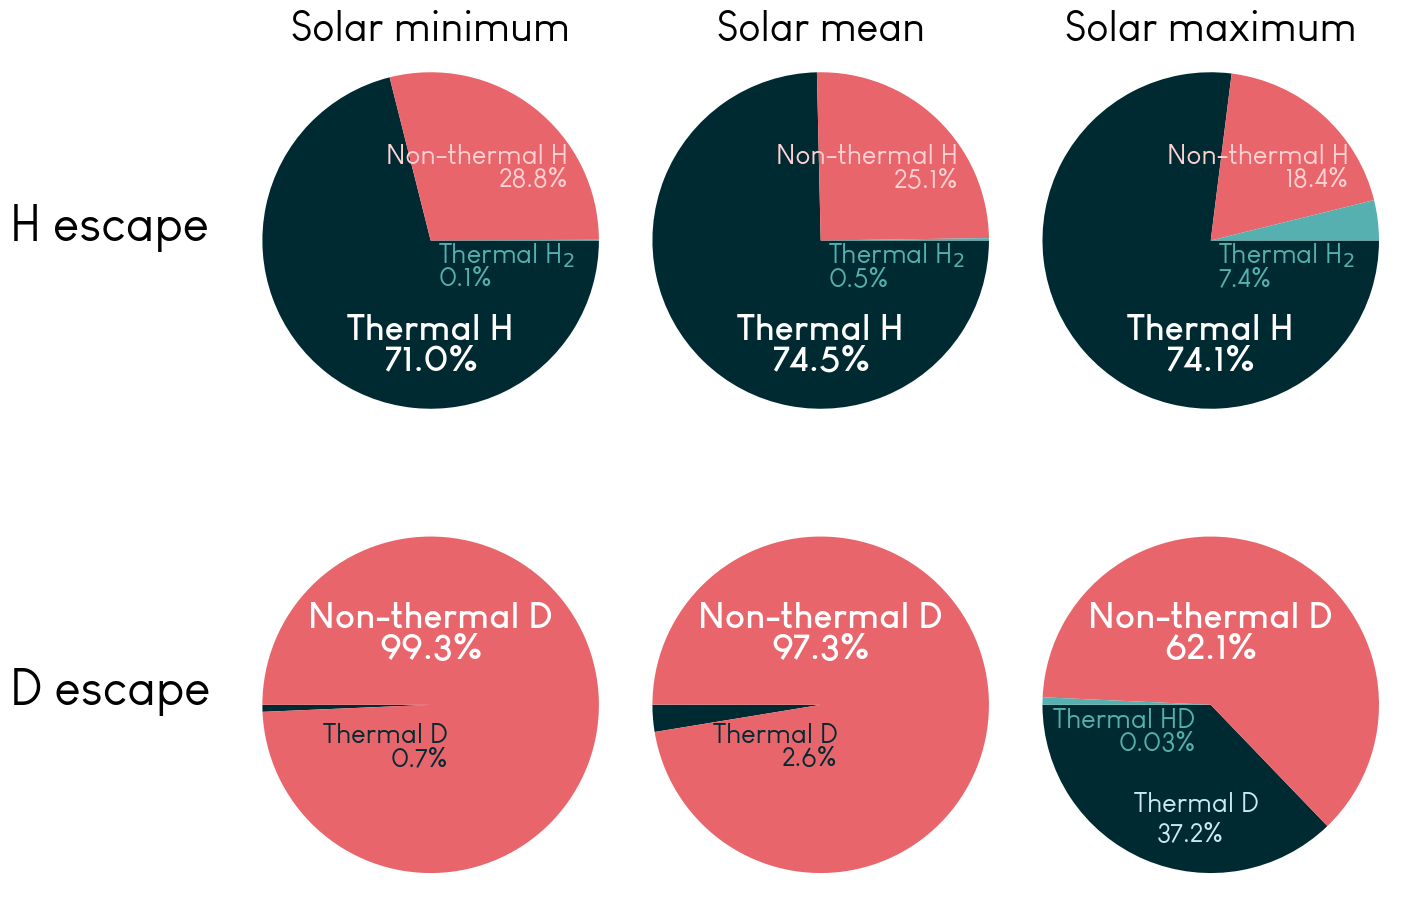

In [102]:
function escape_type_pie_improved_atomics_WIDE(df, df_pcts, savepath, colors; imgname="escape_pie.png", dominant_bottom=[true,false], ccw=false)

    rcParams = PyCall.PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 20
    rcParams["axes.titlesize"] = 30
    rcParams["axes.labelsize"]= 24
    rcParams["xtick.labelsize"] = 24
    rcParams["ytick.labelsize"] = 24
    
    n_cols = nrow(df)
    fig, ax = subplots(2, n_cols, sharex=true, figsize=(15,12))
    subplots_adjust(hspace=0.01, wspace=0.02)
    
    title_x = -0.6
    
    # Label the solar cases
    add_imum = [true, false, true]
    for a in 1:size(ax)[2]
        thestr = add_imum[a] ? df."Solar conditions"[a]*"imum" : df."Solar conditions"[a]
        ax[1, a].set_title(thestr)
    end

    # Establish the color order for the piecharts    
    wedge_color_order = [colors["t_atom"], colors["nt_atom"], colors["t_molec"]]
    
    # Wedge text label settings
    major_wedge = PieSlice(values=[0.], text="x", fontsize=26, fontweight="bold", dx=0, dy=0.3, pct_dx=0, pct_dy=0.5, color="white", ha="center")
    medium_wedge = PieSlice(values=[0.], text="x", fontsize=20, fontweight="normal", dx=-0.05, dy=0.3, pct_dx=0.05, pct_dy=0.15, color="white", ha="left")
    tiny_wedge = PieSlice(values=[0.], text="x", fontsize=20, fontweight="normal", dx=1.1, dy=-0.15, pct_dx=1.1, pct_dy=-0.3, color=colors["t_molec"], ha="left")
    
    # H-species escape pie charts --------------------------------------------------------------
    ax[1, 1].text(title_x, 0.5, "H escape", size=36, transform=ax[1,1].transAxes)
    # The data
    slices_Hspc = [[df[1, "H thermal"], df[1, "H nonthermal"], df[1, "H2 thermal"]],
                   [df[2, "H thermal"], df[2, "H nonthermal"], df[2, "H2 thermal"]],
                   [df[3, "H thermal"], df[3, "H nonthermal"], df[3, "H2 thermal"]]]

    pcts_Hspc = 100 .* [df_pcts[1, "H thermal"] df_pcts[1, "H nonthermal"] df_pcts[1, "H2 thermal"];
                        df_pcts[2, "H thermal"] df_pcts[2, "H nonthermal"] df_pcts[2, "H2 thermal"];
                        df_pcts[3, "H thermal"] df_pcts[3, "H nonthermal"] df_pcts[3, "H2 thermal"]]
    
    # Modify the values, labels, and a few other things for H
    q = dominant_bottom[1] == true ? -1 : 1
    
    major_wedge_H = deepcopy(major_wedge)
    medium_wedge_H = deepcopy(medium_wedge)
    tiny_wedge_H = deepcopy(tiny_wedge)

    major_wedge_H.text = "Thermal H"
    major_wedge_H.values = pcts_Hspc[:, 1]
    major_wedge_H.dy = major_wedge_H.dy * q - 0.35
    major_wedge_H.pct_dy = major_wedge_H.pct_dy * q - 0.35
    
    medium_wedge_H.text = "Non-thermal H"
    medium_wedge_H.values = pcts_Hspc[:, 2]
    medium_wedge_H.color = colors["fade_text_nt"]
    medium_wedge_H.dx = 0.9
    medium_wedge_H.pct_dx = 0.9
    medium_wedge_H.dy = 0.5
    medium_wedge_H.pct_dy = 0.35
    medium_wedge_H.ha = "right"
    
    tiny_wedge_H.text = L"Thermal H$_2$"
    tiny_wedge_H.values = pcts_Hspc[:, 3]
    tiny_wedge_H.dx = 0.05
    tiny_wedge_H.pct_dx = 0.05
    tiny_wedge_H.dy = -0.15
    tiny_wedge_H.pct_dy = -0.30
    
    for i in 1:n_cols
        # Plot the pie chart       
        ax[1, i].pie(slices_Hspc[i], colors=wedge_color_order, counterclock=ccw, radius=1.1)

        # Add major slice labels
        ax[1, i].text(major_wedge_H.dx, major_wedge_H.dy, major_wedge_H.text, fontsize=major_wedge_H.fontsize, fontweight=major_wedge_H.fontweight,
                      color=major_wedge_H.color, ha=major_wedge_H.ha)
        ax[1, i].text(major_wedge_H.pct_dx, major_wedge_H.pct_dy, "$(round(major_wedge_H.values[i], digits=1))%", 
                      fontsize=major_wedge_H.fontsize, fontweight=major_wedge_H.fontweight, color=major_wedge_H.color, ha=major_wedge_H.ha)
            
        # Add minor slice labels
        ax[1, i].text(medium_wedge_H.dx, medium_wedge_H.dy, medium_wedge_H.text, fontsize=medium_wedge_H.fontsize, 
                      color=medium_wedge_H.color, ha=medium_wedge_H.ha)
        ax[1, i].text(medium_wedge_H.pct_dx, medium_wedge_H.pct_dy, "$(round(medium_wedge_H.values[i], digits=1))%", 
                      fontsize=medium_wedge_H.fontsize, color=medium_wedge_H.color, ha=medium_wedge_H.ha)
        
        # Add tiny slice labels 
        ax[1, i].text(tiny_wedge_H.dx, tiny_wedge_H.dy, tiny_wedge_H.text, fontsize=tiny_wedge_H.fontsize, color=tiny_wedge_H.color, 
                      ha=tiny_wedge_H.ha)
        ax[1, i].text(tiny_wedge_H.pct_dx, tiny_wedge_H.pct_dy, "$(round(tiny_wedge_H.values[i], digits=1))%", fontsize=tiny_wedge_H.fontsize, 
                      color=tiny_wedge_H.color, ha=tiny_wedge_H.ha)

    end
    
    # D escape --------------------------------------------------------------------------
    ax[2, 1].text(title_x, 0.5, "D escape", size=36, transform=ax[2, 1].transAxes)
    slice_Dspc = [[df[1, "D thermal"], df[1, "D nonthermal"], df[1, "HD thermal"]],
                  [df[2, "D thermal"], df[2, "D nonthermal"], df[2, "HD thermal"]],
                  [df[3, "D thermal"], df[3, "D nonthermal"], df[3, "HD thermal"]]]

    pcts_Dspc = 100 .* [df_pcts[1, "D thermal"] df_pcts[1, "D nonthermal"] df_pcts[1, "HD nonthermal"];
                        df_pcts[2, "D thermal"] df_pcts[2, "D nonthermal"] df_pcts[2, "HD nonthermal"];
                        df_pcts[3, "D thermal"] df_pcts[3, "D nonthermal"] df_pcts[3, "HD nonthermal"]]

    
    # Modify the values, labels, and a few other things for D
    q = dominant_bottom[2] == true ? -1 : 1
    
    major_wedge_D = deepcopy(major_wedge)
    medium_wedge_D = deepcopy(medium_wedge)
    tiny_wedge_D = deepcopy(tiny_wedge)

    major_wedge_D.text = "Non-thermal D"
    major_wedge_D.values = pcts_Dspc[:, 2]
    major_wedge_D.dy = q * major_wedge.pct_dy
    major_wedge_D.pct_dy = q * major_wedge.dy
    
    # Only used for 3rd panel
    medium_wedge_D.text = "Thermal D"
    medium_wedge_D.values = pcts_Dspc[:, 1]
    medium_wedge_D.color = colors["fade_text_t"]
    medium_wedge_D.dx = -0.5
    medium_wedge_D.dy = -0.7
    medium_wedge_D.pct_dx = -0.35
    medium_wedge_D.pct_dy = -0.9
    
    for i in 1:n_cols
        # Plot the pie chart
        ax[2, i].pie(slice_Dspc[i], colors=wedge_color_order, startangle=180, radius=1.1)
        # Add major wedge labels
        ax[2, i].text(major_wedge_D.dx, major_wedge_D.dy, major_wedge_D.text, fontsize=major_wedge_D.fontsize, fontweight=major_wedge_D.fontweight,
                      color=major_wedge_D.color, ha=major_wedge_D.ha)
        ax[2, i].text(major_wedge_D.pct_dx, major_wedge_D.pct_dy, "$(round(major_wedge_D.values[i], digits=1))%", 
                      fontsize=major_wedge_D.fontsize, fontweight=major_wedge_D.fontweight, color=major_wedge_D.color, ha=major_wedge_D.ha)   
        
        if i < 3 # for the first two axes,
            # There is no medium wedge!
            
            # Add tiny wedge -- thermal D
            tiny_wedge_D.text = "Thermal D"
            tiny_wedge_D.values = pcts_Dspc[:, 1]
            tiny_wedge_D.color = colors["t_atom"]
            tiny_wedge_D.dx = 0.1 * tiny_wedge.dx 
            tiny_wedge_D.pct_dx = 0.1 * tiny_wedge.pct_dx 
            tiny_wedge_D.dy = tiny_wedge.dy-0.1
            tiny_wedge_D.pct_dy = tiny_wedge.pct_dy - 0.1
            tiny_wedge_D.ha = "right"
            ax[2, i].text(tiny_wedge_D.dx, tiny_wedge_D.dy, tiny_wedge_D.text, fontsize=tiny_wedge_D.fontsize, color=tiny_wedge_D.color, 
                          ha=tiny_wedge_D.ha)
            ax[2, i].text(tiny_wedge_D.pct_dx, tiny_wedge_D.pct_dy, "$(round(tiny_wedge_D.values[i], digits=1))%", fontsize=tiny_wedge_D.fontsize, 
                          color=tiny_wedge_D.color, ha=tiny_wedge_D.ha)
                
        else # in solar max, we have a medium wedge.
            # Medium wedges          
            ax[2, i].text(medium_wedge_D.dx, medium_wedge_D.dy, medium_wedge_D.text, fontsize=medium_wedge_D.fontsize, color=medium_wedge_D.color, 
                          ha=medium_wedge_D.ha)
            ax[2, i].text(medium_wedge_D.pct_dx, medium_wedge_D.pct_dy, "$(round(medium_wedge_D.values[i], digits=1))%", fontsize=medium_wedge_D.fontsize, 
                          color=medium_wedge_D.color, ha=medium_wedge_D.ha)   

            # Tiny wedge is now thermal HD
            tiny_wedge_D.text = "Thermal HD"
            tiny_wedge_D.values = pcts_Dspc[:, 3]
            tiny_wedge_D.color = colors["t_molec"]
            tiny_wedge_D.dx = -0.1
            tiny_wedge_D.pct_dx = -0.1
            tiny_wedge_D.dy = -0.15
            tiny_wedge_D.pct_dy = -0.3
            ax[2, i].text(tiny_wedge_D.dx, tiny_wedge_D.dy, tiny_wedge_D.text, fontsize=tiny_wedge_D.fontsize, color=tiny_wedge_D.color, 
                          ha=tiny_wedge_D.ha)
            ax[2, i].text(tiny_wedge_D.pct_dx, tiny_wedge_D.pct_dy, "$(round(tiny_wedge_D.values[i], digits=2))%", fontsize=tiny_wedge_D.fontsize, 
                          color=tiny_wedge_D.color, ha=tiny_wedge_D.ha)  
        end
    end
    
    savefig(savepath*imgname, bbox_inches="tight", dpi=300)
    show()
end

escape_type_pie_improved_atomics_WIDE(all_solar_escdf, escdf_percents, all_result_plot_folder, colorscheme3; imgname="escape_pie_atomic_WIDE.png", 
                         ccw=false)

## Non-thermal escape probability

In [49]:
function nt_escape_plots(sp, solarmean, hot_net, hot_rc, savepath; solarmin=nothing, solarmax=nothing, rightx=1e-1)
    
    rcParams = PyCall.PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 18
    rcParams["axes.titlesize"] = 24
    rcParams["axes.labelsize"]= 20
    rcParams["xtick.labelsize"] = 18
    rcParams["ytick.labelsize"] = 18
    
    # Get the stuff to plot
    Pe_mean = escape_probability(sp, solarmean; all_species, collision_xsect);
    produced_hot_smean = volume_rate_wrapper(sp, hot_net, hot_rc, solarmean, n_tot(solarmean; all_species); returntype="by alt", 
                                   all_species, alt, collision_xsect, ion_species, Jratedict=Jratedict_smean, molmass, non_bdy_layers, num_layers,  
                                   n_alt_index, Tn=Tn_smean, Ti=Ti_smean, Te=Te_smean, dz, zmax);
    
    if solarmin!= nothing
        Pe_min = escape_probability(sp, solarmin; all_species, collision_xsect);
        produced_hot_smin = volume_rate_wrapper(sp, hot_net, hot_rc, solarmin, n_tot(solarmin; all_species); returntype="by alt", 
                                           all_species, alt, collision_xsect, ion_species, Jratedict=Jratedict_smin, molmass, non_bdy_layers, num_layers,  
                                           n_alt_index, Tn=Tn_smin, Ti=Ti_smin, Te=Te_smin, dz, zmax);
    end

    if solarmax != nothing
        Pe_max = escape_probability(sp, solarmax; all_species, collision_xsect);
        produced_hot_smax = volume_rate_wrapper(sp, hot_net, hot_rc, solarmax, n_tot(solarmax; all_species); returntype="by alt", 
                                           all_species, alt, collision_xsect, ion_species, Jratedict=Jratedict_smax, molmass, non_bdy_layers, num_layers,  
                                           n_alt_index, Tn=Tn_smax, Ti=Ti_smax, Te=Te_smax, dz, zmax);
    end

    # PLot
    
    fig, ax = subplots(1, 3, sharey=true, figsize=(12,4))
    subplots_adjust(wspace=0.15)
    for a in ax
        plot_bg(a)
        a.set_ylim(0, 250)
    end

    ax[1].plot(Pe_mean, plot_grid, color=solarcols[2, :])
    
    ax[1].set_xlabel("Escape probability")
    ax[1].set_ylabel("Altitude (km)")
    ax[1].set_xlim(-0.05,1)
    ax[1].set_xticklabels(["0", "0", "0.5", "1"])
    
    # X
    ax[1].text(1.01, 0.5, L"$\times$", fontsize=27, transform=ax[1].transAxes)
    ax[2].plot(produced_hot_smean, plot_grid, color=solarcols[2, :])
    ax[2].set_xlabel("Volume production\nof"*L" hot %$(sp) (cm$^{-3}$s$^{-1}$)")
    ax[2].set_xscale("log")
    ax[2].set_xlim(1e-9,rightx)
    
    ax[2].text(1.01, 0.5, "=", fontsize=42, transform=ax[2].transAxes)
    
    
    ax[3].plot(Pe_mean .* produced_hot_smean, plot_grid, color=solarcols[2, :], label="Solar mean")
    
    ax[3].set_xlabel("Escaping hot $(sp)\nby "*L"volume (cm$^{-3}$s$^{-1}$)")
    ax[3].set_xscale("log")
    ax[3].set_xlim(1e-9,rightx)
    # ax[3].legend(loc="lower right", fontsize=16)
    
    if solarmin != nothing
        ax[1].plot(Pe_min, plot_grid, color=solarcols[1, :])
        ax[2].plot(produced_hot_smin, plot_grid, color=solarcols[1, :])
        ax[3].plot(Pe_min .* produced_hot_smin, plot_grid, color=solarcols[1, :], label="Solar min")
    end
    if solarmax != nothing
        ax[1].plot(Pe_max, plot_grid, color=solarcols[3, :])
        ax[2].plot(produced_hot_smax, plot_grid, color=solarcols[3, :])
        ax[3].plot(Pe_max .* produced_hot_smax, plot_grid, color=solarcols[3, :], label="Solar max")
    end

    savefig(savepath*"ntesc.png", dpi=300, bbox_inches="tight")
    show()
    
end

nt_escape_plots(:D, solarmean, hot_D_network, hot_D_rc_funcs, all_result_plot_folder)

LoadError: UndefVarError: Jratedict_smean not defined

# Fractionation Factor


In [103]:
surf_hdo = [solarmin[:HDO][1], solarmean[:HDO][1], solarmax[:HDO][1]]
surf_h2o = [solarmin[:H2O][1], solarmean[:H2O][1], solarmax[:H2O][1]]

3-element Vector{Float64}:
 2.423064335265934e13
 2.423064335265934e13
 2.423064335265934e13

In [104]:
f_t = ((all_solar_escdf."D thermal" .+ all_solar_escdf."HD thermal") ./ (all_solar_escdf."H thermal" .+ 2*all_solar_escdf."H2 thermal")) ./ (surf_hdo ./ (2 .* surf_h2o))

3-element Vector{Float64}:
 0.00041424449246179874
 0.0015406120103753382
 0.032043134746797264

In [105]:
f_nt = (all_solar_escdf."D nonthermal" ./ all_solar_escdf."H nonthermal") ./ (surf_hdo ./ (2 .* surf_h2o))

3-element Vector{Float64}:
 0.15151045701810542
 0.17290585831292388
 0.23209477200493542

In [106]:
f_tnt = (all_solar_escdf."D total" ./ all_solar_escdf."H total") ./ (surf_hdo ./ (2 .* surf_h2o))

3-element Vector{Float64}:
 0.04401347429235085
 0.044534653663475685
 0.06896148630933689

In [107]:
f_df = DataFrame(solar=["Solar min", "Solar mean", "Solar max"], thermal=f_t, nonthermal=f_nt, all=f_tnt)

3×4 DataFrame
 Row │ solar       thermal      nonthermal  all       
     │ String      Float64      Float64     Float64   
─────┼────────────────────────────────────────────────
   1 │ Solar min   0.000414244    0.15151   0.0440135
   2 │ Solar mean  0.00154061     0.172906  0.0445347
   3 │ Solar max   0.0320431      0.232095  0.0689615

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


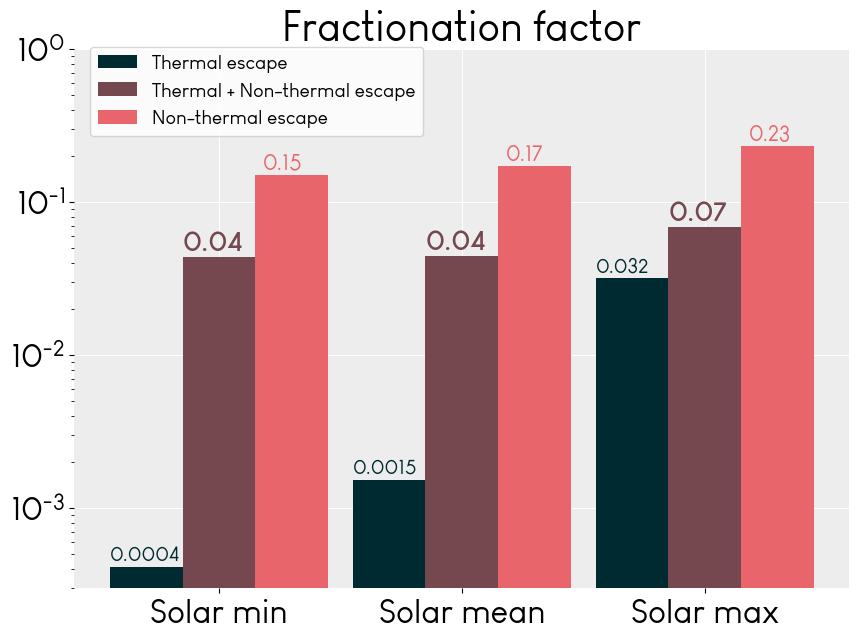

In [108]:
function solarcycle_ff(f_t, f_tnt, f_nt)

    # H 
    fig, ax = subplots(figsize=(10,7))
    x_t = 1:3
    width = -0.3
 
    plot_bg(ax)
    ax.set_yscale("log")
    ax.set_xticks(x_t)
    ax.set_xticklabels(["Solar min", "Solar mean", "Solar max"])
    ax.set_title("Fractionation factor")
    
    rcParams["hatch.linewidth"] = 10
    
    # Plot the values
    # Thermal
    ax.bar(x_t .+ width*0.5, f_t, width=width, label="Thermal escape", align="edge", zorder=10, facecolor="#002A32")
    for (i, v) in enumerate(f_t)
        ax.text(i+1.5*width, v+v*0.1, "$(round(v, digits=4))", color = "#002A32", zorder=100, fontsize=15)
    end
    
    # Thermal + Nonthermal
    ax.bar(x_t, f_tnt, width=width, label="Thermal + Non-thermal escape", zorder=10, facecolor="#75484f")
    # ax.bar(x_t, f_tnt, width=width, label="thermal + non-thermal escape", zorder=10, facecolor="#002A32", edgecolor="#E9656C", hatch="\\") # Use if you want to hatch two colors
    for (i, v) in enumerate(f_tnt)
        ax.text(i+0.5*width, v+v*0.1, "$(round(v, digits=2))", color = "#75484f", fontweight="bold", zorder=100)
    end
    
    # Nonthermal
    ax.bar(x_t .- width, f_nt, width=width, label="Non-thermal escape", zorder=10, facecolor="#E9656C")
    for (i, v) in enumerate(f_nt)
        ax.text(i-width*0.6, v+v*0.1, "$(round(v, digits=2))", color = "#E9656C", zorder=100, fontsize=16)
    end
    
    # wrap up
    ax.legend(fontsize=14, loc=(0.02, 0.84))
    ax.set_ylim(3e-4, 1e0)
    
    savefig(all_result_plot_folder*"fractionation_barchart.pdf", format="pdf", bbox_inches="tight", dpi=300)
    show()
end

solarcycle_ff(f_t, f_tnt, f_nt)

## Historical plots for comparison

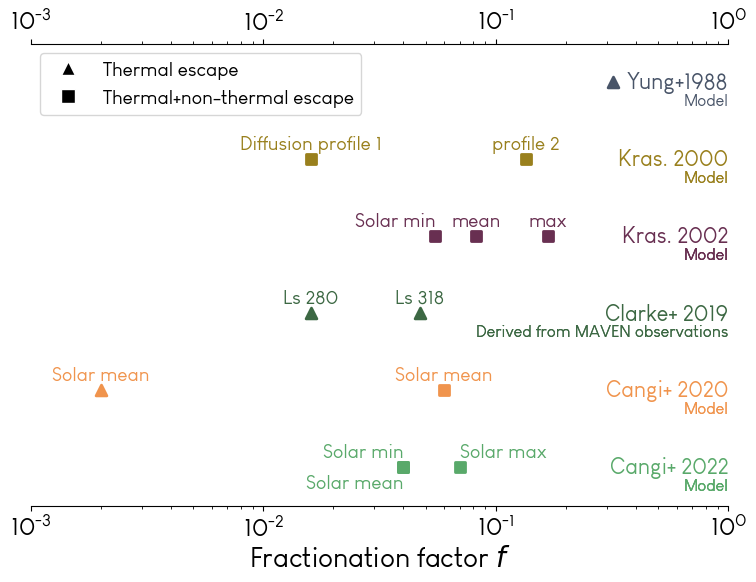

In [198]:
function plot_results_caltech_together(base)
    #=
    Plots the thermal and thermal+nonthermal results together in the same plot.

    base: the folder of results
    =#

    toplot_others = Dict("Clarke+ 2019"=>[0.016, 0.047],
                   "Kras. 2002"=>[0.055, 0.082, 0.167],
                   "Kras. 2000"=>[0.016, 0.135],
                   "Yung+ 1988"=>[0.32],
                    "Cangi+ 2020"=>[0.002, 0.06],
                    "Cangi+ 2022"=>[0.04, 0.04, 0.07]
                  )
    # PLOT =====================================================================
    fig, ax = subplots(figsize=(9,6))

    # STYLE SETTINGS -----------------------------------------------------------
    for side in ["left", "right"]
        ax.spines[side].set_visible(false)
    end
    ax.tick_params(which="both", labelleft=false, left=false, labeltop=true, top=true)

    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 18
    rcParams["axes.labelsize"]= 20
    rcParams["xtick.labelsize"] = 18
    rcParams["ytick.labelsize"] = 18

    # Which things to plot 
    plot_order = ["Cangi+ 2022", "Cangi+ 2020", "Clarke+ 2019", "Kras. 2002", "Kras. 2000", "Yung+ 1988"]
    dummyind_others = [1, 2, 3, 4, 5, 6]

    myorange = "xkcd:faded orange"
    colors = ["#59A96A", myorange, "#3c6843", "#682f51", "#99801d", "#485468"]

    msize = 60 
    nameha = "right"
    nalign = 1
    
    special_text = [["Solar min", "Solar mean", "Solar max"], ["Solar mean", "Solar mean"], ["Ls 280", "Ls 318"], ["Solar min", "mean", "max"], ["Diffusion profile 1", "profile 2"], [""]]
    mark = [["s", "s", "s"], ["^", "s"], ["^", "^"], ["s", "s", "s"], ["s", "s"], ["^"]]
    exptype = ["Model", "Model", "Derived from MAVEN observations", "Model", "Model", "Model"]

    # PAST STUDIES -------------------------------------------------------------
    for (d, e) in zip(dummyind_others, plot_order)
        for j in 1:length(toplot_others[e])
            x = toplot_others[e][j]
            c = colors[d]
            ax.scatter(x, d, linewidth=2, color=c, marker=mark[d][j], s=msize, zorder=6)
        end
        # text labels 
        if plot_order[d]=="Yung+ 1988"
            whom = "Yung+1988"
        else
            whom=plot_order[d]
        end
        ax.text(nalign, d, whom, color=colors[d], ha=nameha, va="center", fontsize=16)
        for i in 1:length(special_text[d])
            h = "center"
            y = d + 0.2
            if i==1 && plot_order[d]=="Kras. 2002"
                h = "right"
            end
            if i==1 && plot_order[d]=="Cangi+ 2022"
                h = "right"
            end
            if i==2 && plot_order[d]=="Cangi+ 2022"
                y = d - 0.2
                h = "right"
            end
            if i==3 && plot_order[d]=="Cangi+ 2022"
                h = "left"
            end
            ax.text(1, d-0.3, exptype[d], color=colors[d], ha="right", fontsize=12)
            ax.text(toplot_others[plot_order[d]][i], y, special_text[d][i], color=colors[d], ha=h, va="center", fontsize=14)
        end
    end

    # PLOT CONFIGURATION -------------------------------------------------------
    plt.margins(x=0.01, y=0.01)
    ax.set_xlabel(L"Fractionation factor $f$", fontsize=20)
    ax.set_xscale("log")
    ax.set_xticks([1e-3, 1e-2, 1e-1, 1e0])
    ax.set_ylim(0.5, length(colors)+0.5)
    ax.tick_params(which="both", labelsize=18)
    ax.set_xlim([1e-3, 1])
    
    L2D = PyPlot.matplotlib.lines.Line2D
    legend_elements = [L2D([0], [0], marker="^", color="white", label="Thermal escape",
                          markerfacecolor="black", markersize=10),
                        L2D([0], [0], marker="s", color="white", label="Thermal+non-thermal escape",
                                          markerfacecolor="black", markersize=10)]
    ax.legend(handles=legend_elements, loc="upper left", fontsize=14)
    
    show()
    # save to the two useful folders
    savefig(all_result_plot_folder*"f_results.png", bbox_inches="tight", dpi=300)
end

plot_results_caltech_together("blah")

# Dominant reactions at each solar stage

In [109]:
Jratelist_smin = format_Jrates(solarmin_folder*"active_rxns.xlsx", all_species, "Jratelist"; hot_atoms=true, ions_on=true)[1];
Jratedict_smin = Dict([j=>solarmin[j] for j in Jratelist_smin])

Jratelist_smean = format_Jrates(solarmean_folder*"active_rxns.xlsx", all_species, "Jratelist"; hot_atoms=true, ions_on=true)[1];
Jratedict_smean = Dict([j=>solarmean[j] for j in Jratelist_smean])

Jratelist_smax = format_Jrates(solarmax_folder*"active_rxns.xlsx", all_species, "Jratelist"; hot_atoms=true, ions_on=true)[1];
Jratedict_smax = Dict([j=>solarmax[j] for j in Jratelist_smax]);

## H

In [110]:
Mtotmin = sum([solarmin[sp] for sp in all_species]);
# H
H_prod_by_alt_min = escaping_hot_atom_production(:H, hot_H_network, hot_H_rc_funcs, solarmin, Mtotmin; all_species, alt, collision_xsect, dz,  
                                                     ion_species, Jratedict=Jratedict_smin, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn_smin, Ti=Ti_smin, Te=Te_smin, zmax);
H_prod_by_alt_min_df = escaping_hot_atom_production(:H, hot_H_network, hot_H_rc_funcs, solarmin, Mtotmin; returntype="df", all_species, alt, collision_xsect, dz,  
                                                     ion_species, Jratedict=Jratedict_smin, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn_smin, Ti=Ti_smin, Te=Te_smin, zmax);
total_hot_H_min = nonthermal_escape_flux(hot_H_network, H_prod_by_alt_min; dz); # This is already sorted within the function here.

In [111]:
Mtotmean = sum([solarmean[sp] for sp in all_species]);
# H
H_prod_by_alt_mean = escaping_hot_atom_production(:H, hot_H_network, hot_H_rc_funcs, solarmean, Mtotmean; all_species, alt, collision_xsect, dz,  
                                                     ion_species, Jratedict=Jratedict_smean, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn_smean, Ti=Ti_smean, Te=Te_smean, zmax);
H_prod_by_alt_mean_df = escaping_hot_atom_production(:H, hot_H_network, hot_H_rc_funcs, solarmean, Mtotmean; returntype="df", all_species, alt, collision_xsect, dz,  
                                                     ion_species, Jratedict=Jratedict_smean, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn_smean, Ti=Ti_smean, Te=Te_smean, zmax);
total_hot_H_mean = nonthermal_escape_flux(hot_H_network, H_prod_by_alt_mean; dz);

In [112]:
Mtotmax = sum([solarmax[sp] for sp in all_species]);
# H
H_prod_by_alt_max = escaping_hot_atom_production(:H, hot_H_network, hot_H_rc_funcs, solarmax, Mtotmax; all_species, alt, collision_xsect, dz,  
                                                     ion_species, Jratedict=Jratedict_smax, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn_smax, Ti=Ti_smax, Te=Te_smax, zmax);
H_prod_by_alt_max_df = escaping_hot_atom_production(:H, hot_H_network, hot_H_rc_funcs, solarmax, Mtotmax; returntype="df", all_species, alt, collision_xsect, dz,  
                                                     ion_species, Jratedict=Jratedict_smax, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn_smax, Ti=Ti_smax, Te=Te_smax, zmax);
total_hot_H_max = nonthermal_escape_flux(hot_H_network, H_prod_by_alt_max; dz);
println(total_hot_H_max[1:5, :])

5×2 DataFrame
 Row │ Rxn                        Value     
     │ String                     Float64   
─────┼──────────────────────────────────────
   1 │ HCOpl + E --> CO + H       2.05673e7
   2 │ CO2pl + H2 --> HCO2pl + H  2.00205e7
   3 │ HCO2pl + E --> CO + O + H  1.29676e6
   4 │ Opl + H2 --> OHpl + H      1.28829e6
   5 │ OHpl + O --> O2pl + H      2.84639e5


## D

In [113]:
D_prod_by_alt_min = escaping_hot_atom_production(:D, hot_D_network, hot_D_rc_funcs, solarmin, Mtotmin; all_species, alt, collision_xsect, dz,  
                                                     ion_species, Jratedict=Jratedict_smin, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn_smin, Ti=Ti_smin, Te=Te_smin, zmax)
D_prod_by_alt_min_df = escaping_hot_atom_production(:D, hot_D_network, hot_D_rc_funcs, solarmin, Mtotmin; returntype="df", all_species, alt, collision_xsect, dz,  
                                                     ion_species, Jratedict=Jratedict_smin, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn_smin, Ti=Ti_smin, Te=Te_smin, zmax)
total_hot_D_min = nonthermal_escape_flux(hot_D_network, D_prod_by_alt_min; dz);
println(total_hot_D_min[1:5, :])

5×2 DataFrame
 Row │ Rxn                        Value    
     │ String                     Float64  
─────┼─────────────────────────────────────
   1 │ CO2pl + HD --> HCO2pl + D  3817.86
   2 │ DCOpl + E --> CO + D       3633.31
   3 │ DCO2pl + E --> CO + O + D   751.08
   4 │ Opl + HD --> OHpl + D       539.172
   5 │ N2pl + HD --> N2Hpl + D     114.149


In [114]:
D_prod_by_alt_mean = escaping_hot_atom_production(:D, hot_D_network, hot_D_rc_funcs, solarmean, Mtotmean; all_species, alt, collision_xsect, dz,  
                                                     ion_species, Jratedict=Jratedict_smean, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn_smean, Ti=Ti_smean, Te=Te_smean, zmax)
D_prod_by_alt_mean_df = escaping_hot_atom_production(:D, hot_D_network, hot_D_rc_funcs, solarmean, Mtotmean; returntype="df", all_species, alt, collision_xsect, dz,  
                                                     ion_species, Jratedict=Jratedict_smean, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn_smean, Ti=Ti_smean, Te=Te_smean, zmax)
total_hot_D_mean = nonthermal_escape_flux(hot_D_network, D_prod_by_alt_mean; dz);
println(total_hot_D_mean[1:38, :])

38×2 DataFrame
 Row │ Rxn                        Value          
     │ String                     Float64        
─────┼───────────────────────────────────────────
   1 │ CO2pl + HD --> HCO2pl + D  3636.59
   2 │ DCOpl + E --> CO + D       3626.85
   3 │ DCO2pl + E --> CO + O + D   710.815
   4 │ Opl + HD --> OHpl + D       645.971
   5 │ N2pl + HD --> N2Hpl + D     125.58
   6 │ ODpl + O --> O2pl + D       115.962
   7 │ HDpl + CO2 --> HCO2pl + D    82.5843
   8 │ DCO2pl + E --> CO2 + D       52.2658
   9 │ COpl + HD --> HCOpl + D      32.6991
  10 │ COpl + HD --> HOCpl + D      32.6991
  11 │ HDpl + O --> OHpl + D        21.7865
  12 │ OHpl + HD --> H2Opl + D      16.5581
  13 │ HDpl + N2 --> N2Hpl + D      10.8371
  14 │ Dpl + O --> D + Opl           9.34709
  15 │ HDpl + CO --> HCOpl + D       8.3937
  16 │ HDpl + Ar --> ArHpl + D       4.93762
  17 │ HDOpl + E --> O + D + H       4.57036
  18 │ ODpl + H2 --> H2Opl + D       3.79207
  19 │ N2Dpl + E --> N2 + D          3.20545
  2

In [115]:
D_prod_by_alt_max = escaping_hot_atom_production(:D, hot_D_network, hot_D_rc_funcs, solarmax, Mtotmax; all_species, alt, collision_xsect, dz,  
                                                     ion_species, Jratedict=Jratedict_smax, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn_smax, Ti=Ti_smax, Te=Te_smax, zmax)
D_prod_by_alt_max_df = escaping_hot_atom_production(:D, hot_D_network, hot_D_rc_funcs, solarmax, Mtotmax; returntype="df", all_species, alt, collision_xsect, dz,  
                                                     ion_species, Jratedict=Jratedict_smax, molmass, non_bdy_layers, num_layers, n_alt_index, Tn=Tn_smax, Ti=Ti_smax, Te=Te_smax, zmax)
total_hot_D_max = nonthermal_escape_flux(hot_D_network, D_prod_by_alt_max; dz);
println(total_hot_D_max[1:5, :])

5×2 DataFrame
 Row │ Rxn                        Value    
     │ String                     Float64  
─────┼─────────────────────────────────────
   1 │ DCOpl + E --> CO + D       3578.17
   2 │ CO2pl + HD --> HCO2pl + D  3306.14
   3 │ Opl + HD --> OHpl + D       889.383
   4 │ DCO2pl + E --> CO + O + D   639.401
   5 │ ODpl + O --> O2pl + D       175.892


## Reaction rates AND bar chart of total flux

(3, 2)
Vector{Any}[["#332288", "#44AA99", "#999933", "#117733", "#882255"], ["#332288", "#44AA99", "#999933", "#117733", "#CC6677"], ["#332288", "#44AA99", "#999933", "#117733", "#CC6677"]]


sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


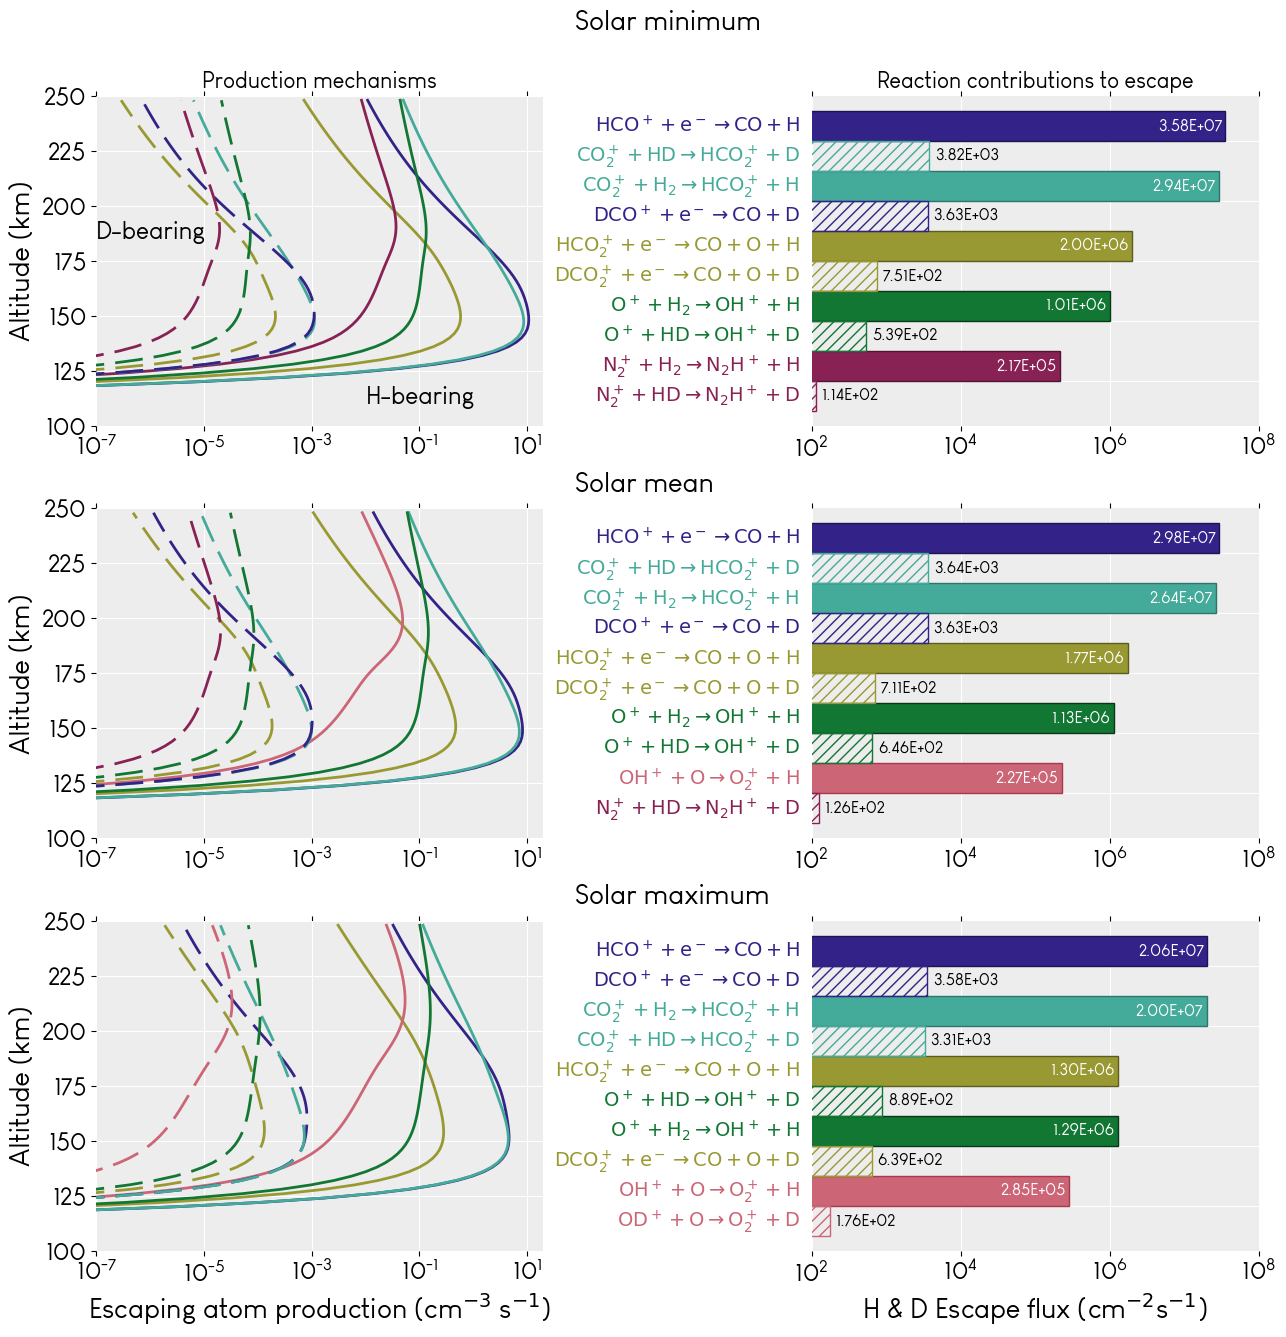

In [116]:
function plot_top5_lineandbar(total_dfs_H, total_dfs_D, by_alt_dfs_H, by_alt_dfs_D, savepath; nrow=3, ncol=2,
                              lowerlim=1e-5, upperlim=1, coltitle=["Solar minimum", "Solar mean", "Solar maximum"], 
                              h=0.1, w=0.1, title_y=[1.2, 1.05, 1.05]) 
    #=
    Input:
        sp: H or D usually
        total_dfs: Array of dataframes of total fluxes by reaction
        by_alt_dfs: Array of dataframes containing production profiles by altitude and by reaction
    Output: 
        Plot of the production profiles of the 5 reactions that produce the most flux
        of hot H and D.
    =#
    
    # Generate colors
    colordf = DataFrame(XLSX.readtable("IMPORTANT_RXN_COLORS.xlsx", "Sheet1"));

    # make labels not suck
    format_scin(n) = @sprintf "%.2E" n
    
    rcParams = PyCall.PyDict(matplotlib."rcParams")
    rcParams["font.sans-serif"] = ["Louis George Caf?"]
    rcParams["font.monospace"] = ["FreeMono"]
    rcParams["font.size"] = 18
    rcParams["axes.labelsize"]= 20
    rcParams["xtick.labelsize"] = 18
    rcParams["ytick.labelsize"] = 18
    
    
    # Set up the figure dimensions
    npanel = nrow > ncol ? nrow : ncol 

    fig, ax = subplots(nrow, ncol, figsize=(7.5*ncol, 5*nrow))
    subplots_adjust(wspace=w, hspace=h)
    
    println(size(ax))
    
    # SET UP THE REACTION RATE SET -----------------------------------------------------
  
    # all panels
    for i in 1:npanel # technically over rows
        plot_bg(ax[i, 1])
        ax[i, 1].set_ylabel("Altitude (km)")
        ax[i, 1].text(1.07, title_y[i], coltitle[i], transform=ax[i, 1].transAxes, size=20)
        ax[i, 1].set_xlim(lowerlim[i], upperlim[i]) # H plot limits
        ax[i, 1].tick_params(which="both", labeltop=false, labelbottom=true, top=true)
        ax[i, 1].set_ylim(100, 250)
        ax[i, 1].set_xscale("log")
    end
    ax[1, 1].set_title("Production mechanisms", size=16)
    ax[nrow, 1].set_xlabel(L"Escaping atom production (cm$^{-3}$ s$^{-1}$)")
    
    # get the reaction strings for the top 5 reactions of each panel
    top5_rxn_strs_H = Dict([s=>total_dfs_H[s].Rxn[1:5] for s in collect(1:npanel)]) 
    top5_rxn_strs_D = Dict([s=>total_dfs_D[s].Rxn[1:5] for s in collect(1:npanel)])
    
    # color set
    # H is first column, D second column
    H_colororder = [[], [], []]
    H_colororder_dark = [[], [], []]
    D_colororder = [[], [], []]
    D_colororder_dark = [[], [], []]
    for s in collect(1:npanel)
        # println("Panel $(s): $(top5_rxn_strs_H[s]), $(top5_rxn_strs_D[s])")
    
        # Plot the H reactions
        for row in eachrow(total_dfs_H[s])[1:5]
            thiscol = colordf[in([row.Rxn]).(colordf."H reaction"), :]."Color"[1]
            push!(H_colororder[s], thiscol)
            push!(H_colororder_dark[s], colordf[in([row.Rxn]).(colordf."H reaction"), :]."Darker"[1])
            ax[s, 1].plot(by_alt_dfs_H[s][!, row.Rxn], plot_grid, label=row.Rxn, linewidth=2, color=thiscol)
        end
        # And the D reactions
        for row in eachrow(total_dfs_D[s])[1:5]
            thiscol = colordf[in([row.Rxn]).(colordf."D reaction"), :]."Color"[1]
            thiscol_dark = colordf[in([row.Rxn]).(colordf."D reaction"), :]."Darker"[1]
            push!(D_colororder[s], thiscol)
            push!(D_colororder_dark[s], thiscol_dark)
            
            ax[s, 1].plot(by_alt_dfs_D[s][!, row.Rxn], plot_grid, label=row.Rxn, linewidth=2, linestyle=(0, (10,4)),
                     mfc="black", mec="black", color=thiscol)
        end
    end
    
    println(H_colororder)
    
    
    rcParams["hatch.linewidth"] = 1
    rcParams["hatch.color"] = "magenta"
    # NOW DO THE BAR CHART SET -------------------------------------------------------------------------
    for s in 1:npanel

        # Make ticklabels
        H_ticklbls = ["$(string_to_latexstr(H_i))" for H_i in total_dfs_H[s][1:5, :].Rxn]
        D_ticklbls = ["$(string_to_latexstr(D_i))" for D_i in total_dfs_D[s][1:5, :].Rxn]
        
        # basics
        plot_bg(ax[s, 2])
        ax[s, 2].tick_params(top=true, left=false, labelleft=false)
        ax[s, 2].set_xlim(1e2, 1e8)
        ax[s, 2].set_xscale("log")
        ax[s, 2].invert_yaxis()
        
        # Bars 
        barw=0.5
        ax[s, 2].barh(collect(1:5), total_dfs_H[s][1:5, :].Value, height=-barw, color=H_colororder[s], align="edge", zorder=10, edgecolor=H_colororder_dark[s])
        ax[s, 2].barh(collect(1:5), total_dfs_D[s][1:5, :].Value, height=barw, color=D_colororder[s],  fill=false, #facecolor=D_colororder[s],  #
                      align="edge", zorder=10, hatch="///", edgecolor=D_colororder[s])
        
        # Values
        for (i, f) in enumerate(total_dfs_H[s][1:5, :].Value)
            ax[s, 2].text(f*0.9, i-barw/2, "$(format_scin(f))", ha="right", va="center", color="white", size=12, zorder=15)
        end
        for (i, f) in enumerate(total_dfs_D[s][1:5, :].Value)
            ax[s, 2].text(f*1.2, i+barw/2, "$(format_scin(f))", ha="left", va="center", color="black", size=12, zorder=15)
        end
        
        # Tick labels, but manually, to make coloring better
        x = 7e1
        for y in 1:5
            ax[s, 2].text(x, y - 0.15, H_ticklbls[y], color=H_colororder[s][y], fontsize=14, ha="right")
            ax[s, 2].text(x, y + 0.35, D_ticklbls[y], color=D_colororder[s][y], fontsize=14, ha="right")
        end
        
    end
    
    ax[1, 2].set_title("Reaction contributions to escape", size=16)
    ax[nrow, 2].set_xlabel(L"H & D Escape flux (cm$^{-2}$s$^{-1}$)")
    
    # Label H and D
    ax[1,1].text(1e-7, 185, "D-bearing")
    ax[1,1].text(1e-2, 110, "H-bearing")
    
    savefig(savepath*"hot_mechanisms_DETAILED.pdf", format="pdf", bbox_inches="tight", dpi=300)
    show()
end

plot_top5_lineandbar([total_hot_H_min, total_hot_H_mean, total_hot_H_max], [total_hot_D_min, total_hot_D_mean, total_hot_D_max], 
                     [H_prod_by_alt_min_df, H_prod_by_alt_mean_df, H_prod_by_alt_max_df], 
                     [D_prod_by_alt_min_df, D_prod_by_alt_mean_df, D_prod_by_alt_max_df], all_result_plot_folder; nrow=3, ncol=2,
                     lowerlim=[1e-7,1e-7,1e-7], upperlim=[20,20,20], w=0.6, h=0.25,
                     coltitle=["Solar minimum", "Solar mean", "Solar maximum"])

# Water loss plots

In [117]:
function h2olost(cur_h2o; DHnow=5.5, DH0=1, f=0.001)
    #=
    Calculates water lost, given:

    cur_h2o: current water inventory. Can be in whatever unit you like, m GEL common. can be vector
    DHnow: present day atmospheric D/H in water
    DH0: ancient Mars atmospheric D/H in water
    f: fractionation factor 
    =#
    return cur_h2o .* ((DHnow/DH0)^(1/(1-f)) - 1)
end

function required_flux(total_water, time)
    #=
    total_water: total water loss in m GEL.
    time: time in By to lose water
    
    returns required escape rate in #/cm^2/s
    =#
    @assert 0 <= total_water <= 1000
    @assert 0 <= time <= 4.5
    
    time_in_sec = time * 1e9 * 3.154e7
 
    return GEL_to_molecule(total_water, "H") / time_in_sec

end


function plot_water_loss(fvec; cur_water=collect(20:30), DHnow=5.5, DH0=1.275, extraf=nothing, lab=["Solar min", "Solar mean", "Solar max"], extraflab="")
    #=
    Plot water loss vs. current water inventory estimate.
    Accounts for fractionation factor results and also plots a line
    according to the D/H ratio used. 

    f_therm: mean fractionation factor for only thermal escape
    f_both: mean fractionation factor for both thermal + nonthermal
    f_therm_range: min and max fractionation factor for thermal escape
    f_both_range: min and max fractionation factor for all types of escape
    =#
    # set up the domain 
    

    # make plot look nice
    fig = figure(figsize=(7,5))
    rcParams = PyCall.PyDict(matplotlib."rcParams")
    rcParams["font.family"] = "sans-serif"
    rcParams["font.sans-serif"] = "Louis George Caf?"
    rcParams["font.monospace"] = "FreeMono"
    rcParams["font.size"] = 18
    rcParams["axes.labelsize"] = 20
    rcParams["xtick.labelsize"] = 18
    rcParams["ytick.labelsize"] = 18
    ax = gca()
    plot_bg(ax)
    xlabel("Current exchangeable water (m GEL)")
    ylabel("Total water loss (m GEL)")

    # plot 
    if extraf != nothing
        blues = get_grad_colors(length(fvec)+length(extraf), "Blues", strt=0.4)
    else 
        blues = get_grad_colors(length(fvec), "Blues", strt=0.4)
    end

    # calculate and plot the loss for mean f
    loss_vecs = Array{Float64}(undef, length(fvec), length(cur_water))
    for fi in 1:length(fvec)
        # loss_vecs[fi, :] = h2olost(cur_water; DHnow, DH0, f=fvec[fi])
        ax.plot(cur_water, h2olost(cur_water; DHnow, DH0, f=fvec[fi]), zorder=2, color=blues[fi, :], marker="D", label=lab[fi])
    end

    for fi in 1:length(fvec)
        
    end
    
    if extraf != nothing
        i = 1
        for f in extraf
            ax.plot(cur_water, h2olost(cur_water; DHnow, DH0, f), color=blues[length(fvec)+i, :], label=extraflab)
            i += 1
        end
    end
    # ax.set_yscale("log")
    ax.legend()
    show()
end

function plot_simple_water_loss(cur_h2o, f_to_plot, savepath; dh=5.5, dh0=1, yl=500, fill_x=[0,0])
    #=
    Plot just the Rayleigh distillation equation, no fractionation factor results.
    For demonstration purposes. Bruce asked for this. Not in the paper.

    cur_h2o: assumed water inventory in m GEL.
    =#
    farray = range(0.01, stop=1, length=100)

    l1 = [h2olost(cur_h2o; DHnow=dh, DH0=dh0, f) for f in farray]

    # make plot
    fig = figure(figsize=(8,6))

    # style.use("default")
    rc("text", usetex=false)
    rcParams = PyCall.PyDict(matplotlib."rcParams")
    rcParams["font.family"] = "sans-serif"
    rcParams["font.sans-serif"] = "Louis George Caf?"
    rcParams["font.monospace"] = "FreeMono"
    rcParams["font.size"] = 22
    rcParams["axes.labelsize"] = 24
    rcParams["xtick.labelsize"] = 22
    rcParams["ytick.labelsize"] = 22

    ax = gca()
    plot_bg(ax)

    xlabel(L"Fractionation factor $f$")
    ylabel("Total water lost (m GEL)")

    # plot things
    ax.semilogx(farray, l1, zorder=2, color="cornflowerblue")
    water_lost = [h2olost(cur_h2o; DHnow=dh, DH0=dh0, f) for f in f_to_plot]
    ax.scatter(f_to_plot, water_lost, color="#F24A72", zorder=10)
    
    ax.text(f_to_plot[1], 300, "Water loss between\n$(round(water_lost[1])) and $(round(water_lost[2])) m GEL", fontsize=20)
    ax.plot([f_to_plot[1], f_to_plot[1]+f_to_plot[1]*0.1], [water_lost[1]+20, 290], color="black")
    ax.plot([f_to_plot[2], f_to_plot[2]+f_to_plot[2]*0.3], [water_lost[2]+20, 290], color="black")
    
    ax.text(1e-2, 800, "D/H today: $(dh) x SMOW", color="#333333")
    ax.text(1e-2, 700, "Primordial D/H: $(dh0) x SMOW", color="#333333")
    ax.text(1e-2, 600, "Water today: $(cur_h2o) m GEL", color="#333333")
    ylim(0, yl)
    show()
    savefig(savepath*"waterloss_vs_f.pdf", format="pdf", bbox_inches="tight", dpi=300)
end

plot_simple_water_loss (generic function with 1 method)

In [118]:
w = 150
y = 4.5
reqd_rate = required_flux(w, y)
total_loss_reqd = GEL_to_molecule(w, "H")
println("Losing $(w) m GEL water over $(y) years: $(round(reqd_rate, sigdigits=2)) #/cm^2/s")
println("Total molecules of H lost per cm^2 to lose $(w) m GEL water: $(round(total_loss_reqd, sigdigits=2)) #/cm^2")

Losing 150 m GEL water over 4.5 years: 7.0e9 #/cm^2/s
Total molecules of H lost per cm^2 to lose 150 m GEL water: 1.0000000000000002e27 #/cm^2


In [119]:
SA_mars = 1.4e18 # cm^2
t = 0:1e6:4.5e9
t_sec = 0:1e12:1.2616e17

# cosntant flux 
flux_today = 11e8 # #/cm^2/s
flux = flux_today * ones(size(t_sec));

loss_mavenrate_percm2 = flux_today * (4.5e9*3.154e7) # #/cm^2

println("Total H lost if flux rate is constant per area: $(loss_mavenrate_percm2) #/cm^2")
println("Total H lost if flux rate is constant over whole planet: $(loss_mavenrate_percm2 * SA_mars) molecules")

Total H lost if flux rate is constant per area: 1.56123e26 #/cm^2
Total H lost if flux rate is constant over whole planet: 2.185722e44 molecules


In [120]:
#gaussian flux
flux_gauss(T) = @. 1e11 * exp(-((T )^2)/(2 * (4.2e16)^2)); # t needs to be in seconds
loss_gaussflux_percm2 = quadgk(flux_gauss, 0, 1.2616e17)[1]

println("Total H lost if flux rate is a gaussian, per area: $(loss_gaussflux_percm2) #/cm^2")
println("Total H lost if flux rate is a gaussian, over whole planet: $(loss_gaussflux_percm2 * SA_mars) molecules")

Total H lost if flux rate is a gaussian, per area: 5.249884599611405e27 #/cm^2
Total H lost if flux rate is a gaussian, over whole planet: 7.349838439455967e45 molecules


In [15]:
maxt= 1.2616e17

1.2616e17

## basic f plot

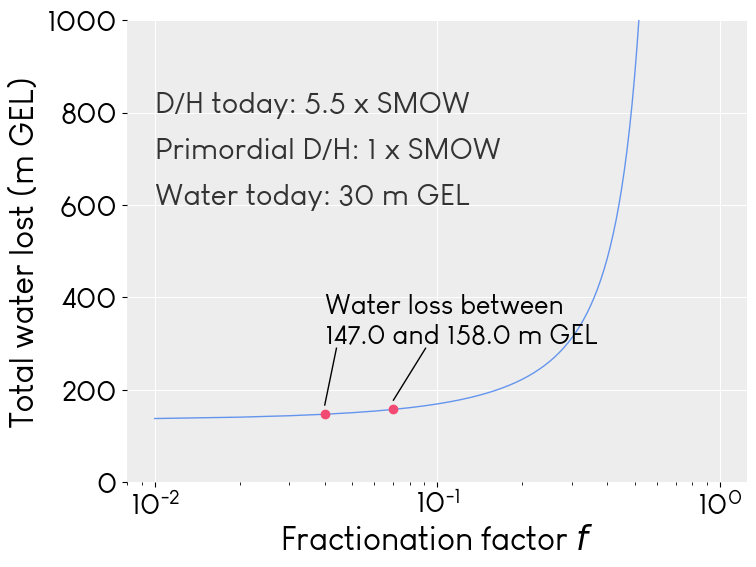

In [121]:
plot_simple_water_loss(30, [0.04, 0.07], all_result_plot_folder; dh=5.5, yl=1000)

# New plots for last fig

In [122]:
function water_depletion(t, flux, Winitial, Wfinal)
    
    W_i_in_Hatoms = GEL_to_molecule(Winitial, "H")
    W_f_in_Hatoms = GEL_to_molecule(Wfinal, "H")
    # println(W_i_in_Hatoms)
    t_in_sec = t * 1e9 * 3.154e7
    
    current_amount_atoms = W_i_in_Hatoms - (flux * t_in_sec) 
    
    return molec_to_GEL(current_amount_atoms, "H") 
end

water_multiplier(Rnow, Rinitial, f) = (Rnow/Rinitial)^(1/(1-f)) - 1

initial_water(Wnow, m) = Wnow * m

initial_water_per_maven(phi, t, curh2o) = molec_to_GEL(phi*(t * 1e9 * 3.154e7) + GEL_to_molecule(curh2o, "H"), "H")

initial_water_per_maven (generic function with 1 method)

In [123]:
function label_angle(xdata, ydata)
    # compute angle in raw data coordinates (no manual transforms)
    dy = ydata[end] - ydata[1]
    dx = xdata[end] - xdata[1]
    angle = atand(dy, dx)
    return angle
end

label_angle (generic function with 1 method)

## DH and f contour plot

In [124]:
function by_to_sec(y)
    return y*1e9*3.154e7
end

function contour(Wn; f=nothing, DH=nothing, Wi=nothing, Φ=nothing, quiet=false)
    t = by_to_sec(4.5)
    Wn_Hatoms = GEL_to_molecule(Wn, "H")
    DH_i = 1
    
    returnable = Dict()
    
    # Φ and Wi block
    if (Wi != nothing) & (Φ != nothing)
        throw("Error! specify only one of Wi and Φ at a time")
    elseif (f == nothing) & (DH == nothing)
        throw("Error! specify one and only one of Wi or Φ")
    elseif (Wi != nothing)
        Wi_Hatoms = GEL_to_molecule(Wi, "H")
        Φ = (Wi_Hatoms - Wn_Hatoms) / t
    elseif (Φ != nothing)
        Wi_Hatoms = Φ * t + Wn_Hatoms
    end
    
    returnable["phi"] = Φ
    returnable["Wi"] = molec_to_GEL(Wi_Hatoms, "H")
    
    # f and D/H block
    if (f != nothing) & (DH != nothing)
        throw("Error! specify only one of f and DH at a time")
    elseif (f == nothing) & (DH == nothing)
        throw("Error! specify one and only one of f or DH")
    elseif (f != nothing)
        DH = DH_i .* (Wi_Hatoms ./ Wn_Hatoms) .^ (1 .- f)
        if quiet != true
            println("received f vector, returning vector of current D/H")
        end
        # return DH
    elseif (DH != nothing)
        if quiet != true
            println("received current D/H vector, returning vector of f")
        end
        f = 1 .- log(DH ./ DH_i) ./ log(Wi_Hatoms ./ Wn_Hatoms)
        # return f
    end
    
    returnable["DH"] = DH
    returnable["f"] = f
    
    return returnable
        
end



contour (generic function with 1 method)

In [125]:
# style.use("default")
rc("text", usetex=false)
rcParams = PyCall.PyDict(matplotlib."rcParams")
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = "Louis George Caf?"#"Cabin"#
rcParams["font.monospace"] = "FreeMono"
rcParams["font.size"] = 16
rcParams["axes.labelsize"] = 18
rcParams["xtick.labelsize"] = 16
rcParams["ytick.labelsize"] = 16


16

In [126]:
transforms = matplotlib.transforms

PyObject <module 'matplotlib.transforms' from '/home/emc/.julia/conda/3/lib/python3.8/site-packages/matplotlib/transforms.py'>

## required escape rates and water loss

In [127]:
function orig_water_vs_phi(ax, water_loss_vector; bluecolors=get_colors(length(water_loss_vector), "Blues"; strt=0.2), red="xkcd:dull red", gray="xkcd:medium grey")
    

    req_rates = [required_flux(w, 4.5) for w in water_loss_vector]
    maven_rates = collect(1e8:5e7:11e8)
    implied_loss_from_maven = [molec_to_GEL(r * 4.5 * 1e9 * 3.154e7, "H") for r in maven_rates]

    plot_bg(ax)
    ax.set_title("Water loss as a function of average escape rate", fontsize=22)
    ax.set_xlabel(L"$\phi_H$ time-averaged escape rate (cm$^{-2}$s$^{-1}$)")
    ax.set_ylabel("Total water lost (m GEL)")
    ax.set_xscale("log")
    ax.set_xlim(1e8,1e11)
    ax.set_ylim(-30, 1000)

    # Plot
    ax.plot(req_rates, water_loss_vector, color="black", linewidth=2, linestyle="--", zorder=3)
    ax.plot(maven_rates, implied_loss_from_maven, color=red, linewidth=3, zorder=5)
    

    ax.text(0.01, 0.55, "Geomorphology", fontweight="bold", transform=ax.transAxes, color=bluecolors[end, :])
    ax.text(0.27, 0.52, L"$\uparrow$", fontweight="bold", fontsize=48, transform=ax.transAxes, color=bluecolors[end, :])
    ax.fill_between(1e8:1e8:1e11, y1=500, y2=1000, color=bluecolors[end, :], alpha=0.4, zorder=2)

    # gap text
    ax.text(0.12, 0.43, L"$\uparrow$", fontsize=36, transform=ax.transAxes)
    ax.text(0.12, 0.22, L"$\downarrow$", fontsize=36, transform=ax.transAxes)
    ax.text(0.10, 0.35, "Big Gap!", fontweight="bold", color="black", transform=ax.transAxes)

    # text about large loss
    ax.text(0.65, 0.5, L"$\uparrow$", fontsize=36, color="black", transform=ax.transAxes, rotation=-30)
    ax.text(0.37, 0.34, "Greater loss requires\nlarger escape rates\nthan observed today", color="black", transform=ax.transAxes)

    # atm 
    ax.text(0.01, 0.15, "Atmospheric modeling", fontweight="bold", transform=ax.transAxes, color=bluecolors[2, :])
    ax.text(0.38, 0.14, L"$\uparrow$", fontsize=36,fontweight="bold", transform=ax.transAxes, color=bluecolors[2, :])
    ax.text(0.38, 0.13, L"$\downarrow$", fontsize=36,fontweight="bold", transform=ax.transAxes, color=bluecolors[2, :])
    ax.fill_between(1e8:1e8:1e11, y1=100, y2=200, color=bluecolors[2, :], alpha=0.4, zorder=2)

    # values which are too low
    nope = "xkcd:coffee"
    ax.text(1, 0.05, "Unsupported in literature", transform=ax.transAxes, color=nope, fontsize=16, ha="right")
    ax.text(0.56, 0.05, L"$\uparrow$", fontsize=36,fontweight="bold", transform=ax.transAxes, color=nope)
    ax.text(0.56, 0.03, L"$\downarrow$", fontsize=36,fontweight="bold", transform=ax.transAxes, color=nope)
    ax.fill_between(1e8:1e8:1e11, y1=0, y2=100, color="xkcd:coffee", alpha=0.3, zorder=2)

    # maven 
    ax.text(0.01, 0.07, "Inferred from MAVEN data", fontsize=14, fontweight="bold", color=red, transform=ax.transAxes)
    # ax.plot([3e8, 3e8], [30,10], color=red, linewidth=1)
end

function DH_f_tradeoff_plot(ax, Wi_vec, f_vec, today_GEL; thiswork_f = [minimum(f_tnt), maximum(f_tnt)],
                             bluecolors=get_colors(length(Wi_vec), "Blues"; strt=0.2), red="xkcd:dull red", gray="xkcd:medium gray")
    
    plot_bg(ax)
    ax.set_yscale("log")
    ax.set_xlabel("Present day D/H of exchangeable reservoir (SMOW)")
    ax.set_ylabel("Fractionation Factor")
    ax.set_xlim(0.5, 18)
    ax.set_ylim(2e-3, 1.2)
    ax.set_xticks(collect(0:2:18))

    halign_vec = ["right", "center", "left", "center", "right", ]
    
    for i in 1:length(Wi_vec)
        c = i == 1 ? red : bluecolors[i, :]
        
        # Plot and such
        returndict = contour(today_GEL; f=f_vec, Wi = Wi_vec[i], quiet=true)
        ax.plot(returndict["DH"], returndict["f"], label="$(Wi_vec[i]) m GEL", color=c, zorder=5)

        # text label
        ang = label_angle((returndict["DH"][5:-1:1]), returndict["f"][5:-1:1])
        thelbl = "$(Wi_vec[i]-today_GEL) m GEL"
        thelbl = "$(thelbl)\n" * L"$\phi_H$="*"$(format_scin(returndict["phi"]))\n"

        if i > 1 # Handle text for MAVEN seprately
            ax.text(returndict["DH"][1], 0.005, thelbl, color=c, rotation_mode="anchor", ha=halign_vec[i], va="top", fontsize=16)
        end
        
        if i == 1
            ax.text(0.07, 0.22, thelbl, transform=ax.transAxes, ha=halign_vec[i], va="top", fontsize=16, color=c)
            ax.text(0.07, 0.1, "highest escape\nobs. by MAVEN", transform=ax.transAxes, fontsize=12, fontweight="light", color=c, ha=halign_vec[i], va="top")
        end
    end
    
    # Yung's value
    ax.axhline(0.32, color="#404040", linewidth=1, linestyle="--")
    ax.text(15, 0.33, "Yung+1988", color="#404040", fontsize=14)
    
    # DH and f boxes
    ax.fill_between([4, 6], y1=-3, y2=3, color=gray, alpha=0.3, zorder=2)
    ax.fill_between([-50,20], y1=thiswork_f[1], y2=thiswork_f[2], color=gray, alpha=0.3, zorder=2)

    ax.text(11, 0.008, "Low end of likely loss\nfrom geomorphology", ha="left", fontsize=16, color=bluecolors[end, :])
    # ax.plot([12.1, 12.1], [0.115, 0.175], color="black")
    ax.text(0.48, (thiswork_f[2]+thiswork_f[1])/2, L"Preferred range of $f$, this work", fontsize=14, va="center", ha="left", 
            transform=transforms.blended_transform_factory(ax.transAxes, ax.transData))
    ax.text(7, thiswork_f[2], L"$\uparrow$", fontsize=30, va="top", color="#262626")
    ax.text(7, thiswork_f[1], L"$\downarrow$", fontsize=30, fontweight="bold", color="#262626")
    
    ax.text(5, 0.88, "Observed\nD/H", fontsize=14, va="top", ha="center")
    ax.text(3.6, 0.88, L"$\longleftarrow$", fontsize=42, color="#262626")
    ax.text(3.6, 0.88, L"$\longrightarrow$", fontsize=42, color="#262626")
    
    ax.set_title("Water loss as a function of pairs of D/H and f", fontsize=22)
end

DH_f_tradeoff_plot (generic function with 1 method)

## Together in one figure

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


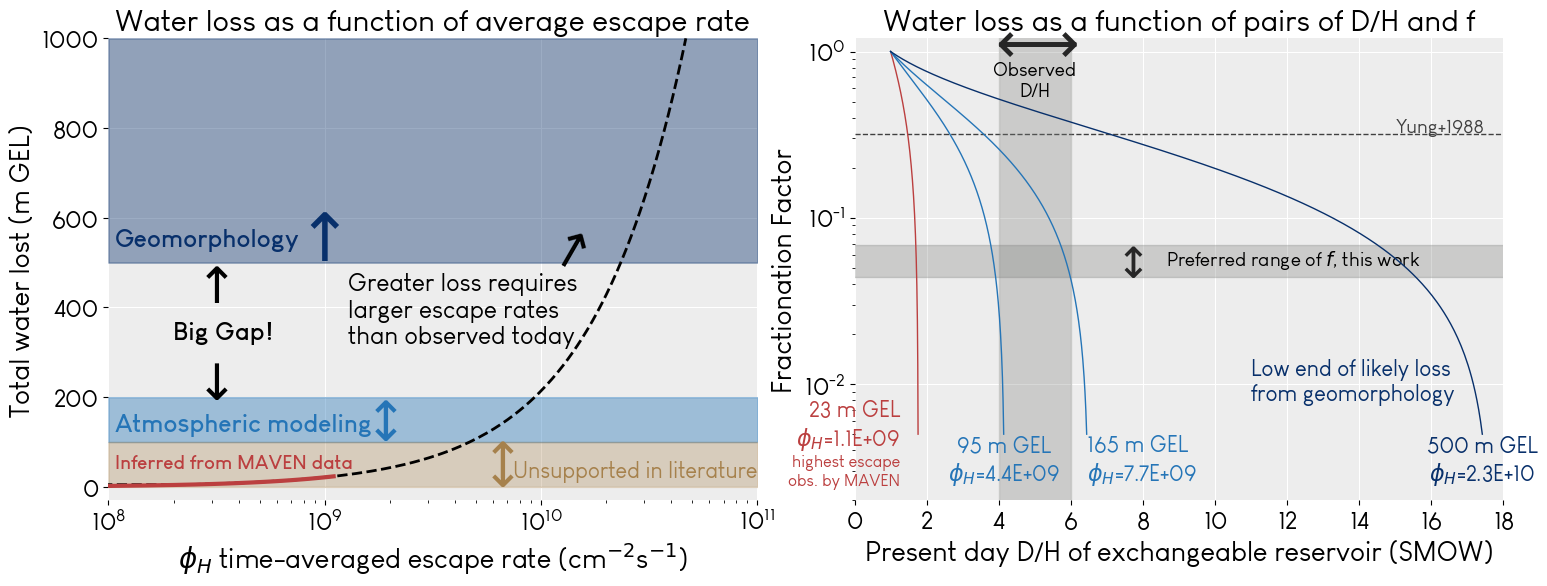

In [128]:
WL_vec = collect(0:5:1000) # first ax
# second ax
Wi_vec = [53, 125, 195, 530] 
f_vec = 0.005:0.001:1

bluecolors = get_colors(length(Wi_vec), "Blues"; strt=0.2)
bluecolors[2, :] .= bluecolors[3, :]

rcParams = PyDict(matplotlib."rcParams")

rcParams["font.sans-serif"] = ["Louis George Caf?"]
rcParams["font.monospace"] = ["FreeMono"]
rcParams["font.size"] = 18
rcParams["axes.labelsize"]= 20
rcParams["xtick.labelsize"] = 18
rcParams["ytick.labelsize"] = 18

fig, axes = subplots(1, 2, figsize=(18,6))
subplots_adjust(wspace=0.15)
orig_water_vs_phi(axes[1], WL_vec; bluecolors=bluecolors)
DH_f_tradeoff_plot(axes[2], Wi_vec, f_vec, 30; bluecolors=bluecolors)
savefig(all_result_plot_folder*"/waterloss.pdf", format="pdf", bbox_inches="tight", dpi=300)
show()



## Modified for an MRO review paper

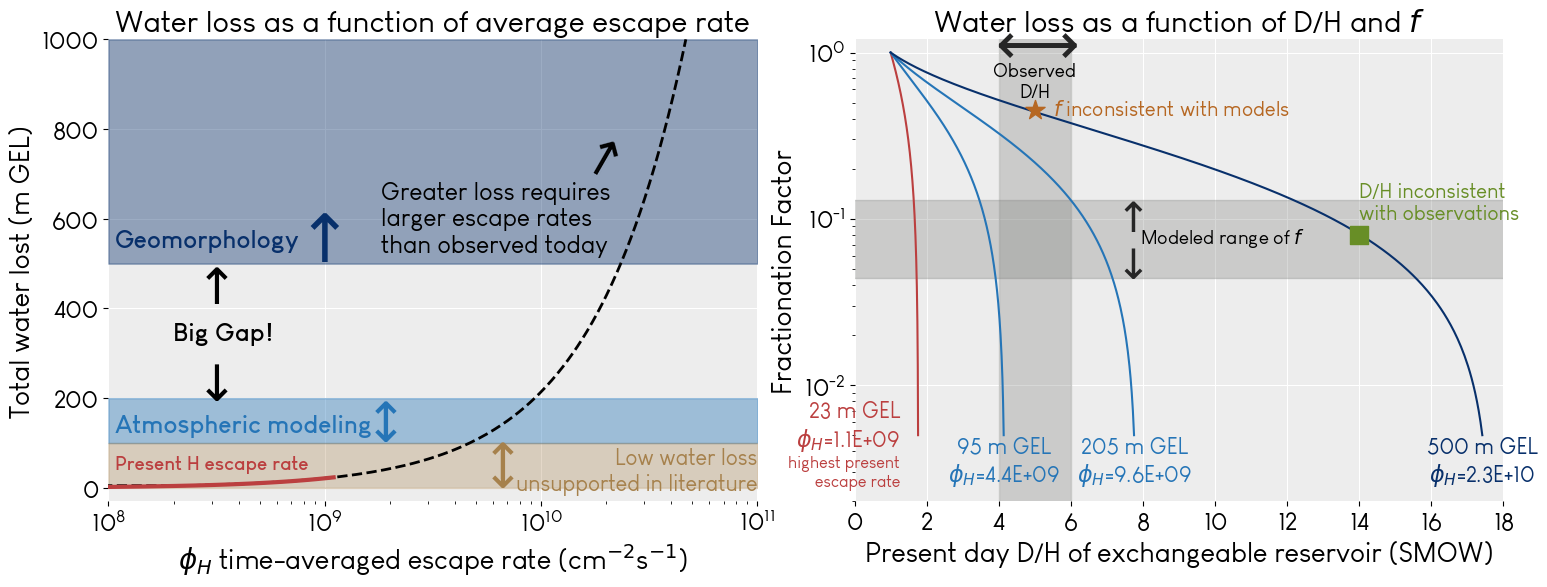

In [137]:
function orig_water_vs_phi_MRO(ax, water_loss_vector; bluecolors=get_colors(length(water_loss_vector), "Blues"; strt=0.2), red="xkcd:dull red", gray="xkcd:medium grey")
    

    req_rates = [required_flux(w, 4.5) for w in water_loss_vector]
    maven_rates = collect(1e8:5e7:11e8)
    implied_loss_from_maven = [molec_to_GEL(r * 4.5 * 1e9 * 3.154e7, "H") for r in maven_rates]

    plot_bg(ax)
    ax.set_title("Water loss as a function of average escape rate", fontsize=22)
    ax.set_xlabel(L"$\phi_H$ time-averaged escape rate (cm$^{-2}$s$^{-1}$)")
    ax.set_ylabel("Total water lost (m GEL)")
    ax.set_xscale("log")
    ax.set_xlim(1e8,1e11)
    ax.set_ylim(-30, 1000)

    # Plot
    ax.plot(req_rates, water_loss_vector, color="black", linewidth=2, linestyle="--", zorder=3)
    ax.plot(maven_rates, implied_loss_from_maven, color=red, linewidth=3, zorder=5)
    

    ax.text(0.01, 0.55, "Geomorphology", fontweight="bold", transform=ax.transAxes, color=bluecolors[end, :])
    ax.text(0.27, 0.52, L"$\uparrow$", fontweight="bold", fontsize=48, transform=ax.transAxes, color=bluecolors[end, :])
    ax.fill_between(1e8:1e8:1e11, y1=500, y2=1000, color=bluecolors[end, :], alpha=0.4, zorder=2)

    # gap text
    ax.text(0.12, 0.43, L"$\uparrow$", fontsize=36, transform=ax.transAxes)
    ax.text(0.12, 0.22, L"$\downarrow$", fontsize=36, transform=ax.transAxes)
    ax.text(0.10, 0.35, "Big Gap!", fontweight="bold", color="black", transform=ax.transAxes)

    # text about large loss
    ax.text(0.7, 0.7, L"$\uparrow$", fontsize=36, color="black", transform=ax.transAxes, rotation=-30)
    ax.text(0.42, 0.54, "Greater loss requires\nlarger escape rates\nthan observed today", color="black", transform=ax.transAxes)

    # atm 
    ax.text(0.01, 0.15, "Atmospheric modeling", fontweight="bold", transform=ax.transAxes, color=bluecolors[2, :])
    ax.text(0.38, 0.14, L"$\uparrow$", fontsize=36,fontweight="bold", transform=ax.transAxes, color=bluecolors[2, :])
    ax.text(0.38, 0.13, L"$\downarrow$", fontsize=36,fontweight="bold", transform=ax.transAxes, color=bluecolors[2, :])
    ax.fill_between(1e8:1e8:1e11, y1=100, y2=200, color=bluecolors[2, :], alpha=0.4, zorder=2)

    # values which are too low
    nope = "xkcd:coffee"
    ax.text(1, 0.025, "Low water loss\nunsupported in literature", transform=ax.transAxes, color=nope, fontsize=16, ha="right")
    ax.text(0.56, 0.05, L"$\uparrow$", fontsize=36,fontweight="bold", transform=ax.transAxes, color=nope)
    ax.text(0.56, 0.03, L"$\downarrow$", fontsize=36,fontweight="bold", transform=ax.transAxes, color=nope)
    ax.fill_between(1e8:1e8:1e11, y1=0, y2=100, color="xkcd:coffee", alpha=0.3, zorder=2)

    # maven 
    ax.text(0.01, 0.07, "Present H escape rate", fontsize=14, fontweight="bold", color=red, transform=ax.transAxes)
    # ax.plot([3e8, 3e8], [30,10], color=red, linewidth=1)
end

function DH_f_tradeoff_plot_MRO(ax, Wi_vec, f_vec, today_GEL; thiswork_f = [minimum(f_tnt), maximum(f_tnt)],
                             bluecolors=get_colors(length(Wi_vec), "Blues"; strt=0.2), red="xkcd:dull red", gray="xkcd:medium gray")
    
    plot_bg(ax)
    ax.set_yscale("log")
    ax.set_xlabel("Present day D/H of exchangeable reservoir (SMOW)")
    ax.set_ylabel("Fractionation Factor")
    ax.set_xlim(0.5, 18)
    ax.set_ylim(2e-3, 1.2)
    ax.set_xticks(collect(0:2:18))

    halign_vec = ["right", "center", "center", "center", "right", ]
    
    for i in 1:length(Wi_vec)
        c = i == 1 ? red : bluecolors[i, :]
        
        # Plot and such
        returndict = contour(today_GEL; f=f_vec, Wi = Wi_vec[i], quiet=true)
        ax.plot(returndict["DH"], returndict["f"], label="$(Wi_vec[i]) m GEL", color=c, zorder=5)

        # text label
        ang = label_angle((returndict["DH"][5:-1:1]), returndict["f"][5:-1:1])
        thelbl = "$(Wi_vec[i]-today_GEL) m GEL"
        thelbl = "$(thelbl)\n" * L"$\phi_H$="*"$(format_scin(returndict["phi"]))\n"

        if i > 1 # Handle text for MAVEN seprately
            ax.text(returndict["DH"][1], 0.005, thelbl, color=c, rotation_mode="anchor", ha=halign_vec[i], va="top", fontsize=16)
        end
        
        if i == 1
            ax.text(0.07, 0.22, thelbl, transform=ax.transAxes, ha=halign_vec[i], va="top", fontsize=16, color=c)
            ax.text(0.07, 0.1, "highest present\nescape rate", transform=ax.transAxes, fontsize=12, fontweight="light", color=c, ha=halign_vec[i], va="top")
        end
    end
    
    
    maxf = 0.13
    
    # DH and f boxes
    ax.fill_between([4, 6], y1=-3, y2=3, color=gray, alpha=0.3, zorder=2)
    ax.fill_between([-50,20], y1=thiswork_f[1], y2=maxf, color=gray, alpha=0.3, zorder=2)
    ax.text(0.44, (maxf+thiswork_f[1])/2-0.01, "Modeled range of "*L"$f$", fontsize=14, va="center", ha="left", 
                  transform=transforms.blended_transform_factory(ax.transAxes, ax.transData))
    ax.text(7, maxf, L"$\uparrow$", fontsize=30, va="top", color="#262626")
    ax.text(7, thiswork_f[1], L"$\downarrow$", fontsize=30, fontweight="bold", color="#262626")
    
    ax.text(5, 0.88, "Observed\nD/H", fontsize=14, va="top", ha="center")
    ax.text(3.6, 0.88, L"$\longleftarrow$", fontsize=42, color="#262626")
    ax.text(3.6, 0.88, L"$\longrightarrow$", fontsize=42, color="#262626")
    
    ax.scatter(5, 0.45, marker="*", color="#B66722", s=210, zorder=6)
    ax.text(5.5, 0.42, L"$f$ inconsistent with models",   color="#B66722", fontsize=15)
    
    ax.scatter(14, 0.08, marker="s", color="#688E26", s=150, zorder=6)
    ax.text(14, 0.1, "D/H inconsistent \nwith observations", color="#688E26", fontsize=15)
    
    ax.set_title(L"Water loss as a function of D/H and $f$", fontsize=22)
end

WL_vec = collect(0:5:1000) # first ax
# second ax
Wi_vec = [53, 125, 235, 530] 
f_vec = 0.005:0.001:1

bluecolors = get_colors(length(Wi_vec), "Blues"; strt=0.2)
bluecolors[2, :] .= bluecolors[3, :]
# for L in 1:length(bluecolors)
#     println(bluecolors[L, :] *256)
#     println()
# end

rcParams = PyDict(matplotlib."rcParams")

rcParams["font.sans-serif"] = ["Louis George Caf?"]
rcParams["font.monospace"] = ["FreeMono"]
rcParams["font.size"] = 18
rcParams["axes.labelsize"]= 20
rcParams["xtick.labelsize"] = 18
rcParams["ytick.labelsize"] = 18

fig, axes = subplots(1, 2, figsize=(18,6))
subplots_adjust(wspace=0.15)
orig_water_vs_phi_MRO(axes[1], WL_vec; bluecolors=bluecolors)
DH_f_tradeoff_plot_MRO(axes[2], Wi_vec, f_vec, 30; bluecolors=bluecolors)
# savefig(all_result_plot_folder*"/waterloss.pdf", format="pdf", bbox_inches="tight", dpi=300)
show()


# Calculate column rate of all Jrates for printing in table

In [16]:
Jratelist_smean = format_Jrates(solarmean_folder*"active_rxns.xlsx", all_species, "Jratelist"; hot_atoms=true, ions_on=true)[1];
Jratedict_smean = Dict([j=>solarmean[j] for j in Jratelist_smean])

Dict{Symbol, Vector{Float64}} with 62 entries:
  :JHDOtoHplpOD => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0115…
  :JH2OtoOplpH2 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.2776…
  :JHDO2toOHpOD => [1.75257e-5, 1.7617e-5, 1.76944e-5, 1.776e-5, 1.78166e-5, 1.…
  :JH2toHplpH   => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  2.4717…
  :JH2OtoH2Opl  => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.1631…
  :JHDOtoHDpO1D => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.4033…
  :JCO2toCpOpO  => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  7.8777…
  :JCOtoCOpl    => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  9.0956…
  :JHDO2toHO2pD => [4.63517e-7, 4.6681e-7, 4.70018e-7, 4.7316e-7, 4.76255e-7, 4…
  :JH2toH2pl    => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  2.2245…
  :JN2toNplpN   => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.5309…
  :JO2toOpO1D   => [0.0, 0.0, 0.0, 0.0, 3.05277e-295, 9.59879e

In [17]:
col_Jrate_smean = Dict([k=>sum(Jratedict_smean[k] ./ dz) for k in keys(Jratedict_smean)])

Dict{Symbol, Float64} with 62 entries:
  :JCO2toCpO2   => 3.61945e-12
  :JH2OtoOplpH2 => 3.77807e-13
  :JHDO2toOHpOD => 1.12869e-8
  :JH2toHplpH   => 6.94035e-13
  :JH2OtoH2Opl  => 3.29585e-11
  :JHDOtoHDpO1D => 5.63826e-11
  :JCO2toCpOpO  => 2.22596e-14
  :JCOtoCOpl    => 2.59151e-11
  :JHDO2toHO2pD => 3.1272e-10
  :JH2toH2pl    => 6.24632e-12
  :JN2toNplpN   => 4.51502e-12
  :JO2toOpO1D   => 1.95765e-10
  :JCOtoCpO     => 2.44947e-12
  :JHDOtoHDOpl  => 3.29585e-11
  :JCOtoCpOpl   => 1.83989e-12
  :JHDOtoDplpOH => 2.9235e-12
  :JN2toN2pl    => 3.16395e-11
  :JO2toO2pl    => 1.1896e-11
  :JHDOtoODplpH => 6.41451e-12
  :JHO2toOHpO   => 6.94643e-8
  :JCOtoOpCpl   => 2.32376e-12
  :JNOtoNOpl    => 1.52654e-10
  :JCO2toCOpO   => 2.08284e-11
  :JHDOtoOplpHD => 3.77807e-13
  :JHDOtoDpOH   => 4.35668e-10
  ⋮             => ⋮

In [134]:
col_Jrate_smean[:JDtoDpl]

7.469195854138206e-12

In [135]:
col_Jrate_smean[:JDO2toODpO]

6.94643432724656e-8

In [138]:
for k in keys(col_Jrate_smean)
    if occursin("JHDto", string(k))
        println("$k: $(col_Jrate_smean[k])")
    end
end

JHDtoHpD: 3.776706512160235e-12
JHDtoHplpD: 6.940346919641013e-13
JHDtoDplpH: 6.940346919641013e-13
JHDtoHDpl: 6.246319127193753e-12


In [144]:
for k in keys(col_Jrate_smean)
    if occursin("JHDOto", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JHDOtoHDpO1D: 5.6e-11
JHDOtoHDOpl: 3.3e-11
JHDOtoDplpOH: 2.9e-12
JHDOtoODplpH: 6.4e-12
JHDOtoOplpHD: 3.8e-13
JHDOtoDpOH: 4.4e-10
JHDOtoHpOD: 4.4e-10
JHDOtoOHplpD: 6.4e-12
JHDOtoHpDpO: 0.0
JHDOtoHplpOD: 2.9e-12


In [145]:
for k in keys(col_Jrate_smean)
    if occursin("JHDO2to", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JHDO2toOHpOD: 1.1e-8
JHDO2toHO2pD: 3.1e-10
JHDO2toHDOpO1D: 0.0
JHDO2toDO2pH: 3.1e-10


In [141]:
for k in keys(col_Jrate_smean)
    if occursin("JODto", string(k))
        println("$k: $(col_Jrate_smean[k])")
    end
end

JODtoO1DpD: 1.592298814384418e-11
JODtoOpD: 1.1166980453152236e-9


## non-D rxns

In [19]:
for k in keys(col_Jrate_smean)
    if occursin("JCOto", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JCOtoCOpl: 2.6e-11
JCOtoCpO: 2.4e-12
JCOtoCpOpl: 1.8e-12
JCOtoOpCpl: 2.3e-12


In [20]:
for k in keys(col_Jrate_smean)
    if occursin("JCO2to", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JCO2toCpO2: 3.6e-12
JCO2toCpOpO: 2.2e-14
JCO2toCOpO: 2.1e-11
JCO2toOplpCO: 4.5e-12
JCO2toCO2pl: 5.6e-11
JCO2toCOpO1D: 1.0e-10
JCO2toCplpO2: 2.3e-12
JCO2toCOplpO: 3.0e-12


In [21]:
for k in keys(col_Jrate_smean)
    if occursin("JHto", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JHtoHpl: 7.5e-12


In [22]:
for k in keys(col_Jrate_smean)
    if occursin("JH2to", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JH2toHplpH: 6.9e-13
JH2toH2pl: 6.2e-12
JH2toHpH: 3.8e-12


In [23]:
for k in keys(col_Jrate_smean)
    if occursin("JH2Oto", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JH2OtoOplpH2: 3.8e-13
JH2OtoH2Opl: 3.3e-11
JH2OtoHpOH: 9.0e-10
JH2OtoHpHpO: 0.0
JH2OtoH2pO1D: 5.7e-11
JH2OtoOHplpH: 6.4e-12
JH2OtoHplpOH: 2.9e-12


In [24]:
for k in keys(col_Jrate_smean)
    if occursin("JH2O2to", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JH2O2toH2OpO1D: 0.0
JH2O2toOHpOH: 1.1e-8
JH2O2toHO2pH: 6.3e-10


In [25]:
for k in keys(col_Jrate_smean)
    if occursin("JHO2to", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JHO2toOHpO: 6.9e-8


In [26]:
for k in keys(col_Jrate_smean)
    if occursin("JN2to", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JN2toNplpN: 4.5e-12
JN2toN2pl: 3.2e-11


In [29]:
for k in keys(col_Jrate_smean)
    if occursin("JNOto", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JNOtoNOpl: 1.5e-10
JNOtoNpO: 4.6e-9


In [30]:
for k in keys(col_Jrate_smean)
    if occursin("JOto", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JOtoOpl: 1.9e-11


In [31]:
for k in keys(col_Jrate_smean)
    if occursin("JO2to", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JO2toOpO1D: 2.0e-10
JO2toO2pl: 1.2e-11
JO2toOpO: 1.2e-11


In [32]:
for k in keys(col_Jrate_smean)
    if occursin("JO3to", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JO3toO2pO: 1.6e-7
JO3toOpOpO: 0.0
JO3toO2pO1D: 9.3e-7


In [33]:
for k in keys(col_Jrate_smean)
    if occursin("JOHto", string(k))
        println("$k: $(round(col_Jrate_smean[k], sigdigits=2))")
    end
end

JOHtoO1DpH: 1.6e-11
JOHtoOpH: 6.6e-10


# D density plot for comparison with other studies

In [13]:
# This is ALL collected by hand (and with webplotdigitizer)

data = DataFrame("Temp"=>[275, 275, 200, 200, 232, 226, 227, 223, 243, 237, 244, 241, 236, 230, 226, 221, 197, 187, 187, 173, 284, 281, 257, 243, 200, 270, 350, 190, 210, 280], 
                 "Tuncert"=>[0, 0, 0, 0, 4, 6, 3, 4, 3, 5, 3, 3, 2, 4, 3, 5, 4, 3, 3, 3, 13, 10, 7, 5, 0, 0, 0, 0, 0, 0], 
                 "nD"=>[444, 2568, 2.1e3, 8.6e3, 1.2e3, 1.5e3, 1.0e3, 2.4e3, 1.0e3, 1.2e3, 2.3e3, 1.1e3, 2.4e3, 3.9e3, 1.5e3, 1.2e3, 4.63e3, 4.42e3, 3.56e3, 6.04e3, 
                        0.97e3, 1.65e3, 2.04e3, 2.89e3, 450, 357, 165, 424, 410, 338], 
                 "nDuncert"=>[0, 0, 0.2e3, 1.6e3, 0.18e3, 0.23e3, 0.26e3, 0.62e3, 0.14e3, 0.19e3, 0.19e3, 0.16e3, 0.29e3, 0.54e3, 0.29e3, 0.33e3, 0.45e3, 0.53e3, 0.29e3, 
                        0.51e3, 0.40e3, 0.38e3, 0.37e3, 0.27e3, 0, 0, 0, 0, 0, 0],
                 "Ref"=>["Kras2019", "Kras2019", "Chaufray2021", "Chaufray2021", "Mayyasi2019", "Mayyasi2019", "Mayyasi2019", "Mayyasi2019", "Mayyasi2019", "Mayyasi2019", 
                         "Mayyasi2019", "Mayyasi2019", "Mayyasi2019", "Mayyasi2019", "Mayyasi2019", "Mayyasi2019", "Chaffin2018", "Chaffin2018", "Chaffin2018", "Chaffin2018", 
                         "Chaffin2018", "Chaffin2018", "Chaffin2018", "Chaffin2018", "Kras2002", "Kras2002", "Kras2002", "This work", "This work", "This work"]
                 )

dataH = DataFrame("Temp"=>[275, 275, 300, 250, 200, 270, 350, 200, 200, 231, 180, 188, 189, 254, 204, 148, 177, 210, 200, 200, 220, 210, 200, 280, 210, 190], 
                 "Tuncert"=>[0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 5, 5, 6, 8, 10, 9, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                 "nH"=>[103940, 352018, 189000, 79000, 39.5e4, 8.86e4, 2.74e4, 3.0e5 , 1.6e6, 0.77e6, 1.86e6, 1.42e6, 1.36e6, 0.113e6, 0.285e6, 1.15e6, 
                        0.515e6, 3.3e4, 7.9e4, 7.5e4, 8.8e4, 1.37e5, 1.01e5, 86695, 421149, 792750], 
                 "nHuncert"=>[0, 0, 4000, 4000, 0, 0, 0, 0.2e5, 0.3e6, 0.10 , 0.27 , 0.19 , 0.16 , 0.008, 0.050, 0.22 , 0.116, 3e3, 4e3, 3e3, 7e3, 13e3, 12e3, 0, 0, 0],
                 "Ref"=>["Kras2019","Kras2019", "Bhattacharyya2020", "Bhattacharyya2020", "Kras2002", "Kras2002", "Kras2002", 
                         "Chaufray2021", "Chaufray2021", "Chaffin2018", "Chaffin2018", "Chaffin2018", "Chaffin2018", "Chaffin2018", "Chaffin2018", "Chaffin2018", 
                         "Chaffin2018", "Bhattacharyya2017", "Bhattacharyya2017", "Bhattacharyya2017", "Bhattacharyya2017", "Bhattacharyya2017", "Bhattacharyya2017", "This work", "This work", "This work"]
                 )

26×5 DataFrame
 Row │ Temp   Tuncert  nH           nHuncert    Ref               
     │ Int64  Int64    Float64      Float64     String            
─────┼────────────────────────────────────────────────────────────
   1 │   275        0  103940.0          0.0    Kras2019
   2 │   275        0  352018.0          0.0    Kras2019
   3 │   300        0  189000.0       4000.0    Bhattacharyya2020
   4 │   250        0   79000.0       4000.0    Bhattacharyya2020
   5 │   200        0  395000.0          0.0    Kras2002
   6 │   270        0   88600.0          0.0    Kras2002
   7 │   350        0   27400.0          0.0    Kras2002
   8 │   200        0  300000.0      20000.0    Chaufray2021
   9 │   200        0       1.6e6   300000.0    Chaufray2021
  10 │   231        9  770000.0          0.1    Chaffin2018
  11 │   180        5       1.86e6       0.27   Chaffin2018
  ⋮  │   ⋮       ⋮          ⋮           ⋮               ⋮
  17 │   177       10  515000.0          0.116  Chaffin2018
  18 │   210        0   33000.0       3000.0    Bhattacharyya2017
  19 │   200        0   79000.0       4000.0    Bhattacharyya2017
  20 │   200        0   75000.0       3000.0    Bhattacharyya2017
  21 │   220        0   88000.0       7000.0    Bhattacharyya2017
  22 │   210        0  137000.0      13000.0    Bhattacharyya2017
  23 │   200        0  101000.0      12000.0    Bhattacharyya2017
  24 │   280        0   86695.0          0.0    This work
  25 │   210        0  421149.0          0.0    This work
  26 │   190        0  792750.0          0.0    This work
                                                    5 rows omitted

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


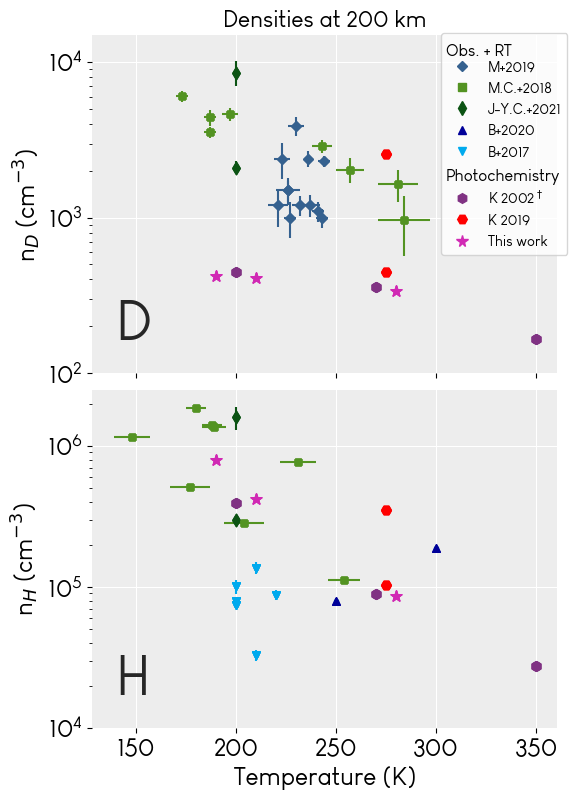

In [15]:
rcParams = PyCall.PyDict(matplotlib."rcParams")
rcParams["font.sans-serif"] = ["Louis George Caf?"]
rcParams["font.monospace"] = ["FreeMono"]
rcParams["font.size"] = 14
rcParams["axes.labelsize"]= 18
rcParams["xtick.labelsize"] = 18
rcParams["ytick.labelsize"] = 18


fig, ax = subplots(2,1, sharex=true, figsize=(6,9))
subplots_adjust(hspace=0.05)
for a in ax
    plot_bg(a)
    a.set_yscale("log")
end

coldict = Dict("Mayyasi2019"=>"#35618f", "Chaffin2018"=>"#539322", "Kras2002"=>"#803283", "Chaufray2021"=>"#0b5313",  "This work"=>"#d129b4",
"Bhattacharyya2020"=>"#000099", "Kras2019"=>"#ff0000", "Bhattacharyya2017"=>"#00aaee")
shapedict = Dict("Mayyasi2019"=>"D", "Chaffin2018"=>"s", "Kras2002"=>"h", "Kras2019"=>"H", "Chaufray2021"=>"d",  "This work"=>"*",
"Bhattacharyya2020"=>"^",  "Bhattacharyya2017"=>"v")
sizedict = Dict("Mayyasi2019"=>20, "Chaffin2018"=>25, "Kras2002"=>50, "Kras2019"=>50, "Chaufray2021"=>40,  "This work"=>65,
"Bhattacharyya2020"=>30,  "Bhattacharyya2017"=>30)

colors = [coldict[r] for r in data."Ref"]
# shapes = [coldict[s] for s in data."Ref"]

T, n = data."Temp", data."nD"
ax[1].errorbar(T, n, yerr=data."nDuncert", xerr=data."Tuncert", fmt=".", ecolor=colors, zorder=9)

for r in data."Ref"
    this_T = data[in([r]).(data."Ref"), "Temp"]
    this_n = data[in([r]).(data."Ref"), "nD"]
    ax[1].scatter(this_T, this_n, c=coldict[r], s=sizedict[r], marker=shapedict[r], zorder=10)
end

ax[1].set_ylim(1e2, 1.5e4)
ax[1].set_title("Densities at 200 km")
ax[1].set_ylabel(L"n$_D$ (cm$^{-3}$)")
ax[1].set_yscale("log")


# H panel
colorsH = [coldict[r] for r in dataH."Ref"]
T, n = dataH."Temp", dataH."nH"

ax[2].errorbar(T, n, yerr=dataH."nHuncert", xerr=dataH."Tuncert", fmt=".", ecolor=colorsH)
for r in dataH."Ref"
    this_T = dataH[in([r]).(dataH."Ref"), "Temp"]
    this_n = dataH[in([r]).(dataH."Ref"), "nH"]
    ax[2].scatter(this_T, this_n, c=coldict[r], s=sizedict[r], marker=shapedict[r], zorder=10)
end
# ax[2].scatter(T, n, c=colorsH, s=50, zorder=10)

ax[2].set_ylabel(L"n$_H$ (cm$^{-3}$)")
ax[2].set_xlabel("Temperature (K)")
ax[2].set_ylim(1e4, 2.5e6)

ax[1].text(0.05, 0.1, "D", color="#262626", fontsize=40, transform=ax[1].transAxes)
ax[2].text(0.05, 0.1, "H", color="#262626", fontsize=40, transform=ax[2].transAxes)
# legend
L2D = PyPlot.matplotlib.lines.Line2D
lines = [L2D([0], [0], linewidth=0, marker="", color="white"),
         L2D([0], [0], linewidth=0, ms=sizedict["Mayyasi2019"]/6+2, marker=shapedict["Mayyasi2019"], color=coldict["Mayyasi2019"]),
         L2D([0], [0], linewidth=0, ms=sizedict["Chaffin2018"]/6+2, marker=shapedict["Chaffin2018"], color=coldict["Chaffin2018"]),
         L2D([0], [0], linewidth=0, ms=sizedict["Chaufray2021"]/8+2, marker=shapedict["Chaufray2021"], color=coldict["Chaufray2021"]),
         L2D([0], [0], linewidth=0, ms=sizedict["Bhattacharyya2020"]/8+2, marker=shapedict["Bhattacharyya2020"], color=coldict["Bhattacharyya2020"]),
         L2D([0], [0], linewidth=0, ms=sizedict["Bhattacharyya2017"]/8+2, marker=shapedict["Bhattacharyya2017"], color=coldict["Bhattacharyya2017"]),
         L2D([0], [0], linewidth=0, marker="", color="white"),
         L2D([0], [0], linewidth=0, ms=sizedict["Kras2002"]/10+2, marker=shapedict["Kras2002"], color=coldict["Kras2002"]),
         L2D([0], [0], linewidth=0, ms=sizedict["Kras2019"]/10+2, marker=shapedict["Kras2019"], color=coldict["Kras2019"]),
         L2D([0], [0], linewidth=0, ms=sizedict["This work"]/10+2, marker=shapedict["This work"], color=coldict["This work"])]
ax[1].text(0.76, 0.94, "Obs. + RT", color="black", transform=ax[1].transAxes, zorder=16, fontsize=12)
ax[1].text(0.76, 0.57, "Photochemistry", color="black", transform=ax[1].transAxes, zorder=16, fontsize=12)
ax[1].legend(lines, [" ", "M+2019", "M.C.+2018", "J-Y.C.+2021", "B+2020", "B+2017"," ", 
                     L"K 2002$^\dagger$", "K 2019", "This work"], fontsize=10.5, loc=(0.75,0.35))

savefig(all_result_plot_folder*"combined_D_H_densities.pdf", format="pdf", dpi=300, bbox_inches="tight")
show()